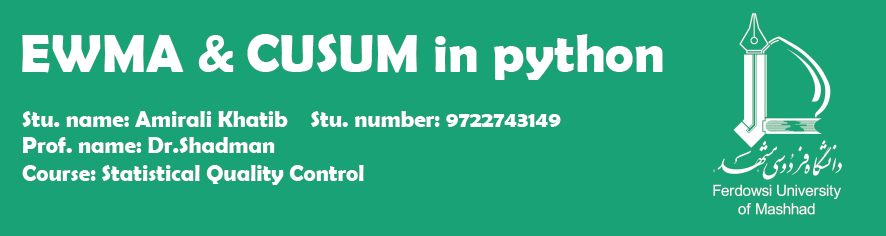

## import libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as stats

# Question 1

## data Example 9.1

In [2]:
data = np.array([9.45,7.99,9.29,11.66,12.16,
                 10.18,8.04,11.46,9.2,10.34,
                 9.03,11.47,10.51,9.4,10.08,
                 9.37,10.62,10.31,8.52,10.84,
                 10.9,9.33,12.29,11.5,10.6,
                 11.08,10.38,11.62,11.31,10.52])

# CUSUM

## Functions

In [3]:
def Cplus(x,mu,K,Cip):
    return (x - (mu + K)), max(0,x - (mu + K) + Cip[-1])

def Cneg(x,mu,K,Cin):
    return ((mu - K) - x), max(0,(mu - K) - x + Cin[-1])

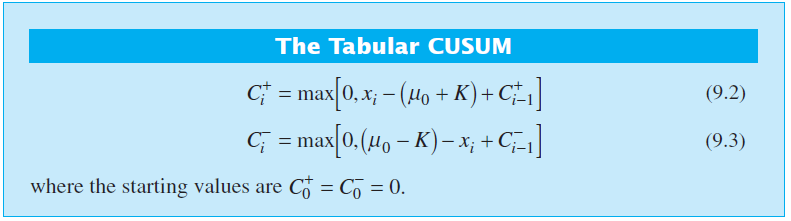

In [4]:
def data_builder(Cip, Cin, cp, cn, Nplus, Nneg, Np, Nn):
    Cip.append(cp)
    Cin.append(cn)
    if ((cp != 0) & (cn == 0)):
        Np += 1
        Nn = 0
        Nplus.append(Np)
        Nneg.append(Nn)
    elif ((cn != 0) & (cp == 0)):
        Nn += 1
        Np = 0
        Nplus.append(Np)
        Nneg.append(Nn)
    elif ((cn != 0) & (cp != 0)):
        Nn += 1
        Np += 1
        Nplus.append(Np)
        Nneg.append(Nn)
    elif ((cn == 0) & (cp == 0)):
        Nn = 0
        Np = 0
        Nplus.append(Np)
        Nneg.append(Nn)        
    return Cip,Cin,Nplus,Nneg,Np,Nn

In [5]:
def new_mu(Cip,Cin,Nplus,Nneg,H,K,mu,signal_point):
    if Cip[signal_point - 1] > H:
        return mu + K + (Cip[signal_point - 1]) / Nplus[signal_point - 1]
    else:
        return None
    if Cin[signal_point - 1] > H:
        return mu - K - (Cin[signal_point - 1]) / Nneg[signal_point - 1]
    else:
        return None

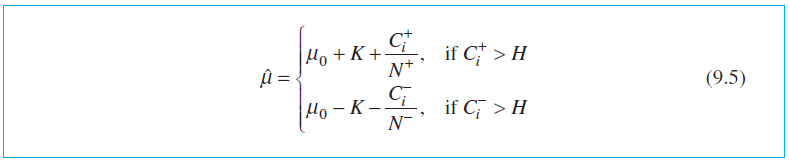

In [6]:
def CUSUM_main(data,mu,std,k,h):
    # initialize
    Cip = []
    Cin = []
    CPL = []
    CNL = []
    Nplus = []
    Np = 0
    Nneg = []
    Nn = 0
    counter = 0
    signal_point = None
    H = h * std
    K = k * std
    # main_code
    for i in range(0,len(data)):
        sample_number = i+1
        if i == 0:
            Cip.append(0)
            Cin.append(0)
            CP,cp = Cplus(data[i],mu,K,Cip)
            CN,cn = Cneg(data[i],mu,K,Cin)
            del Cip[0]
            del Cin[0]
            CPL.append(CP)
            CNL.append(CN)
            if ((cp > H) | (cn > H)):
                Cip,Cin,Nplus,Nneg,Np,Nn = data_builder(Cip, Cin, cp, cn, Nplus, Nneg, Np, Nn)
                if counter == 0:
                    signal_point = sample_number
                    mu1 = new_mu(Cip,Cin,Nplus,Nneg,H,K,mu,signal_point)
                    if cp > H:
                        change_point = signal_point - Nplus[i]
                    if cn > H:
                        change_point = signal_point - Nneg[i]    
                    counter+=1
                    continue
                else:
                    continue
            else:
                Cip,Cin,Nplus,Nneg,Np,Nn = data_builder(Cip, Cin, cp, cn, Nplus, Nneg, Np, Nn)
                continue
        else:
            CP,cp = Cplus(data[i],mu,K,Cip)
            CN,cn = Cneg(data[i],mu,K,Cin)
            CPL.append(CP)
            CNL.append(CN)
            if ((cp > H) | (cn > H)):
                Cip,Cin,Nplus,Nneg,Np,Nn = data_builder(Cip, Cin, cp, cn, Nplus, Nneg, Np, Nn)
                if counter == 0:
                    signal_point = sample_number
                    mu1 = new_mu(Cip,Cin,Nplus,Nneg,H,K,mu,signal_point)
                    if cp > H:
                        change_point = signal_point - Nplus[i]
                    if cn > H:
                        change_point = signal_point - Nneg[i]
                    counter+=1
                    continue
                else:
                    continue
            else:
                Cip,Cin,Nplus,Nneg,Np,Nn = data_builder(Cip, Cin, cp, cn, Nplus, Nneg, Np, Nn)
                continue
    
    
    #CUSUM Table
    data_table = np.column_stack(
        (np.array(data),        # xi
         np.array(Cip),         # Ci+
         np.array(Nplus),       # N+
         np.array(Cin),         # Ci-
         np.array(Nneg)))       # N-
    
    
    cusum_dataframe = pd.DataFrame(data_table, 
                                   index = range(1,len(data)+1),
                                   columns = ['Xi','Ci+','N+','Ci-','N-'])
    cusum_dataframe.index.name = 'Period i'
    print('The Tabular CUSUM for Example 9.1\n')
    print(cusum_dataframe)
    
    #CUSUM Plot
    CUSUM_LCL = (-1)*H
    CUSUM_UCL = H
    period_i = np.arange(1,len(data)+1, 1)

    plt.figure(figsize=(15,10))
    plt.title("CUSUM chart")
    plt.xlabel("Period")
    plt.ylabel("CUSUM")
    plt.bar(period_i, Cip, color = 'blue', alpha = 0.5) # Plot the data
    plt.bar(period_i,[(-1)*c for c in Cin], color = 'blue',alpha = 0.5) # Plot the data
    # plt.scatter(period_i, [u if u > 0 else None for u in CPL], color = 'black') #[output if condition else output for l in list]
    # plt.scatter(period_i, [(-1)*d if d > 0 else None for d in CNL], color = 'black' ) #[output if condition else output for l in list]
    plt.plot(period_i, [0.0 for i in range(len(data))], 'black') # Plot the CL
    plt.plot(period_i, [CUSUM_UCL for i in range(len(data))], 'red') # Plot the UCL
    plt.plot(period_i,[CUSUM_LCL for i in range(len(data))], 'red') # Plot the LCL
    plt.show()
    
    print('\nSo the shift likely occurred between periods', change_point,'and', change_point+1 )
    print('Signal also occcured in period',signal_point)
    print('The new process mean following the shift is',mu1)
    
    return Cip,Cin,CPL,CNL,Nplus,Nneg,Np,Nn,signal_point,change_point,mu1

The Tabular CUSUM for Example 9.1

             Xi   Ci+   N+   Ci-   N-
Period i                             
1          9.45  0.00  0.0  0.05  1.0
2          7.99  0.00  0.0  1.56  2.0
3          9.29  0.00  0.0  1.77  3.0
4         11.66  1.16  1.0  0.00  0.0
5         12.16  2.82  2.0  0.00  0.0
6         10.18  2.50  3.0  0.00  0.0
7          8.04  0.04  4.0  1.46  1.0
8         11.46  1.00  5.0  0.00  0.0
9          9.20  0.00  0.0  0.30  1.0
10        10.34  0.00  0.0  0.00  0.0
11         9.03  0.00  0.0  0.47  1.0
12        11.47  0.97  1.0  0.00  0.0
13        10.51  0.98  2.0  0.00  0.0
14         9.40  0.00  0.0  0.10  1.0
15        10.08  0.00  0.0  0.00  0.0
16         9.37  0.00  0.0  0.13  1.0
17        10.62  0.12  1.0  0.00  0.0
18        10.31  0.00  0.0  0.00  0.0
19         8.52  0.00  0.0  0.98  1.0
20        10.84  0.34  1.0  0.00  0.0
21        10.90  0.74  2.0  0.00  0.0
22         9.33  0.00  0.0  0.17  1.0
23        12.29  1.79  1.0  0.00  0.0
24        11.50

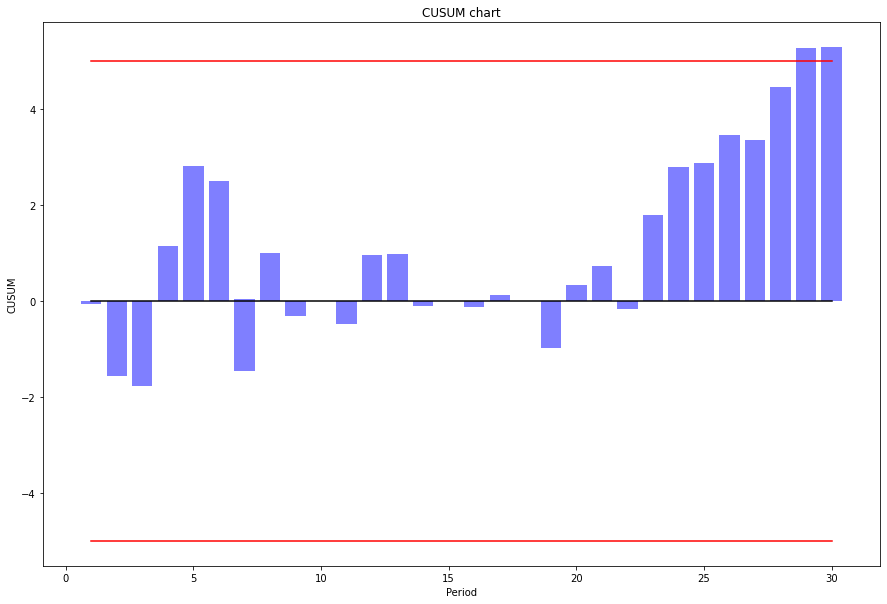


So the shift likely occurred between periods 22 and 23
Signal also occcured in period 29
The new process mean following the shift is 11.254285714285714


In [7]:
Cip,Cin,CPL,CNL,Nplus,Nneg,Np,Nn,signal,change,mu1 = CUSUM_main(data,10,1,0.5,5)

# EWMA

## Functions

In [8]:
def Zi(x,Lambda,Z):
    return Lambda * x + (1-Lambda) * Z[-1]

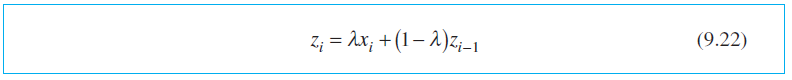

In [9]:
def cl_factor(i,Lambda):
    return np.sqrt((Lambda/(2-Lambda))*(1-(1-Lambda)**(2*i)))


def EWMA_UCL_LCL(data,mu,std,L,Lambda):
    EWMA_UCL = []
    EWMA_LCL = [] 
    for i in range(1,len(data)+1):
        EWMA_UCL.append(mu + L * std * cl_factor(i,Lambda))
        EWMA_LCL.append(mu - L * std * cl_factor(i,Lambda))
    return EWMA_LCL, EWMA_UCL    

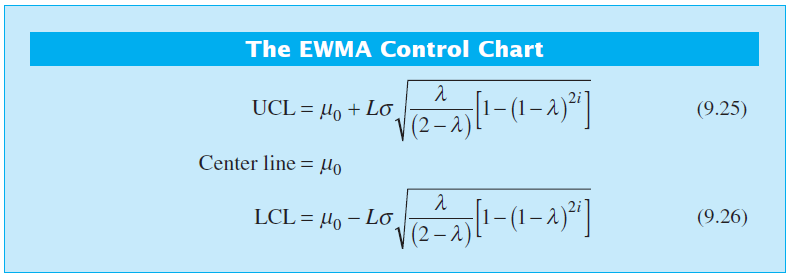

In [10]:
def EWMA_main(data,mu,std,L,Lambda):
    #initialize
    signal_point = None
    counter = 0
    Z = []
    # define ucl & lcl
    EWMA_LCL, EWMA_UCL = EWMA_UCL_LCL(data,mu,std,L,Lambda)
    #main code
    for i in range(0,len(data)):
        sample_number = i+1
        if i == 0:
            Z.append(mu)
            Z.append(Zi(data[i],Lambda,Z))
            del Z[0]
            if ((Z[i] > EWMA_UCL[i])|(Z[i] < EWMA_LCL[i])):
                if counter == 0:
                    signal_point = sample_number
                    counter += 1
                    continue
        else:
            Z.append(Zi(data[i],Lambda,Z))
            if ((Z[i] > EWMA_UCL[i])|(Z[i] < EWMA_LCL[i])):
                if counter == 0:
                    signal_point = sample_number
                    counter += 1
                    continue
    
    
    #EWMA Table
    data_table = np.column_stack(
        (np.array(data),        # xi
         np.array(Z)))          # Zi

    ewma_dataframe = pd.DataFrame(data_table, 
                                   index = range(1,len(data)+1),
                                   columns = ['Xi','Zi'])
    ewma_dataframe.index.name = 'Subgroup i'
    print('The Tabular EWMA for Example 9.1\n')
    print(ewma_dataframe)
    
    
    #EWMA Plot 
    starts = np.arange(0, len(data), 1, dtype = int)
    stops = starts + np.ones(len(data))
    subgroup_i = np.arange(1, len(data)+1, 1, dtype = int)

    plt.figure(figsize=(15,10))
    plt.title("Exp. Weighted Moving Average control chart")
    plt.xlabel("Observation")
    plt.ylabel("EWMA")

    plt.plot(subgroup_i, [mu for i in range(len(data))], 'blue') # Plot the CL
    plt.plot(subgroup_i, Z, 'green') # Plot the CL

    plt.hlines(EWMA_UCL,starts,stops, 'red') # Plot the UCL
    plt.hlines(EWMA_LCL,starts,stops, 'red') # Plot the LCL
    plt.show()
    
    print('Signal also occcured in period',signal_point)
                
    return Z,signal_point

The Tabular EWMA for Example 9.1

               Xi         Zi
Subgroup i                  
1            9.45   9.945000
2            7.99   9.749500
3            9.29   9.703550
4           11.66   9.899195
5           12.16  10.125276
6           10.18  10.130748
7            8.04   9.921673
8           11.46  10.075506
9            9.20   9.987955
10          10.34  10.023160
11           9.03   9.923844
12          11.47  10.078459
13          10.51  10.121613
14           9.40  10.049452
15          10.08  10.052507
16           9.37   9.984256
17          10.62  10.047831
18          10.31  10.074048
19           8.52   9.918643
20          10.84  10.010778
21          10.90  10.099701
22           9.33  10.022731
23          12.29  10.249458
24          11.50  10.374512
25          10.60  10.397061
26          11.08  10.465355
27          10.38  10.456819
28          11.62  10.573137
29          11.31  10.646823
30          10.52  10.634141


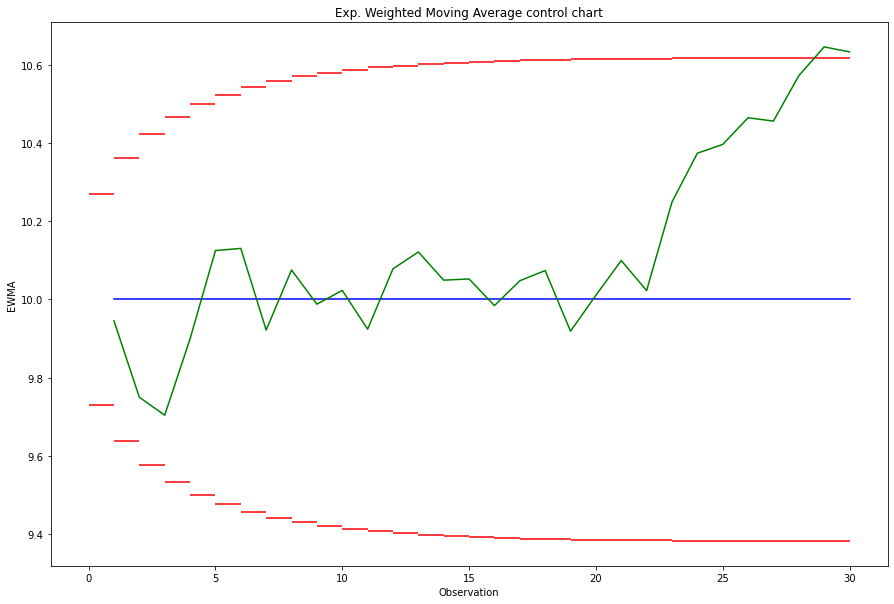

Signal also occcured in period 29


In [11]:
Z,signal = EWMA_main(data,10,1,2.7,0.1)

# Question 2

# Simulation: CUSUM

## Simulation ARL

In [12]:
def CUSUM_main_simarl(data,mu,std,k,h):
    #intialize
    Cip = []
    Cin = []
    CPL = []
    CNL = []
    Nplus = []
    Np = 0
    Nneg = []
    Nn = 0
    counter = 0
    signal_point = None
    mu1 = None
    change_point = None
    H = h * std
    K = k * std
    # main_code
    for i in range(0,len(data)):
        sample_number = i+1
        
        if i == 0:
            Cip.append(0)
            Cin.append(0)
            CP,cp = Cplus(data[i],mu,K,Cip)
            CN,cn = Cneg(data[i],mu,K,Cin)
            del Cip[0]
            del Cin[0]
            CPL.append(CP)
            CNL.append(CN)
            if ((cp > H) | (cn > H)):
                Cip,Cin,Nplus,Nneg,Np,Nn = data_builder(Cip, Cin, cp, cn, Nplus, Nneg, Np, Nn)
                if counter == 0:
                    signal_point = sample_number
                    mu1 = new_mu(Cip,Cin,Nplus,Nneg,H,K,mu,signal_point)
                    if cp > H:
                        change_point = signal_point - Nplus[i]
                    if cn > H:
                        change_point = signal_point - Nneg[i]
                    counter+=1
                    break
                else:
                    continue
            else:
                Cip,Cin,Nplus,Nneg,Np,Nn = data_builder(Cip, Cin, cp, cn, Nplus, Nneg, Np, Nn)
                continue
        else:
            CP,cp = Cplus(data[i],mu,K,Cip)
            CN,cn = Cneg(data[i],mu,K,Cin)
            CPL.append(CP)
            CNL.append(CN)
            if ((cp > H) | (cn > H)):
                Cip,Cin,Nplus,Nneg,Np,Nn = data_builder(Cip, Cin, cp, cn, Nplus, Nneg, Np, Nn)
                if counter == 0:
                    signal_point = sample_number
                    mu1 = new_mu(Cip,Cin,Nplus,Nneg,H,K,mu,signal_point)
                    if cp > H:
                        change_point = signal_point - Nplus[i]
                    if cn > H:
                        change_point = signal_point - Nneg[i]
                    counter+=1
                    break
                else:
                    continue
            else:
                Cip,Cin,Nplus,Nneg,Np,Nn = data_builder(Cip, Cin, cp, cn, Nplus, Nneg, Np, Nn)
                continue
    return signal_point

In [13]:
def ARL_CUSUM_Simulator(shift,h,k,std,mu,iteration):
    shift1 = shift * std
    mu1 = mu + shift1
    ARLS = []

    for Iter in range(iteration):
        data = np.random.normal(mu1,std,size = 10000)
        signal = CUSUM_main_simarl(data,mu,std,k,h)        
        if signal != None:
            ARLS.append(signal)
        else:
            pass    
    return np.mean(ARLS)

## Table 9.3 ARL

In [14]:
def Table9_3ARL(shift_list,h_list,k,std,mu,iteration):
    data_table = []
    for h in h_list:
        temp = []
        for shift in shift_list:
            temp.append(ARL_CUSUM_Simulator(shift,h,k,std,mu,iteration))
        data_table.append(temp)

    data9_3 = np.transpose(np.array(data_table))
    table9_3 = pd.DataFrame(data9_3,
                 columns = ['h=4','h=4.77','h=5'],
                 index=shift_list)
    table9_3.index.name = 'Shift in Mean(Multiple of sigma)'
    return table9_3

In [15]:
shift_list = [0,0.25,0.5,1,1.5,2,2.5,3,4]
h_list = [4,4.77,5]
k = 0.5
std = 1
mu = 10
iteration = 30000
Table9_3ARL(shift_list,h_list,k,std,mu,iteration)

,h=4,h=4.77,h=5
Shift in Mean(Multiple of sigma),,,
0.00,167.182800,371.100633,468.617500
0.25,73.892833,121.094233,140.104200
0.50,26.724200,35.186733,38.265367
1.00,8.368267,9.917233,10.397433
1.50,4.752367,5.513267,5.761767
2.00,3.338767,3.861733,4.001267
2.50,2.622600,2.994767,3.111900
3.00,2.195933,2.484167,2.568667
4.00,1.711267,1.958133,2.015100


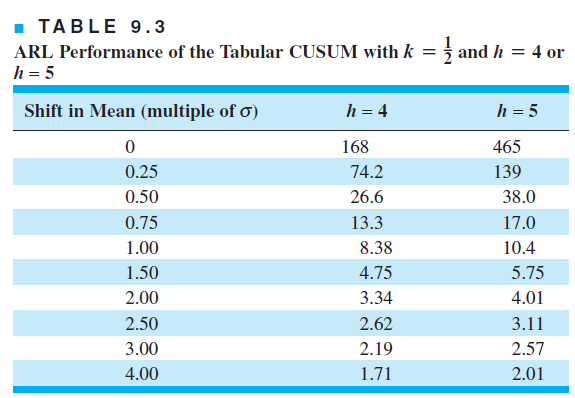

## Simulation for new process mean following the shift

In [16]:
def CUSUM_main_simmu2(data,mu,std,k,h):
    #intialize
    Cip = []
    Cin = []
    CPL = []
    CNL = []
    Nplus = []
    Np = 0
    Nneg = []
    Nn = 0
    counter = 0
    signal_point = None
    mu1 = None
    change_point = None
    H = h * std
    K = k * std
    # main_code
    for i in range(0,len(data)):
        sample_number = i+1
        
        if i == 0:
            Cip.append(0)
            Cin.append(0)
            CP,cp = Cplus(data[i],mu,K,Cip)
            CN,cn = Cneg(data[i],mu,K,Cin)
            del Cip[0]
            del Cin[0]
            CPL.append(CP)
            CNL.append(CN)
            if ((cp > H) | (cn > H)):
                Cip,Cin,Nplus,Nneg,Np,Nn = data_builder(Cip, Cin, cp, cn, Nplus, Nneg, Np, Nn)
                if counter == 0:
                    signal_point = sample_number
                    mu1 = new_mu(Cip,Cin,Nplus,Nneg,H,K,mu,signal_point)
                    if cp > H:
                        change_point = signal_point - Nplus[i]
                    if cn > H:
                        change_point = signal_point - Nneg[i]
                    counter+=1
                    break
                else:
                    continue
            else:
                Cip,Cin,Nplus,Nneg,Np,Nn = data_builder(Cip, Cin, cp, cn, Nplus, Nneg, Np, Nn)
                continue
        else:
            CP,cp = Cplus(data[i],mu,K,Cip)
            CN,cn = Cneg(data[i],mu,K,Cin)
            CPL.append(CP)
            CNL.append(CN)
            if ((cp > H) | (cn > H)):
                Cip,Cin,Nplus,Nneg,Np,Nn = data_builder(Cip, Cin, cp, cn, Nplus, Nneg, Np, Nn)
                if counter == 0:
                    signal_point = sample_number
                    mu1 = new_mu(Cip,Cin,Nplus,Nneg,H,K,mu,signal_point)
                    if cp > H:
                        change_point = signal_point - Nplus[i]
                    if cn > H:
                        change_point = signal_point - Nneg[i]
                    counter+=1
                    break
                else:
                    continue
            else:
                Cip,Cin,Nplus,Nneg,Np,Nn = data_builder(Cip, Cin, cp, cn, Nplus, Nneg, Np, Nn)
                continue
    return mu1

In [17]:
def MU2_CUSUM_Simulator(shift,h,k,std,mu,iteration):
    shift1 = shift * std
    mu1 = mu + shift1
    MU2S = []

    for Iter in range(iteration):
        data = np.random.normal(mu1,std,size = 10000)
        mu2 = CUSUM_main_simmu2(data,mu,std,k,h)        
        if mu2 != None:
            MU2S.append(mu2)
        else:
            pass    
    return np.mean(MU2S)

## Table 9.3 New mean of process

In [18]:
def Table9_3MU2(shift_list,h_list,k,std,mu,iteration):
    data_table = []
    for h in h_list:
        temp = []
        for shift in shift_list:
            temp.append(MU2_CUSUM_Simulator(shift,h,k,std,mu,iteration))
        data_table.append(temp)

    data9_3 = np.transpose(np.array(data_table))
    table9_3 = pd.DataFrame(data9_3,
                 columns = ['h=4','h=4.77','h=5'],
                 index=shift_list)
    table9_3.index.name = 'Shift in Mean(Multiple of sigma)'
    return table9_3

In [19]:
shift_list = [0,0.25,0.5,1,1.5,2,2.5,3,4]
h_list = [4,4.77,5]
k = 0.5
std = 1
mu = 10
iteration = 30000
Table9_3MU2(shift_list,h_list,k,std,mu,iteration)

,h=4,h=4.77,h=5
Shift in Mean(Multiple of sigma),,,
0.00,11.361635,11.317178,11.304962
0.25,11.238069,11.171569,11.158205
0.50,11.193113,11.118910,11.106263
1.00,11.386986,11.330023,11.324564
1.50,11.772021,11.744073,11.739684
2.00,12.209498,12.195516,12.188323
2.50,12.676506,12.659600,12.646244
3.00,13.153309,13.125745,13.133655
4.00,14.187910,14.126200,14.090823


## Simulation for change point

In [20]:
def CUSUM_main_simchng(data,mu,std,k,h):
    #intialize
    Cip = []
    Cin = []
    CPL = []
    CNL = []
    Nplus = []
    Np = 0
    Nneg = []
    Nn = 0
    counter = 0
    signal_point = None
    mu1 = None
    change_point = None
    H = h * std
    K = k * std
    # main_code
    for i in range(0,len(data)):
        sample_number = i+1
        
        if i == 0:
            Cip.append(0)
            Cin.append(0)
            CP,cp = Cplus(data[i],mu,K,Cip)
            CN,cn = Cneg(data[i],mu,K,Cin)
            del Cip[0]
            del Cin[0]
            CPL.append(CP)
            CNL.append(CN)
            if ((cp > H) | (cn > H)):
                Cip,Cin,Nplus,Nneg,Np,Nn = data_builder(Cip, Cin, cp, cn, Nplus, Nneg, Np, Nn)
                if counter == 0:
                    signal_point = sample_number
                    mu1 = new_mu(Cip,Cin,Nplus,Nneg,H,K,mu,signal_point)
                    if cp > H:
                        change_point = signal_point - Nplus[i]
                    if cn > H:
                        change_point = signal_point - Nneg[i]
                    counter+=1
                    break
                else:
                    continue
            else:
                Cip,Cin,Nplus,Nneg,Np,Nn = data_builder(Cip, Cin, cp, cn, Nplus, Nneg, Np, Nn)
                continue
        else:
            CP,cp = Cplus(data[i],mu,K,Cip)
            CN,cn = Cneg(data[i],mu,K,Cin)
            CPL.append(CP)
            CNL.append(CN)
            if ((cp > H) | (cn > H)):
                Cip,Cin,Nplus,Nneg,Np,Nn = data_builder(Cip, Cin, cp, cn, Nplus, Nneg, Np, Nn)
                if counter == 0:
                    signal_point = sample_number
                    mu1 = new_mu(Cip,Cin,Nplus,Nneg,H,K,mu,signal_point)
                    if cp > H:
                        change_point = signal_point - Nplus[i]
                    if cn > H:
                        change_point = signal_point - Nneg[i]
                    counter+=1
                    break
                else:
                    continue
            else:
                Cip,Cin,Nplus,Nneg,Np,Nn = data_builder(Cip, Cin, cp, cn, Nplus, Nneg, Np, Nn)
                continue
    return change_point

In [21]:
def CHNG_CUSUM_Simulator(shift,h,k,std,mu,iteration):
    shift1 = shift * std
    mu1 = mu + shift1
    CHNGS = []

    for Iter in range(iteration):
        data = np.random.normal(mu1,std,size = 10000)
        change = CUSUM_main_simchng(data,mu,std,k,h)      
        if change != None:
            CHNGS.append(change)
        else:
            pass    
    return np.mean(CHNGS)

## Table 9.3 Change point

In [22]:
def Table9_3CHNG(shift_list,h_list,k,std,mu,iteration):
    data_table = []
    for h in h_list:
        temp = []
        for shift in shift_list:
            temp.append(CHNG_CUSUM_Simulator(shift,h,k,std,mu,iteration))
        data_table.append(temp)

    data9_3 = np.transpose(np.array(data_table))
    table9_3 = pd.DataFrame(data9_3,
                 columns = ['h=4','h=4.77','h=5'],
                 index=shift_list)
    table9_3.index.name = 'Shift in Mean(Multiple of sigma)'
    return table9_3

In [23]:
shift_list = [0,0.25,0.5,1,1.5,2,2.5,3,4]
h_list = [4,4.77,5]
k = 0.5
std = 1
mu = 10
iteration = 30000
Table9_3CHNG(shift_list,h_list,k,std,mu,iteration)

,h=4,h=4.77,h=5
Shift in Mean(Multiple of sigma),,,
0.00,162.663733,363.689200,454.082800
0.25,66.165033,110.020500,128.897733
0.50,17.520933,23.225533,25.107133
1.00,1.686567,1.758533,1.744767
1.50,0.318067,0.335667,0.333567
2.00,0.092267,0.089800,0.091300
2.50,0.024433,0.025333,0.025167
3.00,0.006367,0.007167,0.006433
4.00,0.000200,0.000100,0.000167


# Question 3

## Simulation: EWMA

In [24]:
def EWMA_main_simarl(data,mu,std,L,Lambda):
    #initialize
    Z = []
    signal_point = None
    #define ucl and lcl
    EWMA_LCL, EWMA_UCL = EWMA_UCL_LCL(data,mu,std,L,Lambda)
    #main_code
    for i in range(0,len(data)):
        sample_number = i+1
        if i == 0:
            Z.append(mu)
            Z.append(Zi(data[i],Lambda,Z))
            del Z[0]
            if ((Z[i] > EWMA_UCL[i])|(Z[i] < EWMA_LCL[i])):
                signal_point = sample_number
                break
        else:
            Z.append(Zi(data[i],Lambda,Z))
            if ((Z[i] > EWMA_UCL[i])|(Z[i] < EWMA_LCL[i])):
                signal_point = sample_number
                break
    return signal_point

In [25]:
def ARL_EWMA_Simulator(shift,Lambda,L,std,mu,iteration):
    shift1 = shift * std
    mu1 = mu + shift1
    ARLS = []
    for Iter in range(iteration):
        data = np.random.normal(mu1,std,size = 10000)
        signal = EWMA_main_simarl(data,mu,std,L,Lambda)
        if signal != None:
            ARLS.append(signal)
        else:
            continue        
    return np.mean(ARLS)

## Table 9.11 ARL

In [26]:
def Table9_11ARL(shift_list,L_list,Lambda_list,std,mu,iteration):
    data_table = []
    for L , Lambda in zip(L_list,Lambda_list):
        temp = []
        for shift in shift_list:
            temp.append(ARL_EWMA_Simulator(shift,Lambda,L,std,mu,iteration))
        data_table.append(temp)         
    data9_11 = np.transpose(np.array(data_table))
    table9_11 = pd.DataFrame(data9_11,
                 columns = ['L=3.054-lambda=0.4','L=2.998-lambda=0.25','L=2.962-lambda=0.2',
                            'L=2.814-lambda=0.1','L=2.615-lambda=0.05','L=3-lambda=1'],
                 index=shift_list)
    table9_11.index.name = 'Shift in Mean(Multiple of sigma)'
    return table9_11

In [27]:
shift_list = [0,0.25,0.5,1,1.5,2,2.5,3,4]
L_list = [3.054,2.998,2.962,2.814,2.615,3]
Lambda_list = [0.4,0.25,0.20,0.10,0.05,1]
mu = 10
iteration = 5000
Table9_11ARL(shift_list,L_list,Lambda_list,std,mu,iteration)

,L=3.054-lambda=0.4,L=2.998-lambda=0.25,L=2.962-lambda=0.2,L=2.814-lambda=0.1,L=2.615-lambda=0.05,L=3-lambda=1
Shift in Mean(Multiple of sigma),,,,,,
0.00,493.0356,495.8278,497.9262,474.4714,461.0472,374.4796
0.25,221.3820,167.3528,148.7144,100.9936,75.8682,284.4276
0.50,69.2582,46.5264,39.5920,28.3836,23.5450,154.4048
1.00,13.6762,10.3788,9.5284,8.0536,7.1998,43.9296
1.50,5.5540,4.8436,4.5936,4.1512,3.7038,15.0444
2.00,3.1434,2.9286,2.8644,2.6080,2.3964,6.2950
2.50,2.1660,2.0980,2.0544,1.9190,1.7836,3.2070
3.00,1.6632,1.6236,1.5904,1.4904,1.3918,1.9670
4.00,1.1766,1.1576,1.1606,1.1230,1.0832,1.1996


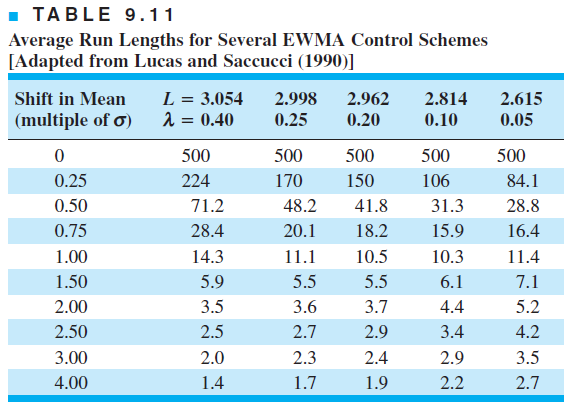

In [59]:
ARL_EWMA_Simulator(0,0.4,3.054,1,10,100000)  #(shift,Lambda,L,std,mu,iteration)

0 : 543
1 : 179
2 : 1672
3 : 79
4 : 730
5 : 264
6 : 226
7 : 511
8 : 76
9 : 662
10 : 27
11 : 70
12 : 36
13 : 686
14 : 581
15 : 287
16 : 32
17 : 1080
18 : 461
19 : 211
20 : 242
21 : 291
22 : 452
23 : 54
24 : 81
25 : 530
26 : 415
27 : 157
28 : 113
29 : 250
30 : 417
31 : 84
32 : 822
33 : 1034
34 : 339
35 : 468
36 : 575
37 : 21
38 : 218
39 : 281
40 : 321
41 : 184
42 : 102
43 : 851
44 : 57
45 : 1980
46 : 362
47 : 1428
48 : 32
49 : 726
50 : 804
51 : 26
52 : 1864
53 : 81
54 : 476
55 : 324
56 : 180
57 : 227
58 : 396
59 : 1042
60 : 165
61 : 260
62 : 300
63 : 1019
64 : 870
65 : 151
66 : 66
67 : 1433
68 : 115
69 : 46
70 : 543
71 : 334
72 : 284
73 : 1259
74 : 294
75 : 232
76 : 593
77 : 233
78 : 865
79 : 171
80 : 357
81 : 341
82 : 232
83 : 217
84 : 625
85 : 258
86 : 220
87 : 5
88 : 221
89 : 440
90 : 326
91 : 1250
92 : 38
93 : 239
94 : 544
95 : 38
96 : 1281
97 : 603
98 : 182
99 : 205
100 : 805
101 : 327
102 : 120
103 : 2386
104 : 249
105 : 597
106 : 1062
107 : 627
108 : 795
109 : 1276
110 : 854
111 :

841 : 13
842 : 397
843 : 765
844 : 504
845 : 410
846 : 399
847 : 248
848 : 75
849 : 142
850 : 678
851 : 675
852 : 417
853 : 112
854 : 142
855 : 285
856 : 567
857 : 485
858 : 491
859 : 1206
860 : 327
861 : 1868
862 : 993
863 : 670
864 : 506
865 : 106
866 : 927
867 : 931
868 : 255
869 : 459
870 : 482
871 : 141
872 : 870
873 : 256
874 : 41
875 : 349
876 : 426
877 : 231
878 : 148
879 : 340
880 : 30
881 : 110
882 : 281
883 : 298
884 : 55
885 : 344
886 : 149
887 : 366
888 : 573
889 : 36
890 : 197
891 : 187
892 : 213
893 : 334
894 : 261
895 : 611
896 : 766
897 : 97
898 : 1009
899 : 903
900 : 92
901 : 210
902 : 158
903 : 43
904 : 948
905 : 507
906 : 216
907 : 1749
908 : 658
909 : 658
910 : 696
911 : 1029
912 : 828
913 : 419
914 : 105
915 : 702
916 : 67
917 : 831
918 : 225
919 : 154
920 : 1501
921 : 473
922 : 59
923 : 126
924 : 148
925 : 85
926 : 899
927 : 166
928 : 61
929 : 34
930 : 250
931 : 260
932 : 101
933 : 1728
934 : 531
935 : 275
936 : 150
937 : 414
938 : 828
939 : 124
940 : 198
941 : 1

1607 : 177
1608 : 1192
1609 : 81
1610 : 122
1611 : 927
1612 : 243
1613 : 119
1614 : 1277
1615 : 323
1616 : 255
1617 : 1093
1618 : 70
1619 : 886
1620 : 395
1621 : 415
1622 : 196
1623 : 246
1624 : 1400
1625 : 122
1626 : 98
1627 : 213
1628 : 693
1629 : 449
1630 : 308
1631 : 105
1632 : 65
1633 : 857
1634 : 534
1635 : 287
1636 : 62
1637 : 21
1638 : 134
1639 : 665
1640 : 1119
1641 : 1250
1642 : 122
1643 : 85
1644 : 1627
1645 : 147
1646 : 182
1647 : 404
1648 : 155
1649 : 574
1650 : 185
1651 : 466
1652 : 1047
1653 : 351
1654 : 1638
1655 : 252
1656 : 41
1657 : 710
1658 : 597
1659 : 127
1660 : 1308
1661 : 443
1662 : 478
1663 : 566
1664 : 824
1665 : 1294
1666 : 192
1667 : 367
1668 : 284
1669 : 408
1670 : 437
1671 : 844
1672 : 27
1673 : 384
1674 : 69
1675 : 67
1676 : 6
1677 : 650
1678 : 148
1679 : 1546
1680 : 172
1681 : 237
1682 : 845
1683 : 857
1684 : 767
1685 : 228
1686 : 350
1687 : 390
1688 : 837
1689 : 281
1690 : 142
1691 : 736
1692 : 65
1693 : 746
1694 : 180
1695 : 2708
1696 : 226
1697 : 478


2364 : 321
2365 : 821
2366 : 735
2367 : 496
2368 : 366
2369 : 239
2370 : 691
2371 : 630
2372 : 148
2373 : 415
2374 : 1374
2375 : 1157
2376 : 84
2377 : 593
2378 : 109
2379 : 354
2380 : 486
2381 : 598
2382 : 483
2383 : 5
2384 : 55
2385 : 180
2386 : 70
2387 : 286
2388 : 1898
2389 : 82
2390 : 338
2391 : 1039
2392 : 429
2393 : 433
2394 : 572
2395 : 614
2396 : 380
2397 : 634
2398 : 797
2399 : 366
2400 : 271
2401 : 672
2402 : 199
2403 : 72
2404 : 179
2405 : 906
2406 : 508
2407 : 441
2408 : 194
2409 : 490
2410 : 15
2411 : 73
2412 : 50
2413 : 1843
2414 : 6
2415 : 181
2416 : 225
2417 : 483
2418 : 89
2419 : 181
2420 : 237
2421 : 102
2422 : 8
2423 : 899
2424 : 981
2425 : 469
2426 : 114
2427 : 95
2428 : 278
2429 : 544
2430 : 410
2431 : 72
2432 : 151
2433 : 39
2434 : 764
2435 : 2751
2436 : 350
2437 : 598
2438 : 366
2439 : 116
2440 : 421
2441 : 868
2442 : 1234
2443 : 653
2444 : 1052
2445 : 372
2446 : 295
2447 : 1010
2448 : 163
2449 : 361
2450 : 456
2451 : 38
2452 : 532
2453 : 253
2454 : 499
2455 : 54

3122 : 393
3123 : 416
3124 : 492
3125 : 287
3126 : 4
3127 : 220
3128 : 294
3129 : 8
3130 : 538
3131 : 48
3132 : 1379
3133 : 1003
3134 : 211
3135 : 87
3136 : 1061
3137 : 330
3138 : 56
3139 : 11
3140 : 57
3141 : 125
3142 : 347
3143 : 162
3144 : 271
3145 : 96
3146 : 233
3147 : 405
3148 : 970
3149 : 353
3150 : 739
3151 : 719
3152 : 99
3153 : 177
3154 : 557
3155 : 1029
3156 : 7
3157 : 497
3158 : 1418
3159 : 427
3160 : 199
3161 : 395
3162 : 2
3163 : 173
3164 : 164
3165 : 594
3166 : 204
3167 : 1254
3168 : 1151
3169 : 546
3170 : 359
3171 : 320
3172 : 917
3173 : 1255
3174 : 912
3175 : 68
3176 : 148
3177 : 25
3178 : 70
3179 : 142
3180 : 128
3181 : 19
3182 : 586
3183 : 299
3184 : 320
3185 : 382
3186 : 154
3187 : 1517
3188 : 498
3189 : 1301
3190 : 2803
3191 : 286
3192 : 178
3193 : 4
3194 : 856
3195 : 147
3196 : 696
3197 : 98
3198 : 537
3199 : 380
3200 : 250
3201 : 1926
3202 : 11
3203 : 99
3204 : 244
3205 : 271
3206 : 620
3207 : 391
3208 : 474
3209 : 571
3210 : 108
3211 : 232
3212 : 395
3213 : 29
3

3873 : 141
3874 : 463
3875 : 2
3876 : 675
3877 : 391
3878 : 1832
3879 : 79
3880 : 27
3881 : 100
3882 : 346
3883 : 879
3884 : 655
3885 : 569
3886 : 51
3887 : 309
3888 : 12
3889 : 543
3890 : 1642
3891 : 465
3892 : 461
3893 : 1143
3894 : 844
3895 : 11
3896 : 1741
3897 : 1014
3898 : 1202
3899 : 516
3900 : 683
3901 : 472
3902 : 284
3903 : 613
3904 : 393
3905 : 412
3906 : 530
3907 : 380
3908 : 1043
3909 : 62
3910 : 1149
3911 : 905
3912 : 7
3913 : 306
3914 : 928
3915 : 55
3916 : 296
3917 : 41
3918 : 1098
3919 : 994
3920 : 1134
3921 : 86
3922 : 915
3923 : 19
3924 : 189
3925 : 35
3926 : 741
3927 : 273
3928 : 53
3929 : 413
3930 : 802
3931 : 176
3932 : 284
3933 : 987
3934 : 150
3935 : 1043
3936 : 374
3937 : 2361
3938 : 115
3939 : 460
3940 : 47
3941 : 1001
3942 : 1192
3943 : 5
3944 : 950
3945 : 499
3946 : 183
3947 : 327
3948 : 705
3949 : 474
3950 : 340
3951 : 9
3952 : 1958
3953 : 44
3954 : 33
3955 : 245
3956 : 118
3957 : 42
3958 : 44
3959 : 308
3960 : 227
3961 : 411
3962 : 786
3963 : 340
3964 : 2


4631 : 262
4632 : 194
4633 : 52
4634 : 17
4635 : 377
4636 : 637
4637 : 524
4638 : 595
4639 : 205
4640 : 1929
4641 : 87
4642 : 445
4643 : 1065
4644 : 150
4645 : 257
4646 : 1859
4647 : 2000
4648 : 34
4649 : 576
4650 : 284
4651 : 1624
4652 : 220
4653 : 610
4654 : 309
4655 : 234
4656 : 56
4657 : 1
4658 : 1916
4659 : 207
4660 : 65
4661 : 1446
4662 : 535
4663 : 58
4664 : 139
4665 : 324
4666 : 35
4667 : 920
4668 : 328
4669 : 498
4670 : 617
4671 : 153
4672 : 227
4673 : 511
4674 : 372
4675 : 514
4676 : 301
4677 : 1227
4678 : 653
4679 : 320
4680 : 846
4681 : 738
4682 : 18
4683 : 227
4684 : 106
4685 : 534
4686 : 867
4687 : 123
4688 : 1232
4689 : 486
4690 : 3
4691 : 375
4692 : 272
4693 : 802
4694 : 521
4695 : 933
4696 : 54
4697 : 3
4698 : 222
4699 : 5
4700 : 1187
4701 : 86
4702 : 388
4703 : 100
4704 : 1120
4705 : 65
4706 : 252
4707 : 342
4708 : 430
4709 : 174
4710 : 579
4711 : 204
4712 : 278
4713 : 575
4714 : 182
4715 : 651
4716 : 1306
4717 : 19
4718 : 669
4719 : 714
4720 : 965
4721 : 32
4722 : 77

5382 : 258
5383 : 806
5384 : 61
5385 : 324
5386 : 156
5387 : 22
5388 : 101
5389 : 192
5390 : 23
5391 : 371
5392 : 98
5393 : 351
5394 : 645
5395 : 1087
5396 : 17
5397 : 369
5398 : 136
5399 : 245
5400 : 220
5401 : 58
5402 : 468
5403 : 300
5404 : 757
5405 : 276
5406 : 514
5407 : 504
5408 : 3
5409 : 1511
5410 : 624
5411 : 220
5412 : 147
5413 : 318
5414 : 529
5415 : 409
5416 : 142
5417 : 277
5418 : 467
5419 : 546
5420 : 355
5421 : 145
5422 : 509
5423 : 103
5424 : 222
5425 : 298
5426 : 659
5427 : 180
5428 : 70
5429 : 1773
5430 : 435
5431 : 634
5432 : 653
5433 : 33
5434 : 204
5435 : 254
5436 : 29
5437 : 194
5438 : 570
5439 : 63
5440 : 300
5441 : 56
5442 : 234
5443 : 781
5444 : 381
5445 : 470
5446 : 144
5447 : 317
5448 : 464
5449 : 185
5450 : 17
5451 : 37
5452 : 105
5453 : 123
5454 : 1604
5455 : 327
5456 : 94
5457 : 1117
5458 : 791
5459 : 831
5460 : 239
5461 : 101
5462 : 1548
5463 : 649
5464 : 142
5465 : 667
5466 : 414
5467 : 111
5468 : 518
5469 : 286
5470 : 122
5471 : 469
5472 : 25
5473 : 64


6137 : 82
6138 : 136
6139 : 382
6140 : 838
6141 : 100
6142 : 763
6143 : 280
6144 : 161
6145 : 49
6146 : 353
6147 : 842
6148 : 1121
6149 : 584
6150 : 796
6151 : 2077
6152 : 1717
6153 : 147
6154 : 16
6155 : 1262
6156 : 242
6157 : 1176
6158 : 526
6159 : 16
6160 : 180
6161 : 84
6162 : 571
6163 : 1001
6164 : 352
6165 : 199
6166 : 673
6167 : 134
6168 : 317
6169 : 446
6170 : 42
6171 : 38
6172 : 60
6173 : 734
6174 : 448
6175 : 270
6176 : 692
6177 : 245
6178 : 190
6179 : 30
6180 : 241
6181 : 986
6182 : 573
6183 : 50
6184 : 911
6185 : 984
6186 : 358
6187 : 109
6188 : 468
6189 : 875
6190 : 991
6191 : 138
6192 : 1159
6193 : 1231
6194 : 1593
6195 : 914
6196 : 469
6197 : 717
6198 : 207
6199 : 126
6200 : 464
6201 : 13
6202 : 178
6203 : 81
6204 : 130
6205 : 307
6206 : 1039
6207 : 218
6208 : 28
6209 : 147
6210 : 107
6211 : 657
6212 : 792
6213 : 337
6214 : 14
6215 : 1130
6216 : 102
6217 : 139
6218 : 334
6219 : 364
6220 : 871
6221 : 360
6222 : 228
6223 : 554
6224 : 243
6225 : 560
6226 : 168
6227 : 407
62

6889 : 243
6890 : 60
6891 : 349
6892 : 325
6893 : 3
6894 : 670
6895 : 490
6896 : 865
6897 : 11
6898 : 741
6899 : 1555
6900 : 757
6901 : 54
6902 : 53
6903 : 468
6904 : 530
6905 : 627
6906 : 132
6907 : 117
6908 : 422
6909 : 231
6910 : 70
6911 : 1054
6912 : 81
6913 : 874
6914 : 129
6915 : 64
6916 : 654
6917 : 526
6918 : 171
6919 : 565
6920 : 30
6921 : 2925
6922 : 355
6923 : 1404
6924 : 278
6925 : 403
6926 : 631
6927 : 410
6928 : 74
6929 : 117
6930 : 78
6931 : 1984
6932 : 212
6933 : 842
6934 : 68
6935 : 219
6936 : 846
6937 : 116
6938 : 181
6939 : 612
6940 : 521
6941 : 405
6942 : 1167
6943 : 383
6944 : 174
6945 : 184
6946 : 49
6947 : 320
6948 : 453
6949 : 261
6950 : 657
6951 : 47
6952 : 281
6953 : 459
6954 : 943
6955 : 127
6956 : 187
6957 : 1801
6958 : 350
6959 : 259
6960 : 470
6961 : 682
6962 : 1232
6963 : 773
6964 : 391
6965 : 1278
6966 : 130
6967 : 141
6968 : 981
6969 : 281
6970 : 126
6971 : 821
6972 : 213
6973 : 189
6974 : 52
6975 : 31
6976 : 64
6977 : 308
6978 : 116
6979 : 991
6980 : 6

8395 : 36
8396 : 169
8397 : 325
8398 : 3
8399 : 268
8400 : 302
8401 : 30
8402 : 84
8403 : 136
8404 : 316
8405 : 70
8406 : 334
8407 : 411
8408 : 1160
8409 : 536
8410 : 93
8411 : 95
8412 : 152
8413 : 73
8414 : 161
8415 : 503
8416 : 1173
8417 : 541
8418 : 1208
8419 : 1593
8420 : 935
8421 : 1583
8422 : 1290
8423 : 1551
8424 : 20
8425 : 277
8426 : 349
8427 : 19
8428 : 65
8429 : 431
8430 : 10
8431 : 286
8432 : 350
8433 : 389
8434 : 502
8435 : 462
8436 : 240
8437 : 893
8438 : 33
8439 : 671
8440 : 365
8441 : 328
8442 : 114
8443 : 1410
8444 : 170
8445 : 628
8446 : 37
8447 : 726
8448 : 649
8449 : 791
8450 : 12
8451 : 488
8452 : 863
8453 : 101
8454 : 159
8455 : 880
8456 : 436
8457 : 73
8458 : 141
8459 : 118
8460 : 1383
8461 : 49
8462 : 546
8463 : 2460
8464 : 556
8465 : 275
8466 : 2044
8467 : 657
8468 : 262
8469 : 37
8470 : 2514
8471 : 381
8472 : 165
8473 : 63
8474 : 516
8475 : 839
8476 : 62
8477 : 56
8478 : 2076
8479 : 354
8480 : 1175
8481 : 116
8482 : 105
8483 : 197
8484 : 1096
8485 : 42
8486 : 

9152 : 252
9153 : 103
9154 : 411
9155 : 88
9156 : 269
9157 : 1940
9158 : 762
9159 : 136
9160 : 62
9161 : 1078
9162 : 937
9163 : 656
9164 : 222
9165 : 256
9166 : 1666
9167 : 119
9168 : 300
9169 : 320
9170 : 889
9171 : 30
9172 : 611
9173 : 18
9174 : 21
9175 : 129
9176 : 76
9177 : 69
9178 : 2
9179 : 101
9180 : 545
9181 : 327
9182 : 1699
9183 : 418
9184 : 815
9185 : 419
9186 : 70
9187 : 11
9188 : 233
9189 : 203
9190 : 341
9191 : 831
9192 : 106
9193 : 361
9194 : 350
9195 : 1185
9196 : 209
9197 : 673
9198 : 786
9199 : 346
9200 : 34
9201 : 218
9202 : 223
9203 : 135
9204 : 936
9205 : 274
9206 : 211
9207 : 457
9208 : 162
9209 : 1287
9210 : 75
9211 : 109
9212 : 1227
9213 : 667
9214 : 557
9215 : 15
9216 : 30
9217 : 1035
9218 : 936
9219 : 516
9220 : 149
9221 : 227
9222 : 699
9223 : 221
9224 : 206
9225 : 1610
9226 : 1247
9227 : 287
9228 : 733
9229 : 465
9230 : 2
9231 : 336
9232 : 1162
9233 : 301
9234 : 98
9235 : 979
9236 : 335
9237 : 1598
9238 : 537
9239 : 716
9240 : 85
9241 : 129
9242 : 607
9243 :

9908 : 181
9909 : 535
9910 : 183
9911 : 176
9912 : 626
9913 : 122
9914 : 1004
9915 : 213
9916 : 942
9917 : 137
9918 : 1005
9919 : 1044
9920 : 317
9921 : 201
9922 : 127
9923 : 245
9924 : 447
9925 : 482
9926 : 885
9927 : 324
9928 : 311
9929 : 82
9930 : 159
9931 : 54
9932 : 501
9933 : 418
9934 : 432
9935 : 249
9936 : 142
9937 : 520
9938 : 918
9939 : 89
9940 : 90
9941 : 2075
9942 : 614
9943 : 715
9944 : 596
9945 : 51
9946 : 677
9947 : 120
9948 : 510
9949 : 26
9950 : 19
9951 : 1232
9952 : 398
9953 : 166
9954 : 2223
9955 : 43
9956 : 300
9957 : 28
9958 : 121
9959 : 128
9960 : 631
9961 : 496
9962 : 186
9963 : 243
9964 : 654
9965 : 8
9966 : 557
9967 : 174
9968 : 53
9969 : 301
9970 : 354
9971 : 1188
9972 : 53
9973 : 507
9974 : 606
9975 : 291
9976 : 5
9977 : 103
9978 : 1290
9979 : 167
9980 : 132
9981 : 248
9982 : 145
9983 : 106
9984 : 174
9985 : 105
9986 : 355
9987 : 451
9988 : 636
9989 : 764
9990 : 294
9991 : 998
9992 : 595
9993 : 133
9994 : 490
9995 : 584
9996 : 324
9997 : 17
9998 : 324
9999 : 

10603 : 153
10604 : 639
10605 : 961
10606 : 26
10607 : 424
10608 : 1007
10609 : 53
10610 : 723
10611 : 1221
10612 : 702
10613 : 886
10614 : 184
10615 : 1605
10616 : 336
10617 : 471
10618 : 120
10619 : 354
10620 : 346
10621 : 144
10622 : 30
10623 : 29
10624 : 39
10625 : 18
10626 : 477
10627 : 149
10628 : 42
10629 : 453
10630 : 648
10631 : 117
10632 : 1207
10633 : 256
10634 : 589
10635 : 294
10636 : 259
10637 : 1770
10638 : 816
10639 : 456
10640 : 12
10641 : 78
10642 : 538
10643 : 202
10644 : 354
10645 : 1137
10646 : 638
10647 : 470
10648 : 215
10649 : 528
10650 : 328
10651 : 271
10652 : 672
10653 : 417
10654 : 239
10655 : 539
10656 : 873
10657 : 1224
10658 : 1769
10659 : 132
10660 : 238
10661 : 98
10662 : 906
10663 : 61
10664 : 285
10665 : 83
10666 : 648
10667 : 150
10668 : 152
10669 : 1585
10670 : 436
10671 : 1903
10672 : 30
10673 : 224
10674 : 31
10675 : 781
10676 : 75
10677 : 349
10678 : 58
10679 : 395
10680 : 233
10681 : 634
10682 : 1371
10683 : 100
10684 : 31
10685 : 205
10686 : 10

11293 : 80
11294 : 90
11295 : 395
11296 : 184
11297 : 6
11298 : 313
11299 : 1021
11300 : 124
11301 : 85
11302 : 37
11303 : 50
11304 : 660
11305 : 318
11306 : 300
11307 : 639
11308 : 342
11309 : 1725
11310 : 826
11311 : 552
11312 : 46
11313 : 1277
11314 : 379
11315 : 205
11316 : 111
11317 : 81
11318 : 179
11319 : 237
11320 : 222
11321 : 197
11322 : 345
11323 : 748
11324 : 472
11325 : 111
11326 : 428
11327 : 532
11328 : 137
11329 : 244
11330 : 305
11331 : 1197
11332 : 1747
11333 : 758
11334 : 1219
11335 : 467
11336 : 509
11337 : 407
11338 : 104
11339 : 189
11340 : 123
11341 : 28
11342 : 629
11343 : 639
11344 : 281
11345 : 287
11346 : 388
11347 : 541
11348 : 125
11349 : 1049
11350 : 344
11351 : 1264
11352 : 1069
11353 : 228
11354 : 385
11355 : 175
11356 : 1329
11357 : 338
11358 : 130
11359 : 116
11360 : 1043
11361 : 167
11362 : 400
11363 : 88
11364 : 213
11365 : 91
11366 : 57
11367 : 467
11368 : 1356
11369 : 1274
11370 : 74
11371 : 400
11372 : 2317
11373 : 303
11374 : 1401
11375 : 968
113

11984 : 309
11985 : 12
11986 : 257
11987 : 192
11988 : 608
11989 : 82
11990 : 783
11991 : 392
11992 : 300
11993 : 311
11994 : 1469
11995 : 859
11996 : 1134
11997 : 331
11998 : 8
11999 : 727
12000 : 64
12001 : 20
12002 : 46
12003 : 177
12004 : 142
12005 : 447
12006 : 165
12007 : 219
12008 : 1015
12009 : 1437
12010 : 831
12011 : 517
12012 : 2004
12013 : 12
12014 : 42
12015 : 1706
12016 : 199
12017 : 1022
12018 : 618
12019 : 969
12020 : 191
12021 : 119
12022 : 273
12023 : 50
12024 : 346
12025 : 764
12026 : 206
12027 : 631
12028 : 131
12029 : 2055
12030 : 810
12031 : 292
12032 : 450
12033 : 538
12034 : 1015
12035 : 269
12036 : 88
12037 : 3057
12038 : 407
12039 : 598
12040 : 3000
12041 : 228
12042 : 69
12043 : 1327
12044 : 179
12045 : 269
12046 : 161
12047 : 357
12048 : 227
12049 : 87
12050 : 1454
12051 : 71
12052 : 45
12053 : 118
12054 : 49
12055 : 296
12056 : 1177
12057 : 1281
12058 : 235
12059 : 1144
12060 : 514
12061 : 226
12062 : 413
12063 : 2
12064 : 370
12065 : 594
12066 : 947
12067 

12678 : 541
12679 : 15
12680 : 328
12681 : 197
12682 : 76
12683 : 918
12684 : 6
12685 : 556
12686 : 710
12687 : 217
12688 : 1143
12689 : 94
12690 : 821
12691 : 586
12692 : 301
12693 : 472
12694 : 151
12695 : 1376
12696 : 183
12697 : 66
12698 : 605
12699 : 550
12700 : 40
12701 : 457
12702 : 319
12703 : 1061
12704 : 579
12705 : 250
12706 : 945
12707 : 357
12708 : 387
12709 : 1605
12710 : 789
12711 : 294
12712 : 462
12713 : 1199
12714 : 407
12715 : 1019
12716 : 621
12717 : 948
12718 : 530
12719 : 157
12720 : 575
12721 : 803
12722 : 47
12723 : 3
12724 : 165
12725 : 806
12726 : 31
12727 : 37
12728 : 839
12729 : 266
12730 : 477
12731 : 255
12732 : 532
12733 : 960
12734 : 426
12735 : 598
12736 : 692
12737 : 663
12738 : 404
12739 : 306
12740 : 891
12741 : 338
12742 : 1073
12743 : 742
12744 : 791
12745 : 34
12746 : 50
12747 : 2921
12748 : 3
12749 : 672
12750 : 258
12751 : 337
12752 : 107
12753 : 10
12754 : 1248
12755 : 398
12756 : 217
12757 : 651
12758 : 668
12759 : 271
12760 : 420
12761 : 265


13366 : 346
13367 : 705
13368 : 411
13369 : 994
13370 : 232
13371 : 490
13372 : 19
13373 : 7
13374 : 634
13375 : 324
13376 : 63
13377 : 272
13378 : 150
13379 : 217
13380 : 248
13381 : 184
13382 : 35
13383 : 152
13384 : 891
13385 : 245
13386 : 458
13387 : 1534
13388 : 50
13389 : 32
13390 : 136
13391 : 16
13392 : 993
13393 : 228
13394 : 369
13395 : 279
13396 : 775
13397 : 707
13398 : 56
13399 : 67
13400 : 1754
13401 : 886
13402 : 1260
13403 : 125
13404 : 13
13405 : 331
13406 : 156
13407 : 63
13408 : 336
13409 : 1548
13410 : 685
13411 : 63
13412 : 388
13413 : 843
13414 : 286
13415 : 1509
13416 : 84
13417 : 95
13418 : 626
13419 : 491
13420 : 204
13421 : 668
13422 : 230
13423 : 104
13424 : 294
13425 : 87
13426 : 331
13427 : 535
13428 : 25
13429 : 229
13430 : 159
13431 : 240
13432 : 1162
13433 : 175
13434 : 828
13435 : 316
13436 : 155
13437 : 213
13438 : 323
13439 : 907
13440 : 405
13441 : 192
13442 : 333
13443 : 38
13444 : 339
13445 : 1753
13446 : 233
13447 : 36
13448 : 1714
13449 : 347
134

14060 : 1286
14061 : 94
14062 : 274
14063 : 243
14064 : 63
14065 : 19
14066 : 122
14067 : 808
14068 : 857
14069 : 592
14070 : 25
14071 : 5
14072 : 1015
14073 : 479
14074 : 561
14075 : 327
14076 : 640
14077 : 60
14078 : 12
14079 : 280
14080 : 22
14081 : 266
14082 : 766
14083 : 90
14084 : 716
14085 : 202
14086 : 341
14087 : 213
14088 : 34
14089 : 91
14090 : 124
14091 : 2104
14092 : 48
14093 : 136
14094 : 211
14095 : 295
14096 : 1107
14097 : 274
14098 : 324
14099 : 456
14100 : 388
14101 : 3
14102 : 152
14103 : 431
14104 : 516
14105 : 112
14106 : 469
14107 : 42
14108 : 492
14109 : 700
14110 : 650
14111 : 59
14112 : 311
14113 : 980
14114 : 286
14115 : 383
14116 : 576
14117 : 1
14118 : 781
14119 : 170
14120 : 101
14121 : 1093
14122 : 282
14123 : 1083
14124 : 535
14125 : 100
14126 : 346
14127 : 50
14128 : 188
14129 : 145
14130 : 26
14131 : 80
14132 : 982
14133 : 87
14134 : 77
14135 : 415
14136 : 234
14137 : 44
14138 : 369
14139 : 863
14140 : 840
14141 : 1147
14142 : 19
14143 : 316
14144 : 12


14752 : 159
14753 : 110
14754 : 196
14755 : 23
14756 : 2733
14757 : 163
14758 : 1168
14759 : 124
14760 : 185
14761 : 258
14762 : 71
14763 : 571
14764 : 49
14765 : 532
14766 : 530
14767 : 354
14768 : 60
14769 : 15
14770 : 291
14771 : 86
14772 : 196
14773 : 428
14774 : 90
14775 : 272
14776 : 327
14777 : 1580
14778 : 229
14779 : 144
14780 : 7
14781 : 536
14782 : 218
14783 : 416
14784 : 251
14785 : 1052
14786 : 561
14787 : 682
14788 : 712
14789 : 535
14790 : 142
14791 : 1104
14792 : 228
14793 : 397
14794 : 188
14795 : 161
14796 : 78
14797 : 130
14798 : 236
14799 : 307
14800 : 335
14801 : 274
14802 : 72
14803 : 47
14804 : 578
14805 : 298
14806 : 726
14807 : 85
14808 : 2331
14809 : 469
14810 : 240
14811 : 711
14812 : 349
14813 : 127
14814 : 1385
14815 : 535
14816 : 846
14817 : 148
14818 : 645
14819 : 101
14820 : 623
14821 : 529
14822 : 37
14823 : 1094
14824 : 106
14825 : 331
14826 : 410
14827 : 75
14828 : 148
14829 : 248
14830 : 49
14831 : 110
14832 : 298
14833 : 153
14834 : 330
14835 : 168


15440 : 875
15441 : 503
15442 : 92
15443 : 214
15444 : 456
15445 : 317
15446 : 55
15447 : 455
15448 : 1033
15449 : 138
15450 : 338
15451 : 42
15452 : 914
15453 : 420
15454 : 347
15455 : 107
15456 : 824
15457 : 65
15458 : 545
15459 : 110
15460 : 89
15461 : 33
15462 : 460
15463 : 285
15464 : 1309
15465 : 921
15466 : 1031
15467 : 63
15468 : 17
15469 : 563
15470 : 192
15471 : 364
15472 : 60
15473 : 123
15474 : 918
15475 : 148
15476 : 609
15477 : 1368
15478 : 203
15479 : 1809
15480 : 1524
15481 : 197
15482 : 7
15483 : 27
15484 : 222
15485 : 2538
15486 : 660
15487 : 63
15488 : 135
15489 : 221
15490 : 7
15491 : 1427
15492 : 1266
15493 : 105
15494 : 54
15495 : 356
15496 : 1195
15497 : 16
15498 : 1821
15499 : 499
15500 : 1404
15501 : 34
15502 : 193
15503 : 366
15504 : 698
15505 : 200
15506 : 1216
15507 : 264
15508 : 952
15509 : 469
15510 : 66
15511 : 1684
15512 : 15
15513 : 350
15514 : 1529
15515 : 748
15516 : 197
15517 : 1921
15518 : 568
15519 : 220
15520 : 1805
15521 : 160
15522 : 1016
15523 

16128 : 125
16129 : 453
16130 : 333
16131 : 27
16132 : 36
16133 : 180
16134 : 509
16135 : 215
16136 : 505
16137 : 425
16138 : 859
16139 : 813
16140 : 201
16141 : 1138
16142 : 99
16143 : 1320
16144 : 489
16145 : 738
16146 : 789
16147 : 335
16148 : 1721
16149 : 1645
16150 : 49
16151 : 98
16152 : 613
16153 : 426
16154 : 395
16155 : 126
16156 : 189
16157 : 1440
16158 : 667
16159 : 65
16160 : 851
16161 : 338
16162 : 619
16163 : 260
16164 : 1314
16165 : 1249
16166 : 1299
16167 : 45
16168 : 2724
16169 : 527
16170 : 159
16171 : 837
16172 : 218
16173 : 325
16174 : 52
16175 : 332
16176 : 71
16177 : 1449
16178 : 439
16179 : 2
16180 : 963
16181 : 105
16182 : 1691
16183 : 77
16184 : 33
16185 : 618
16186 : 995
16187 : 385
16188 : 131
16189 : 621
16190 : 709
16191 : 865
16192 : 304
16193 : 297
16194 : 42
16195 : 83
16196 : 598
16197 : 1122
16198 : 305
16199 : 79
16200 : 35
16201 : 343
16202 : 753
16203 : 542
16204 : 234
16205 : 354
16206 : 494
16207 : 1163
16208 : 802
16209 : 750
16210 : 119
16211 : 

16819 : 2
16820 : 151
16821 : 118
16822 : 824
16823 : 110
16824 : 13
16825 : 93
16826 : 397
16827 : 208
16828 : 1064
16829 : 126
16830 : 266
16831 : 991
16832 : 647
16833 : 547
16834 : 1413
16835 : 390
16836 : 98
16837 : 514
16838 : 620
16839 : 463
16840 : 475
16841 : 14
16842 : 1654
16843 : 261
16844 : 29
16845 : 183
16846 : 121
16847 : 824
16848 : 385
16849 : 424
16850 : 248
16851 : 545
16852 : 230
16853 : 543
16854 : 282
16855 : 867
16856 : 191
16857 : 52
16858 : 730
16859 : 956
16860 : 60
16861 : 94
16862 : 1982
16863 : 5
16864 : 278
16865 : 192
16866 : 1664
16867 : 1201
16868 : 34
16869 : 43
16870 : 33
16871 : 542
16872 : 284
16873 : 1247
16874 : 336
16875 : 81
16876 : 93
16877 : 75
16878 : 836
16879 : 1283
16880 : 432
16881 : 1334
16882 : 681
16883 : 2802
16884 : 259
16885 : 204
16886 : 41
16887 : 851
16888 : 362
16889 : 236
16890 : 284
16891 : 55
16892 : 632
16893 : 1121
16894 : 86
16895 : 318
16896 : 208
16897 : 189
16898 : 30
16899 : 7
16900 : 119
16901 : 220
16902 : 428
16903

17511 : 376
17512 : 150
17513 : 11
17514 : 57
17515 : 880
17516 : 2828
17517 : 197
17518 : 12
17519 : 638
17520 : 874
17521 : 2
17522 : 855
17523 : 259
17524 : 83
17525 : 544
17526 : 1443
17527 : 770
17528 : 462
17529 : 205
17530 : 105
17531 : 44
17532 : 44
17533 : 810
17534 : 439
17535 : 304
17536 : 1135
17537 : 3
17538 : 1541
17539 : 1000
17540 : 215
17541 : 532
17542 : 1391
17543 : 415
17544 : 578
17545 : 33
17546 : 372
17547 : 84
17548 : 696
17549 : 134
17550 : 1755
17551 : 521
17552 : 136
17553 : 252
17554 : 165
17555 : 95
17556 : 53
17557 : 1080
17558 : 114
17559 : 259
17560 : 699
17561 : 472
17562 : 2011
17563 : 430
17564 : 153
17565 : 833
17566 : 422
17567 : 1559
17568 : 111
17569 : 1700
17570 : 566
17571 : 91
17572 : 1118
17573 : 911
17574 : 499
17575 : 296
17576 : 40
17577 : 261
17578 : 157
17579 : 676
17580 : 1318
17581 : 816
17582 : 274
17583 : 397
17584 : 330
17585 : 68
17586 : 405
17587 : 175
17588 : 531
17589 : 705
17590 : 1169
17591 : 9
17592 : 170
17593 : 796
17594 : 3

18202 : 351
18203 : 931
18204 : 261
18205 : 109
18206 : 74
18207 : 43
18208 : 341
18209 : 270
18210 : 816
18211 : 1555
18212 : 68
18213 : 263
18214 : 2004
18215 : 29
18216 : 1489
18217 : 36
18218 : 927
18219 : 1062
18220 : 334
18221 : 2602
18222 : 704
18223 : 43
18224 : 296
18225 : 423
18226 : 356
18227 : 788
18228 : 4
18229 : 56
18230 : 243
18231 : 31
18232 : 370
18233 : 194
18234 : 708
18235 : 126
18236 : 22
18237 : 13
18238 : 298
18239 : 111
18240 : 515
18241 : 219
18242 : 47
18243 : 220
18244 : 269
18245 : 282
18246 : 205
18247 : 707
18248 : 1463
18249 : 760
18250 : 792
18251 : 270
18252 : 525
18253 : 720
18254 : 109
18255 : 1238
18256 : 295
18257 : 86
18258 : 356
18259 : 924
18260 : 349
18261 : 1703
18262 : 354
18263 : 613
18264 : 132
18265 : 279
18266 : 12
18267 : 25
18268 : 159
18269 : 879
18270 : 76
18271 : 286
18272 : 360
18273 : 269
18274 : 790
18275 : 886
18276 : 251
18277 : 34
18278 : 558
18279 : 501
18280 : 606
18281 : 249
18282 : 23
18283 : 662
18284 : 1
18285 : 379
18286

18888 : 928
18889 : 502
18890 : 383
18891 : 703
18892 : 7
18893 : 2239
18894 : 65
18895 : 216
18896 : 480
18897 : 525
18898 : 207
18899 : 36
18900 : 265
18901 : 260
18902 : 277
18903 : 459
18904 : 113
18905 : 177
18906 : 221
18907 : 1451
18908 : 166
18909 : 439
18910 : 347
18911 : 23
18912 : 356
18913 : 875
18914 : 247
18915 : 2794
18916 : 503
18917 : 371
18918 : 50
18919 : 717
18920 : 625
18921 : 191
18922 : 543
18923 : 488
18924 : 121
18925 : 285
18926 : 121
18927 : 376
18928 : 637
18929 : 78
18930 : 479
18931 : 1018
18932 : 87
18933 : 292
18934 : 821
18935 : 413
18936 : 318
18937 : 26
18938 : 334
18939 : 415
18940 : 1790
18941 : 205
18942 : 79
18943 : 352
18944 : 94
18945 : 924
18946 : 717
18947 : 487
18948 : 1147
18949 : 180
18950 : 106
18951 : 225
18952 : 18
18953 : 1297
18954 : 6
18955 : 103
18956 : 614
18957 : 577
18958 : 453
18959 : 233
18960 : 93
18961 : 278
18962 : 403
18963 : 401
18964 : 716
18965 : 159
18966 : 1330
18967 : 87
18968 : 686
18969 : 712
18970 : 486
18971 : 482


19581 : 92
19582 : 1035
19583 : 381
19584 : 715
19585 : 588
19586 : 1368
19587 : 180
19588 : 213
19589 : 1326
19590 : 747
19591 : 103
19592 : 705
19593 : 170
19594 : 316
19595 : 341
19596 : 493
19597 : 384
19598 : 302
19599 : 6
19600 : 767
19601 : 80
19602 : 3
19603 : 1854
19604 : 647
19605 : 295
19606 : 20
19607 : 660
19608 : 2941
19609 : 187
19610 : 79
19611 : 748
19612 : 119
19613 : 472
19614 : 52
19615 : 131
19616 : 130
19617 : 549
19618 : 293
19619 : 54
19620 : 142
19621 : 591
19622 : 531
19623 : 116
19624 : 567
19625 : 392
19626 : 235
19627 : 179
19628 : 264
19629 : 473
19630 : 115
19631 : 577
19632 : 197
19633 : 157
19634 : 929
19635 : 1265
19636 : 375
19637 : 1339
19638 : 284
19639 : 601
19640 : 420
19641 : 679
19642 : 108
19643 : 233
19644 : 54
19645 : 308
19646 : 68
19647 : 205
19648 : 1288
19649 : 339
19650 : 990
19651 : 852
19652 : 711
19653 : 366
19654 : 1649
19655 : 1521
19656 : 31
19657 : 563
19658 : 737
19659 : 773
19660 : 816
19661 : 1046
19662 : 1366
19663 : 706
19664

20271 : 337
20272 : 461
20273 : 133
20274 : 80
20275 : 68
20276 : 963
20277 : 445
20278 : 154
20279 : 38
20280 : 272
20281 : 236
20282 : 2318
20283 : 268
20284 : 137
20285 : 56
20286 : 38
20287 : 465
20288 : 130
20289 : 726
20290 : 1319
20291 : 276
20292 : 87
20293 : 518
20294 : 453
20295 : 155
20296 : 114
20297 : 272
20298 : 519
20299 : 808
20300 : 40
20301 : 405
20302 : 697
20303 : 545
20304 : 66
20305 : 787
20306 : 74
20307 : 410
20308 : 1141
20309 : 47
20310 : 460
20311 : 155
20312 : 1545
20313 : 301
20314 : 14
20315 : 5
20316 : 555
20317 : 377
20318 : 360
20319 : 281
20320 : 1516
20321 : 415
20322 : 601
20323 : 593
20324 : 462
20325 : 341
20326 : 589
20327 : 316
20328 : 496
20329 : 291
20330 : 121
20331 : 43
20332 : 111
20333 : 119
20334 : 191
20335 : 210
20336 : 56
20337 : 281
20338 : 1546
20339 : 175
20340 : 4479
20341 : 727
20342 : 44
20343 : 150
20344 : 55
20345 : 308
20346 : 370
20347 : 719
20348 : 322
20349 : 86
20350 : 625
20351 : 477
20352 : 19
20353 : 1410
20354 : 189
203

20964 : 43
20965 : 188
20966 : 343
20967 : 248
20968 : 1880
20969 : 15
20970 : 15
20971 : 163
20972 : 598
20973 : 154
20974 : 115
20975 : 42
20976 : 190
20977 : 69
20978 : 131
20979 : 974
20980 : 652
20981 : 204
20982 : 202
20983 : 336
20984 : 20
20985 : 473
20986 : 36
20987 : 207
20988 : 677
20989 : 156
20990 : 54
20991 : 525
20992 : 1093
20993 : 85
20994 : 229
20995 : 399
20996 : 134
20997 : 405
20998 : 524
20999 : 1123
21000 : 295
21001 : 633
21002 : 2438
21003 : 97
21004 : 1248
21005 : 78
21006 : 679
21007 : 48
21008 : 638
21009 : 1129
21010 : 166
21011 : 393
21012 : 186
21013 : 333
21014 : 2026
21015 : 39
21016 : 762
21017 : 182
21018 : 351
21019 : 139
21020 : 6
21021 : 262
21022 : 572
21023 : 141
21024 : 6
21025 : 136
21026 : 43
21027 : 92
21028 : 591
21029 : 27
21030 : 222
21031 : 376
21032 : 906
21033 : 866
21034 : 926
21035 : 176
21036 : 293
21037 : 121
21038 : 234
21039 : 571
21040 : 247
21041 : 319
21042 : 158
21043 : 523
21044 : 92
21045 : 44
21046 : 243
21047 : 114
21048 :

21658 : 1497
21659 : 40
21660 : 65
21661 : 253
21662 : 349
21663 : 350
21664 : 714
21665 : 923
21666 : 112
21667 : 558
21668 : 68
21669 : 106
21670 : 624
21671 : 835
21672 : 174
21673 : 142
21674 : 1037
21675 : 458
21676 : 195
21677 : 697
21678 : 554
21679 : 198
21680 : 532
21681 : 486
21682 : 70
21683 : 505
21684 : 837
21685 : 435
21686 : 238
21687 : 381
21688 : 514
21689 : 1069
21690 : 992
21691 : 1411
21692 : 1056
21693 : 21
21694 : 695
21695 : 1950
21696 : 480
21697 : 318
21698 : 268
21699 : 33
21700 : 12
21701 : 427
21702 : 290
21703 : 270
21704 : 464
21705 : 891
21706 : 557
21707 : 55
21708 : 126
21709 : 492
21710 : 566
21711 : 1167
21712 : 306
21713 : 1156
21714 : 490
21715 : 397
21716 : 435
21717 : 681
21718 : 85
21719 : 320
21720 : 285
21721 : 162
21722 : 219
21723 : 755
21724 : 863
21725 : 150
21726 : 282
21727 : 319
21728 : 13
21729 : 588
21730 : 82
21731 : 65
21732 : 22
21733 : 703
21734 : 217
21735 : 618
21736 : 29
21737 : 213
21738 : 189
21739 : 176
21740 : 405
21741 : 29

22350 : 378
22351 : 166
22352 : 403
22353 : 394
22354 : 769
22355 : 129
22356 : 153
22357 : 318
22358 : 172
22359 : 1540
22360 : 1148
22361 : 476
22362 : 59
22363 : 1914
22364 : 75
22365 : 176
22366 : 1988
22367 : 398
22368 : 841
22369 : 616
22370 : 1099
22371 : 275
22372 : 73
22373 : 84
22374 : 164
22375 : 311
22376 : 176
22377 : 639
22378 : 187
22379 : 151
22380 : 561
22381 : 315
22382 : 202
22383 : 1628
22384 : 133
22385 : 338
22386 : 1334
22387 : 362
22388 : 1849
22389 : 1052
22390 : 267
22391 : 122
22392 : 214
22393 : 53
22394 : 240
22395 : 432
22396 : 1239
22397 : 1016
22398 : 160
22399 : 826
22400 : 689
22401 : 672
22402 : 1625
22403 : 958
22404 : 807
22405 : 168
22406 : 118
22407 : 228
22408 : 852
22409 : 343
22410 : 1755
22411 : 1201
22412 : 41
22413 : 232
22414 : 37
22415 : 977
22416 : 1130
22417 : 452
22418 : 1005
22419 : 21
22420 : 73
22421 : 195
22422 : 454
22423 : 458
22424 : 79
22425 : 368
22426 : 876
22427 : 168
22428 : 616
22429 : 166
22430 : 139
22431 : 33
22432 : 212

23035 : 394
23036 : 344
23037 : 60
23038 : 1229
23039 : 732
23040 : 347
23041 : 1002
23042 : 468
23043 : 647
23044 : 149
23045 : 1662
23046 : 157
23047 : 365
23048 : 355
23049 : 91
23050 : 112
23051 : 525
23052 : 160
23053 : 1156
23054 : 323
23055 : 98
23056 : 913
23057 : 2823
23058 : 993
23059 : 908
23060 : 209
23061 : 7
23062 : 797
23063 : 752
23064 : 490
23065 : 53
23066 : 128
23067 : 3
23068 : 20
23069 : 140
23070 : 1395
23071 : 682
23072 : 102
23073 : 661
23074 : 581
23075 : 236
23076 : 6
23077 : 278
23078 : 305
23079 : 436
23080 : 80
23081 : 136
23082 : 204
23083 : 2484
23084 : 627
23085 : 639
23086 : 223
23087 : 975
23088 : 1030
23089 : 143
23090 : 76
23091 : 1358
23092 : 526
23093 : 140
23094 : 45
23095 : 1108
23096 : 25
23097 : 3277
23098 : 3
23099 : 171
23100 : 885
23101 : 1000
23102 : 1369
23103 : 522
23104 : 1141
23105 : 273
23106 : 448
23107 : 83
23108 : 1411
23109 : 293
23110 : 593
23111 : 19
23112 : 354
23113 : 41
23114 : 522
23115 : 355
23116 : 605
23117 : 563
23118 : 3

23726 : 1606
23727 : 238
23728 : 79
23729 : 1019
23730 : 44
23731 : 600
23732 : 26
23733 : 173
23734 : 430
23735 : 1967
23736 : 619
23737 : 1503
23738 : 853
23739 : 151
23740 : 262
23741 : 255
23742 : 163
23743 : 175
23744 : 393
23745 : 561
23746 : 2149
23747 : 141
23748 : 53
23749 : 859
23750 : 296
23751 : 209
23752 : 886
23753 : 323
23754 : 160
23755 : 194
23756 : 258
23757 : 49
23758 : 7
23759 : 410
23760 : 1899
23761 : 227
23762 : 208
23763 : 33
23764 : 461
23765 : 583
23766 : 924
23767 : 66
23768 : 123
23769 : 704
23770 : 160
23771 : 274
23772 : 1377
23773 : 286
23774 : 793
23775 : 150
23776 : 698
23777 : 890
23778 : 186
23779 : 476
23780 : 96
23781 : 1707
23782 : 428
23783 : 374
23784 : 306
23785 : 228
23786 : 382
23787 : 1312
23788 : 789
23789 : 209
23790 : 10
23791 : 18
23792 : 981
23793 : 259
23794 : 1184
23795 : 79
23796 : 877
23797 : 122
23798 : 70
23799 : 344
23800 : 61
23801 : 679
23802 : 2134
23803 : 30
23804 : 754
23805 : 260
23806 : 1004
23807 : 822
23808 : 1738
23809 :

24421 : 800
24422 : 116
24423 : 1819
24424 : 392
24425 : 1339
24426 : 1051
24427 : 715
24428 : 386
24429 : 927
24430 : 338
24431 : 275
24432 : 191
24433 : 647
24434 : 745
24435 : 135
24436 : 172
24437 : 1123
24438 : 867
24439 : 26
24440 : 13
24441 : 241
24442 : 902
24443 : 657
24444 : 24
24445 : 2259
24446 : 419
24447 : 447
24448 : 2390
24449 : 1149
24450 : 77
24451 : 135
24452 : 89
24453 : 514
24454 : 1599
24455 : 15
24456 : 215
24457 : 148
24458 : 1014
24459 : 1132
24460 : 460
24461 : 471
24462 : 385
24463 : 241
24464 : 176
24465 : 807
24466 : 476
24467 : 602
24468 : 7
24469 : 911
24470 : 30
24471 : 588
24472 : 73
24473 : 2548
24474 : 82
24475 : 33
24476 : 1041
24477 : 169
24478 : 208
24479 : 837
24480 : 151
24481 : 2675
24482 : 168
24483 : 499
24484 : 891
24485 : 48
24486 : 314
24487 : 278
24488 : 496
24489 : 219
24490 : 181
24491 : 215
24492 : 80
24493 : 265
24494 : 405
24495 : 535
24496 : 679
24497 : 218
24498 : 135
24499 : 49
24500 : 382
24501 : 86
24502 : 938
24503 : 1188
24504 

25113 : 25
25114 : 849
25115 : 411
25116 : 215
25117 : 324
25118 : 221
25119 : 328
25120 : 713
25121 : 340
25122 : 308
25123 : 460
25124 : 404
25125 : 637
25126 : 2159
25127 : 417
25128 : 988
25129 : 744
25130 : 190
25131 : 767
25132 : 2224
25133 : 87
25134 : 118
25135 : 198
25136 : 25
25137 : 652
25138 : 134
25139 : 439
25140 : 910
25141 : 677
25142 : 173
25143 : 308
25144 : 787
25145 : 33
25146 : 205
25147 : 5
25148 : 380
25149 : 32
25150 : 170
25151 : 129
25152 : 2035
25153 : 127
25154 : 208
25155 : 20
25156 : 95
25157 : 234
25158 : 87
25159 : 333
25160 : 601
25161 : 486
25162 : 628
25163 : 292
25164 : 2157
25165 : 72
25166 : 1712
25167 : 480
25168 : 76
25169 : 414
25170 : 528
25171 : 60
25172 : 271
25173 : 700
25174 : 1185
25175 : 477
25176 : 399
25177 : 152
25178 : 305
25179 : 919
25180 : 16
25181 : 103
25182 : 805
25183 : 605
25184 : 184
25185 : 162
25186 : 843
25187 : 342
25188 : 115
25189 : 50
25190 : 37
25191 : 694
25192 : 1606
25193 : 65
25194 : 29
25195 : 33
25196 : 128
2519

25805 : 151
25806 : 758
25807 : 193
25808 : 415
25809 : 542
25810 : 277
25811 : 337
25812 : 618
25813 : 152
25814 : 198
25815 : 818
25816 : 290
25817 : 1177
25818 : 11
25819 : 668
25820 : 93
25821 : 61
25822 : 330
25823 : 1274
25824 : 995
25825 : 8
25826 : 518
25827 : 320
25828 : 1378
25829 : 293
25830 : 410
25831 : 56
25832 : 2141
25833 : 24
25834 : 95
25835 : 735
25836 : 826
25837 : 49
25838 : 324
25839 : 261
25840 : 562
25841 : 318
25842 : 116
25843 : 122
25844 : 1124
25845 : 5
25846 : 462
25847 : 224
25848 : 4
25849 : 124
25850 : 775
25851 : 64
25852 : 15
25853 : 122
25854 : 1335
25855 : 321
25856 : 93
25857 : 312
25858 : 181
25859 : 818
25860 : 131
25861 : 723
25862 : 486
25863 : 29
25864 : 535
25865 : 438
25866 : 434
25867 : 145
25868 : 351
25869 : 1585
25870 : 549
25871 : 1119
25872 : 468
25873 : 2
25874 : 1163
25875 : 222
25876 : 152
25877 : 180
25878 : 279
25879 : 689
25880 : 1356
25881 : 1715
25882 : 33
25883 : 26
25884 : 1057
25885 : 1073
25886 : 2905
25887 : 995
25888 : 40


26494 : 366
26495 : 101
26496 : 136
26497 : 80
26498 : 573
26499 : 323
26500 : 1139
26501 : 570
26502 : 463
26503 : 818
26504 : 162
26505 : 733
26506 : 105
26507 : 84
26508 : 1060
26509 : 61
26510 : 22
26511 : 1045
26512 : 305
26513 : 376
26514 : 452
26515 : 146
26516 : 333
26517 : 319
26518 : 366
26519 : 259
26520 : 962
26521 : 197
26522 : 257
26523 : 509
26524 : 1824
26525 : 110
26526 : 161
26527 : 440
26528 : 109
26529 : 910
26530 : 756
26531 : 95
26532 : 442
26533 : 579
26534 : 706
26535 : 51
26536 : 359
26537 : 818
26538 : 945
26539 : 150
26540 : 826
26541 : 142
26542 : 584
26543 : 1046
26544 : 364
26545 : 132
26546 : 1588
26547 : 652
26548 : 591
26549 : 256
26550 : 265
26551 : 496
26552 : 194
26553 : 418
26554 : 187
26555 : 640
26556 : 180
26557 : 212
26558 : 189
26559 : 529
26560 : 1090
26561 : 179
26562 : 192
26563 : 541
26564 : 684
26565 : 264
26566 : 1303
26567 : 35
26568 : 142
26569 : 159
26570 : 138
26571 : 270
26572 : 141
26573 : 166
26574 : 228
26575 : 94
26576 : 92
26577

27183 : 46
27184 : 202
27185 : 770
27186 : 816
27187 : 1236
27188 : 528
27189 : 347
27190 : 12
27191 : 115
27192 : 472
27193 : 211
27194 : 465
27195 : 345
27196 : 197
27197 : 211
27198 : 1051
27199 : 5
27200 : 699
27201 : 192
27202 : 475
27203 : 380
27204 : 223
27205 : 731
27206 : 1145
27207 : 141
27208 : 1419
27209 : 291
27210 : 624
27211 : 90
27212 : 58
27213 : 3360
27214 : 564
27215 : 620
27216 : 1429
27217 : 128
27218 : 594
27219 : 268
27220 : 428
27221 : 76
27222 : 580
27223 : 1227
27224 : 519
27225 : 588
27226 : 907
27227 : 881
27228 : 468
27229 : 156
27230 : 886
27231 : 491
27232 : 222
27233 : 1724
27234 : 239
27235 : 22
27236 : 1259
27237 : 1036
27238 : 480
27239 : 612
27240 : 277
27241 : 362
27242 : 178
27243 : 665
27244 : 78
27245 : 159
27246 : 202
27247 : 213
27248 : 70
27249 : 48
27250 : 72
27251 : 279
27252 : 906
27253 : 771
27254 : 157
27255 : 821
27256 : 260
27257 : 446
27258 : 354
27259 : 266
27260 : 453
27261 : 183
27262 : 2998
27263 : 177
27264 : 163
27265 : 423
27266

27873 : 422
27874 : 585
27875 : 132
27876 : 407
27877 : 487
27878 : 625
27879 : 889
27880 : 94
27881 : 172
27882 : 211
27883 : 274
27884 : 308
27885 : 276
27886 : 285
27887 : 100
27888 : 747
27889 : 858
27890 : 2741
27891 : 313
27892 : 290
27893 : 436
27894 : 958
27895 : 17
27896 : 540
27897 : 76
27898 : 124
27899 : 129
27900 : 133
27901 : 80
27902 : 266
27903 : 493
27904 : 858
27905 : 66
27906 : 388
27907 : 1094
27908 : 96
27909 : 105
27910 : 324
27911 : 669
27912 : 147
27913 : 180
27914 : 276
27915 : 168
27916 : 172
27917 : 444
27918 : 776
27919 : 155
27920 : 374
27921 : 184
27922 : 325
27923 : 31
27924 : 1521
27925 : 519
27926 : 727
27927 : 141
27928 : 676
27929 : 227
27930 : 307
27931 : 16
27932 : 190
27933 : 322
27934 : 699
27935 : 27
27936 : 2070
27937 : 312
27938 : 365
27939 : 698
27940 : 582
27941 : 44
27942 : 1725
27943 : 964
27944 : 201
27945 : 392
27946 : 236
27947 : 637
27948 : 768
27949 : 548
27950 : 156
27951 : 189
27952 : 48
27953 : 1315
27954 : 143
27955 : 733
27956 : 5

28566 : 77
28567 : 1336
28568 : 306
28569 : 23
28570 : 350
28571 : 241
28572 : 869
28573 : 675
28574 : 294
28575 : 177
28576 : 320
28577 : 134
28578 : 2
28579 : 59
28580 : 127
28581 : 338
28582 : 97
28583 : 366
28584 : 90
28585 : 366
28586 : 65
28587 : 2186
28588 : 458
28589 : 883
28590 : 205
28591 : 851
28592 : 177
28593 : 592
28594 : 285
28595 : 338
28596 : 273
28597 : 25
28598 : 601
28599 : 90
28600 : 279
28601 : 157
28602 : 375
28603 : 4
28604 : 559
28605 : 248
28606 : 819
28607 : 242
28608 : 78
28609 : 75
28610 : 216
28611 : 88
28612 : 28
28613 : 177
28614 : 421
28615 : 281
28616 : 405
28617 : 33
28618 : 395
28619 : 597
28620 : 449
28621 : 72
28622 : 35
28623 : 384
28624 : 117
28625 : 770
28626 : 328
28627 : 4
28628 : 227
28629 : 389
28630 : 436
28631 : 186
28632 : 601
28633 : 848
28634 : 791
28635 : 180
28636 : 451
28637 : 354
28638 : 439
28639 : 362
28640 : 256
28641 : 858
28642 : 1498
28643 : 2081
28644 : 496
28645 : 857
28646 : 683
28647 : 135
28648 : 47
28649 : 84
28650 : 423

29259 : 617
29260 : 512
29261 : 623
29262 : 809
29263 : 2047
29264 : 516
29265 : 1299
29266 : 85
29267 : 482
29268 : 961
29269 : 2172
29270 : 297
29271 : 195
29272 : 1096
29273 : 671
29274 : 832
29275 : 283
29276 : 97
29277 : 307
29278 : 107
29279 : 217
29280 : 345
29281 : 14
29282 : 211
29283 : 447
29284 : 1093
29285 : 607
29286 : 255
29287 : 650
29288 : 1009
29289 : 131
29290 : 34
29291 : 260
29292 : 460
29293 : 632
29294 : 86
29295 : 14
29296 : 104
29297 : 371
29298 : 180
29299 : 1275
29300 : 266
29301 : 6
29302 : 688
29303 : 851
29304 : 760
29305 : 490
29306 : 373
29307 : 447
29308 : 232
29309 : 641
29310 : 83
29311 : 58
29312 : 920
29313 : 173
29314 : 1374
29315 : 253
29316 : 66
29317 : 1
29318 : 758
29319 : 760
29320 : 320
29321 : 270
29322 : 70
29323 : 203
29324 : 1863
29325 : 184
29326 : 306
29327 : 54
29328 : 802
29329 : 91
29330 : 147
29331 : 1423
29332 : 28
29333 : 1439
29334 : 115
29335 : 426
29336 : 374
29337 : 199
29338 : 795
29339 : 619
29340 : 455
29341 : 73
29342 : 133

29947 : 1603
29948 : 1183
29949 : 476
29950 : 276
29951 : 1180
29952 : 148
29953 : 419
29954 : 55
29955 : 1227
29956 : 273
29957 : 1521
29958 : 1945
29959 : 168
29960 : 1448
29961 : 708
29962 : 1061
29963 : 797
29964 : 56
29965 : 539
29966 : 27
29967 : 46
29968 : 21
29969 : 1059
29970 : 327
29971 : 61
29972 : 64
29973 : 48
29974 : 1550
29975 : 119
29976 : 678
29977 : 1277
29978 : 590
29979 : 1335
29980 : 1146
29981 : 44
29982 : 102
29983 : 881
29984 : 1310
29985 : 1017
29986 : 570
29987 : 32
29988 : 326
29989 : 18
29990 : 1004
29991 : 268
29992 : 225
29993 : 1010
29994 : 382
29995 : 692
29996 : 214
29997 : 195
29998 : 426
29999 : 739
30000 : 479
30001 : 208
30002 : 486
30003 : 55
30004 : 162
30005 : 80
30006 : 267
30007 : 11
30008 : 67
30009 : 274
30010 : 1417
30011 : 948
30012 : 1028
30013 : 820
30014 : 366
30015 : 1487
30016 : 462
30017 : 931
30018 : 1422
30019 : 76
30020 : 616
30021 : 45
30022 : 853
30023 : 810
30024 : 419
30025 : 224
30026 : 192
30027 : 48
30028 : 376
30029 : 85
30

30642 : 812
30643 : 166
30644 : 109
30645 : 132
30646 : 240
30647 : 78
30648 : 480
30649 : 1023
30650 : 984
30651 : 48
30652 : 42
30653 : 463
30654 : 87
30655 : 1622
30656 : 495
30657 : 183
30658 : 14
30659 : 163
30660 : 277
30661 : 95
30662 : 870
30663 : 251
30664 : 623
30665 : 179
30666 : 58
30667 : 1030
30668 : 114
30669 : 1542
30670 : 342
30671 : 196
30672 : 670
30673 : 12
30674 : 51
30675 : 373
30676 : 973
30677 : 81
30678 : 110
30679 : 261
30680 : 249
30681 : 190
30682 : 208
30683 : 441
30684 : 525
30685 : 499
30686 : 1050
30687 : 167
30688 : 51
30689 : 639
30690 : 173
30691 : 449
30692 : 1739
30693 : 624
30694 : 760
30695 : 32
30696 : 116
30697 : 298
30698 : 636
30699 : 1780
30700 : 752
30701 : 1021
30702 : 558
30703 : 518
30704 : 412
30705 : 1038
30706 : 1235
30707 : 1330
30708 : 192
30709 : 504
30710 : 935
30711 : 97
30712 : 453
30713 : 663
30714 : 914
30715 : 67
30716 : 558
30717 : 83
30718 : 691
30719 : 235
30720 : 42
30721 : 1909
30722 : 36
30723 : 254
30724 : 145
30725 : 2

31328 : 1068
31329 : 420
31330 : 465
31331 : 57
31332 : 152
31333 : 1259
31334 : 1313
31335 : 1663
31336 : 738
31337 : 308
31338 : 489
31339 : 759
31340 : 2385
31341 : 52
31342 : 1873
31343 : 204
31344 : 253
31345 : 471
31346 : 413
31347 : 249
31348 : 364
31349 : 75
31350 : 86
31351 : 301
31352 : 391
31353 : 185
31354 : 664
31355 : 46
31356 : 1056
31357 : 606
31358 : 369
31359 : 580
31360 : 1104
31361 : 472
31362 : 554
31363 : 1778
31364 : 75
31365 : 37
31366 : 33
31367 : 200
31368 : 388
31369 : 575
31370 : 8
31371 : 444
31372 : 337
31373 : 801
31374 : 24
31375 : 930
31376 : 683
31377 : 319
31378 : 382
31379 : 168
31380 : 473
31381 : 12
31382 : 1187
31383 : 146
31384 : 1039
31385 : 518
31386 : 243
31387 : 65
31388 : 1253
31389 : 370
31390 : 405
31391 : 1579
31392 : 912
31393 : 511
31394 : 231
31395 : 299
31396 : 271
31397 : 1493
31398 : 346
31399 : 509
31400 : 1059
31401 : 210
31402 : 337
31403 : 998
31404 : 112
31405 : 458
31406 : 310
31407 : 248
31408 : 476
31409 : 138
31410 : 528
31

32021 : 1028
32022 : 137
32023 : 640
32024 : 671
32025 : 35
32026 : 684
32027 : 281
32028 : 817
32029 : 327
32030 : 995
32031 : 952
32032 : 326
32033 : 220
32034 : 721
32035 : 76
32036 : 356
32037 : 105
32038 : 128
32039 : 123
32040 : 242
32041 : 321
32042 : 724
32043 : 653
32044 : 1652
32045 : 641
32046 : 1085
32047 : 254
32048 : 732
32049 : 295
32050 : 1716
32051 : 85
32052 : 70
32053 : 71
32054 : 66
32055 : 616
32056 : 125
32057 : 141
32058 : 505
32059 : 2363
32060 : 1942
32061 : 121
32062 : 139
32063 : 361
32064 : 734
32065 : 160
32066 : 536
32067 : 57
32068 : 1148
32069 : 1525
32070 : 349
32071 : 252
32072 : 408
32073 : 1067
32074 : 330
32075 : 55
32076 : 98
32077 : 242
32078 : 1184
32079 : 41
32080 : 485
32081 : 53
32082 : 390
32083 : 411
32084 : 348
32085 : 47
32086 : 809
32087 : 703
32088 : 1764
32089 : 39
32090 : 146
32091 : 294
32092 : 773
32093 : 279
32094 : 416
32095 : 62
32096 : 112
32097 : 350
32098 : 387
32099 : 254
32100 : 44
32101 : 2020
32102 : 202
32103 : 51
32104 : 

32713 : 168
32714 : 537
32715 : 192
32716 : 909
32717 : 708
32718 : 161
32719 : 300
32720 : 229
32721 : 1359
32722 : 1227
32723 : 774
32724 : 132
32725 : 604
32726 : 935
32727 : 123
32728 : 90
32729 : 395
32730 : 1416
32731 : 1577
32732 : 151
32733 : 1927
32734 : 72
32735 : 455
32736 : 143
32737 : 976
32738 : 955
32739 : 422
32740 : 248
32741 : 69
32742 : 702
32743 : 1331
32744 : 117
32745 : 888
32746 : 2702
32747 : 102
32748 : 829
32749 : 106
32750 : 1147
32751 : 1010
32752 : 450
32753 : 569
32754 : 1222
32755 : 53
32756 : 1392
32757 : 95
32758 : 271
32759 : 2161
32760 : 4
32761 : 46
32762 : 964
32763 : 484
32764 : 314
32765 : 147
32766 : 267
32767 : 421
32768 : 1785
32769 : 178
32770 : 43
32771 : 126
32772 : 86
32773 : 425
32774 : 1017
32775 : 102
32776 : 676
32777 : 915
32778 : 205
32779 : 667
32780 : 332
32781 : 312
32782 : 365
32783 : 627
32784 : 23
32785 : 186
32786 : 882
32787 : 68
32788 : 363
32789 : 69
32790 : 11
32791 : 179
32792 : 888
32793 : 477
32794 : 501
32795 : 43
32796

33408 : 34
33409 : 101
33410 : 2178
33411 : 47
33412 : 184
33413 : 61
33414 : 171
33415 : 37
33416 : 151
33417 : 280
33418 : 268
33419 : 365
33420 : 230
33421 : 281
33422 : 61
33423 : 169
33424 : 253
33425 : 707
33426 : 445
33427 : 904
33428 : 81
33429 : 66
33430 : 589
33431 : 239
33432 : 313
33433 : 656
33434 : 49
33435 : 1699
33436 : 51
33437 : 609
33438 : 1669
33439 : 759
33440 : 112
33441 : 226
33442 : 894
33443 : 613
33444 : 301
33445 : 95
33446 : 1512
33447 : 2095
33448 : 140
33449 : 1352
33450 : 59
33451 : 77
33452 : 321
33453 : 798
33454 : 1756
33455 : 250
33456 : 740
33457 : 404
33458 : 252
33459 : 850
33460 : 730
33461 : 52
33462 : 139
33463 : 189
33464 : 1707
33465 : 207
33466 : 3
33467 : 42
33468 : 462
33469 : 1135
33470 : 151
33471 : 10
33472 : 595
33473 : 421
33474 : 247
33475 : 147
33476 : 238
33477 : 133
33478 : 81
33479 : 595
33480 : 219
33481 : 276
33482 : 25
33483 : 612
33484 : 527
33485 : 673
33486 : 667
33487 : 143
33488 : 117
33489 : 16
33490 : 1019
33491 : 208
33

34099 : 106
34100 : 133
34101 : 589
34102 : 371
34103 : 126
34104 : 844
34105 : 139
34106 : 548
34107 : 141
34108 : 96
34109 : 369
34110 : 340
34111 : 378
34112 : 648
34113 : 49
34114 : 1981
34115 : 217
34116 : 515
34117 : 330
34118 : 1027
34119 : 388
34120 : 12
34121 : 50
34122 : 365
34123 : 296
34124 : 515
34125 : 162
34126 : 738
34127 : 243
34128 : 2150
34129 : 103
34130 : 697
34131 : 1054
34132 : 133
34133 : 268
34134 : 440
34135 : 496
34136 : 742
34137 : 1612
34138 : 464
34139 : 195
34140 : 52
34141 : 218
34142 : 308
34143 : 1340
34144 : 182
34145 : 1
34146 : 117
34147 : 998
34148 : 936
34149 : 402
34150 : 1368
34151 : 34
34152 : 138
34153 : 715
34154 : 715
34155 : 213
34156 : 80
34157 : 96
34158 : 61
34159 : 448
34160 : 1553
34161 : 251
34162 : 267
34163 : 849
34164 : 61
34165 : 65
34166 : 785
34167 : 110
34168 : 992
34169 : 447
34170 : 273
34171 : 524
34172 : 82
34173 : 342
34174 : 109
34175 : 808
34176 : 348
34177 : 252
34178 : 263
34179 : 376
34180 : 15
34181 : 507
34182 : 122

34792 : 265
34793 : 152
34794 : 81
34795 : 172
34796 : 1139
34797 : 489
34798 : 77
34799 : 626
34800 : 734
34801 : 277
34802 : 305
34803 : 674
34804 : 752
34805 : 421
34806 : 307
34807 : 881
34808 : 363
34809 : 121
34810 : 221
34811 : 512
34812 : 35
34813 : 36
34814 : 1232
34815 : 611
34816 : 94
34817 : 73
34818 : 896
34819 : 1263
34820 : 31
34821 : 714
34822 : 1080
34823 : 163
34824 : 605
34825 : 888
34826 : 53
34827 : 230
34828 : 359
34829 : 838
34830 : 209
34831 : 592
34832 : 142
34833 : 138
34834 : 580
34835 : 274
34836 : 69
34837 : 259
34838 : 31
34839 : 116
34840 : 50
34841 : 504
34842 : 301
34843 : 537
34844 : 372
34845 : 182
34846 : 462
34847 : 430
34848 : 347
34849 : 298
34850 : 580
34851 : 1034
34852 : 444
34853 : 636
34854 : 621
34855 : 930
34856 : 381
34857 : 1137
34858 : 1266
34859 : 879
34860 : 125
34861 : 721
34862 : 733
34863 : 46
34864 : 125
34865 : 414
34866 : 1689
34867 : 786
34868 : 1242
34869 : 146
34870 : 5
34871 : 211
34872 : 3
34873 : 168
34874 : 666
34875 : 134

35484 : 261
35485 : 464
35486 : 272
35487 : 199
35488 : 870
35489 : 1288
35490 : 277
35491 : 52
35492 : 756
35493 : 858
35494 : 321
35495 : 554
35496 : 159
35497 : 144
35498 : 943
35499 : 439
35500 : 239
35501 : 1594
35502 : 47
35503 : 1499
35504 : 399
35505 : 1
35506 : 240
35507 : 733
35508 : 1017
35509 : 3021
35510 : 1347
35511 : 352
35512 : 230
35513 : 121
35514 : 676
35515 : 876
35516 : 221
35517 : 27
35518 : 947
35519 : 1309
35520 : 499
35521 : 282
35522 : 1231
35523 : 1075
35524 : 653
35525 : 444
35526 : 99
35527 : 191
35528 : 1852
35529 : 941
35530 : 397
35531 : 1087
35532 : 126
35533 : 28
35534 : 343
35535 : 328
35536 : 490
35537 : 70
35538 : 569
35539 : 142
35540 : 51
35541 : 135
35542 : 114
35543 : 503
35544 : 402
35545 : 253
35546 : 1243
35547 : 712
35548 : 1385
35549 : 694
35550 : 3
35551 : 1420
35552 : 195
35553 : 109
35554 : 665
35555 : 568
35556 : 1027
35557 : 20
35558 : 695
35559 : 79
35560 : 1775
35561 : 23
35562 : 1623
35563 : 1184
35564 : 365
35565 : 68
35566 : 323
3

36170 : 44
36171 : 121
36172 : 325
36173 : 560
36174 : 857
36175 : 674
36176 : 626
36177 : 360
36178 : 134
36179 : 442
36180 : 447
36181 : 858
36182 : 234
36183 : 327
36184 : 61
36185 : 851
36186 : 749
36187 : 1327
36188 : 15
36189 : 107
36190 : 284
36191 : 495
36192 : 455
36193 : 1686
36194 : 115
36195 : 1284
36196 : 569
36197 : 1539
36198 : 514
36199 : 62
36200 : 49
36201 : 2194
36202 : 136
36203 : 281
36204 : 1376
36205 : 1505
36206 : 160
36207 : 126
36208 : 1249
36209 : 208
36210 : 110
36211 : 218
36212 : 205
36213 : 1090
36214 : 479
36215 : 1268
36216 : 862
36217 : 396
36218 : 427
36219 : 696
36220 : 274
36221 : 227
36222 : 28
36223 : 1662
36224 : 427
36225 : 105
36226 : 49
36227 : 215
36228 : 771
36229 : 90
36230 : 138
36231 : 456
36232 : 1672
36233 : 58
36234 : 1345
36235 : 4
36236 : 491
36237 : 99
36238 : 5
36239 : 865
36240 : 551
36241 : 449
36242 : 194
36243 : 248
36244 : 349
36245 : 425
36246 : 746
36247 : 470
36248 : 7
36249 : 71
36250 : 830
36251 : 177
36252 : 477
36253 : 

36863 : 410
36864 : 76
36865 : 134
36866 : 1026
36867 : 1859
36868 : 89
36869 : 159
36870 : 738
36871 : 721
36872 : 1294
36873 : 453
36874 : 201
36875 : 16
36876 : 213
36877 : 678
36878 : 1379
36879 : 96
36880 : 502
36881 : 425
36882 : 2070
36883 : 364
36884 : 1404
36885 : 1457
36886 : 810
36887 : 382
36888 : 173
36889 : 656
36890 : 572
36891 : 777
36892 : 1360
36893 : 816
36894 : 3451
36895 : 70
36896 : 992
36897 : 5
36898 : 714
36899 : 941
36900 : 402
36901 : 205
36902 : 418
36903 : 127
36904 : 217
36905 : 25
36906 : 37
36907 : 307
36908 : 403
36909 : 371
36910 : 359
36911 : 88
36912 : 799
36913 : 637
36914 : 977
36915 : 404
36916 : 690
36917 : 752
36918 : 1154
36919 : 165
36920 : 555
36921 : 421
36922 : 55
36923 : 555
36924 : 1292
36925 : 326
36926 : 434
36927 : 152
36928 : 690
36929 : 23
36930 : 236
36931 : 1756
36932 : 159
36933 : 271
36934 : 477
36935 : 621
36936 : 735
36937 : 532
36938 : 180
36939 : 641
36940 : 198
36941 : 785
36942 : 1311
36943 : 1690
36944 : 477
36945 : 269
36

37551 : 106
37552 : 485
37553 : 17
37554 : 21
37555 : 357
37556 : 24
37557 : 1499
37558 : 569
37559 : 341
37560 : 78
37561 : 104
37562 : 245
37563 : 129
37564 : 51
37565 : 129
37566 : 579
37567 : 3
37568 : 128
37569 : 472
37570 : 155
37571 : 324
37572 : 401
37573 : 11
37574 : 280
37575 : 59
37576 : 1746
37577 : 271
37578 : 209
37579 : 65
37580 : 434
37581 : 688
37582 : 466
37583 : 74
37584 : 12
37585 : 22
37586 : 113
37587 : 9
37588 : 311
37589 : 216
37590 : 67
37591 : 147
37592 : 37
37593 : 4
37594 : 760
37595 : 1171
37596 : 437
37597 : 264
37598 : 17
37599 : 527
37600 : 114
37601 : 98
37602 : 58
37603 : 295
37604 : 157
37605 : 244
37606 : 15
37607 : 86
37608 : 724
37609 : 2452
37610 : 1808
37611 : 556
37612 : 2241
37613 : 307
37614 : 505
37615 : 2388
37616 : 909
37617 : 33
37618 : 234
37619 : 219
37620 : 180
37621 : 117
37622 : 249
37623 : 285
37624 : 114
37625 : 12
37626 : 1737
37627 : 1491
37628 : 150
37629 : 458
37630 : 755
37631 : 211
37632 : 598
37633 : 311
37634 : 1626
37635 : 

38245 : 1575
38246 : 168
38247 : 251
38248 : 603
38249 : 493
38250 : 48
38251 : 427
38252 : 663
38253 : 384
38254 : 333
38255 : 87
38256 : 1452
38257 : 192
38258 : 557
38259 : 882
38260 : 196
38261 : 1706
38262 : 57
38263 : 712
38264 : 135
38265 : 471
38266 : 117
38267 : 3
38268 : 380
38269 : 900
38270 : 1237
38271 : 197
38272 : 550
38273 : 819
38274 : 331
38275 : 413
38276 : 1046
38277 : 429
38278 : 507
38279 : 1383
38280 : 532
38281 : 449
38282 : 295
38283 : 501
38284 : 155
38285 : 248
38286 : 265
38287 : 207
38288 : 750
38289 : 263
38290 : 682
38291 : 915
38292 : 2390
38293 : 378
38294 : 1058
38295 : 676
38296 : 45
38297 : 872
38298 : 788
38299 : 165
38300 : 505
38301 : 1405
38302 : 230
38303 : 951
38304 : 411
38305 : 489
38306 : 351
38307 : 128
38308 : 1056
38309 : 1209
38310 : 273
38311 : 723
38312 : 77
38313 : 676
38314 : 318
38315 : 969
38316 : 834
38317 : 202
38318 : 875
38319 : 270
38320 : 759
38321 : 866
38322 : 732
38323 : 209
38324 : 50
38325 : 164
38326 : 108
38327 : 95
38

38936 : 264
38937 : 1602
38938 : 173
38939 : 517
38940 : 511
38941 : 474
38942 : 483
38943 : 809
38944 : 800
38945 : 143
38946 : 432
38947 : 22
38948 : 255
38949 : 57
38950 : 2294
38951 : 2665
38952 : 578
38953 : 190
38954 : 432
38955 : 196
38956 : 854
38957 : 1345
38958 : 1948
38959 : 98
38960 : 421
38961 : 119
38962 : 284
38963 : 395
38964 : 186
38965 : 843
38966 : 125
38967 : 87
38968 : 418
38969 : 707
38970 : 463
38971 : 731
38972 : 105
38973 : 193
38974 : 340
38975 : 36
38976 : 6
38977 : 393
38978 : 22
38979 : 56
38980 : 77
38981 : 274
38982 : 457
38983 : 465
38984 : 316
38985 : 304
38986 : 1396
38987 : 1381
38988 : 394
38989 : 92
38990 : 496
38991 : 171
38992 : 291
38993 : 2
38994 : 90
38995 : 1843
38996 : 70
38997 : 378
38998 : 1158
38999 : 70
39000 : 226
39001 : 107
39002 : 75
39003 : 452
39004 : 142
39005 : 564
39006 : 569
39007 : 26
39008 : 290
39009 : 278
39010 : 219
39011 : 893
39012 : 1
39013 : 688
39014 : 468
39015 : 748
39016 : 966
39017 : 290
39018 : 119
39019 : 56
3902

39628 : 67
39629 : 107
39630 : 645
39631 : 355
39632 : 1211
39633 : 518
39634 : 26
39635 : 56
39636 : 730
39637 : 403
39638 : 826
39639 : 271
39640 : 486
39641 : 167
39642 : 374
39643 : 308
39644 : 282
39645 : 110
39646 : 1190
39647 : 2243
39648 : 19
39649 : 1089
39650 : 212
39651 : 212
39652 : 380
39653 : 3
39654 : 233
39655 : 355
39656 : 24
39657 : 237
39658 : 90
39659 : 747
39660 : 107
39661 : 66
39662 : 94
39663 : 850
39664 : 593
39665 : 229
39666 : 89
39667 : 200
39668 : 116
39669 : 436
39670 : 686
39671 : 139
39672 : 38
39673 : 531
39674 : 54
39675 : 10
39676 : 822
39677 : 1232
39678 : 194
39679 : 800
39680 : 353
39681 : 327
39682 : 76
39683 : 1805
39684 : 659
39685 : 995
39686 : 1902
39687 : 532
39688 : 878
39689 : 347
39690 : 950
39691 : 115
39692 : 36
39693 : 58
39694 : 765
39695 : 249
39696 : 266
39697 : 268
39698 : 1018
39699 : 164
39700 : 244
39701 : 104
39702 : 1156
39703 : 850
39704 : 567
39705 : 546
39706 : 124
39707 : 190
39708 : 252
39709 : 217
39710 : 617
39711 : 330


40319 : 1241
40320 : 379
40321 : 695
40322 : 212
40323 : 33
40324 : 56
40325 : 20
40326 : 390
40327 : 2786
40328 : 156
40329 : 264
40330 : 639
40331 : 896
40332 : 1131
40333 : 856
40334 : 761
40335 : 679
40336 : 1611
40337 : 784
40338 : 103
40339 : 401
40340 : 1722
40341 : 551
40342 : 648
40343 : 290
40344 : 41
40345 : 607
40346 : 1671
40347 : 240
40348 : 1081
40349 : 281
40350 : 297
40351 : 1415
40352 : 238
40353 : 700
40354 : 534
40355 : 653
40356 : 424
40357 : 400
40358 : 184
40359 : 872
40360 : 268
40361 : 150
40362 : 941
40363 : 963
40364 : 1229
40365 : 659
40366 : 295
40367 : 13
40368 : 605
40369 : 76
40370 : 179
40371 : 7
40372 : 763
40373 : 186
40374 : 473
40375 : 220
40376 : 480
40377 : 140
40378 : 700
40379 : 821
40380 : 195
40381 : 124
40382 : 1898
40383 : 186
40384 : 506
40385 : 1183
40386 : 212
40387 : 331
40388 : 235
40389 : 1009
40390 : 34
40391 : 1082
40392 : 736
40393 : 299
40394 : 82
40395 : 834
40396 : 434
40397 : 153
40398 : 1893
40399 : 401
40400 : 544
40401 : 85
4

41013 : 419
41014 : 189
41015 : 222
41016 : 58
41017 : 397
41018 : 424
41019 : 964
41020 : 1366
41021 : 378
41022 : 712
41023 : 15
41024 : 52
41025 : 409
41026 : 189
41027 : 119
41028 : 547
41029 : 65
41030 : 240
41031 : 1738
41032 : 265
41033 : 623
41034 : 303
41035 : 791
41036 : 40
41037 : 507
41038 : 224
41039 : 559
41040 : 326
41041 : 454
41042 : 414
41043 : 377
41044 : 924
41045 : 153
41046 : 2071
41047 : 191
41048 : 509
41049 : 145
41050 : 471
41051 : 966
41052 : 1584
41053 : 340
41054 : 72
41055 : 1426
41056 : 1196
41057 : 1312
41058 : 281
41059 : 497
41060 : 749
41061 : 36
41062 : 854
41063 : 1142
41064 : 325
41065 : 141
41066 : 87
41067 : 33
41068 : 444
41069 : 331
41070 : 863
41071 : 289
41072 : 314
41073 : 305
41074 : 129
41075 : 625
41076 : 388
41077 : 165
41078 : 412
41079 : 158
41080 : 504
41081 : 519
41082 : 1200
41083 : 373
41084 : 169
41085 : 208
41086 : 2066
41087 : 299
41088 : 658
41089 : 201
41090 : 297
41091 : 117
41092 : 2535
41093 : 1113
41094 : 129
41095 : 436
4

41700 : 218
41701 : 164
41702 : 837
41703 : 568
41704 : 52
41705 : 26
41706 : 2139
41707 : 1117
41708 : 619
41709 : 465
41710 : 97
41711 : 7
41712 : 799
41713 : 54
41714 : 491
41715 : 76
41716 : 564
41717 : 1353
41718 : 555
41719 : 2005
41720 : 99
41721 : 269
41722 : 72
41723 : 647
41724 : 338
41725 : 1474
41726 : 2672
41727 : 461
41728 : 227
41729 : 950
41730 : 18
41731 : 914
41732 : 366
41733 : 1496
41734 : 32
41735 : 484
41736 : 117
41737 : 178
41738 : 314
41739 : 738
41740 : 407
41741 : 1918
41742 : 134
41743 : 971
41744 : 1555
41745 : 149
41746 : 495
41747 : 595
41748 : 351
41749 : 797
41750 : 1519
41751 : 930
41752 : 349
41753 : 282
41754 : 2360
41755 : 179
41756 : 170
41757 : 151
41758 : 899
41759 : 68
41760 : 548
41761 : 394
41762 : 969
41763 : 189
41764 : 96
41765 : 2159
41766 : 187
41767 : 86
41768 : 285
41769 : 533
41770 : 300
41771 : 1078
41772 : 1031
41773 : 492
41774 : 159
41775 : 810
41776 : 652
41777 : 465
41778 : 2501
41779 : 676
41780 : 865
41781 : 595
41782 : 12
4178

42393 : 164
42394 : 136
42395 : 439
42396 : 335
42397 : 922
42398 : 696
42399 : 234
42400 : 1430
42401 : 589
42402 : 95
42403 : 852
42404 : 857
42405 : 184
42406 : 150
42407 : 84
42408 : 103
42409 : 200
42410 : 541
42411 : 246
42412 : 1021
42413 : 1037
42414 : 76
42415 : 1949
42416 : 1460
42417 : 233
42418 : 107
42419 : 292
42420 : 124
42421 : 103
42422 : 1544
42423 : 1114
42424 : 73
42425 : 287
42426 : 599
42427 : 27
42428 : 353
42429 : 300
42430 : 163
42431 : 2
42432 : 810
42433 : 110
42434 : 53
42435 : 381
42436 : 588
42437 : 676
42438 : 23
42439 : 244
42440 : 1573
42441 : 340
42442 : 2222
42443 : 809
42444 : 978
42445 : 618
42446 : 107
42447 : 55
42448 : 986
42449 : 318
42450 : 590
42451 : 216
42452 : 167
42453 : 462
42454 : 106
42455 : 608
42456 : 449
42457 : 725
42458 : 53
42459 : 18
42460 : 270
42461 : 184
42462 : 130
42463 : 510
42464 : 65
42465 : 48
42466 : 61
42467 : 81
42468 : 163
42469 : 90
42470 : 1045
42471 : 1421
42472 : 316
42473 : 491
42474 : 920
42475 : 809
42476 : 85

43086 : 375
43087 : 956
43088 : 491
43089 : 265
43090 : 744
43091 : 68
43092 : 56
43093 : 791
43094 : 265
43095 : 358
43096 : 2041
43097 : 74
43098 : 111
43099 : 229
43100 : 28
43101 : 948
43102 : 133
43103 : 1873
43104 : 413
43105 : 87
43106 : 55
43107 : 108
43108 : 479
43109 : 1072
43110 : 339
43111 : 1065
43112 : 469
43113 : 1206
43114 : 630
43115 : 251
43116 : 22
43117 : 235
43118 : 1172
43119 : 1980
43120 : 349
43121 : 1055
43122 : 782
43123 : 388
43124 : 326
43125 : 1655
43126 : 507
43127 : 647
43128 : 88
43129 : 273
43130 : 1234
43131 : 24
43132 : 48
43133 : 442
43134 : 797
43135 : 402
43136 : 648
43137 : 299
43138 : 267
43139 : 946
43140 : 830
43141 : 618
43142 : 636
43143 : 39
43144 : 285
43145 : 46
43146 : 438
43147 : 364
43148 : 43
43149 : 139
43150 : 131
43151 : 1532
43152 : 35
43153 : 484
43154 : 1254
43155 : 376
43156 : 189
43157 : 44
43158 : 112
43159 : 156
43160 : 433
43161 : 88
43162 : 423
43163 : 261
43164 : 666
43165 : 187
43166 : 17
43167 : 411
43168 : 99
43169 : 33

43777 : 729
43778 : 134
43779 : 884
43780 : 190
43781 : 985
43782 : 259
43783 : 157
43784 : 662
43785 : 285
43786 : 526
43787 : 1750
43788 : 1061
43789 : 528
43790 : 249
43791 : 485
43792 : 344
43793 : 148
43794 : 355
43795 : 141
43796 : 536
43797 : 659
43798 : 520
43799 : 364
43800 : 148
43801 : 100
43802 : 624
43803 : 274
43804 : 674
43805 : 1028
43806 : 218
43807 : 537
43808 : 844
43809 : 398
43810 : 296
43811 : 237
43812 : 57
43813 : 142
43814 : 655
43815 : 92
43816 : 207
43817 : 171
43818 : 929
43819 : 548
43820 : 539
43821 : 326
43822 : 321
43823 : 389
43824 : 4
43825 : 341
43826 : 191
43827 : 919
43828 : 228
43829 : 165
43830 : 1353
43831 : 1694
43832 : 24
43833 : 610
43834 : 338
43835 : 184
43836 : 122
43837 : 290
43838 : 709
43839 : 291
43840 : 432
43841 : 328
43842 : 422
43843 : 103
43844 : 515
43845 : 360
43846 : 384
43847 : 380
43848 : 496
43849 : 17
43850 : 674
43851 : 28
43852 : 382
43853 : 545
43854 : 488
43855 : 1087
43856 : 1436
43857 : 142
43858 : 1169
43859 : 243
438

44464 : 10
44465 : 480
44466 : 958
44467 : 825
44468 : 409
44469 : 695
44470 : 350
44471 : 221
44472 : 126
44473 : 289
44474 : 76
44475 : 13
44476 : 628
44477 : 433
44478 : 2757
44479 : 65
44480 : 273
44481 : 426
44482 : 4271
44483 : 996
44484 : 54
44485 : 201
44486 : 268
44487 : 813
44488 : 9
44489 : 74
44490 : 153
44491 : 172
44492 : 699
44493 : 117
44494 : 272
44495 : 350
44496 : 447
44497 : 713
44498 : 2206
44499 : 183
44500 : 1643
44501 : 189
44502 : 32
44503 : 719
44504 : 44
44505 : 178
44506 : 515
44507 : 296
44508 : 574
44509 : 90
44510 : 69
44511 : 190
44512 : 1056
44513 : 311
44514 : 555
44515 : 1293
44516 : 685
44517 : 63
44518 : 310
44519 : 13
44520 : 226
44521 : 871
44522 : 498
44523 : 247
44524 : 99
44525 : 422
44526 : 479
44527 : 1229
44528 : 663
44529 : 81
44530 : 107
44531 : 24
44532 : 299
44533 : 69
44534 : 193
44535 : 102
44536 : 164
44537 : 1284
44538 : 579
44539 : 16
44540 : 19
44541 : 566
44542 : 453
44543 : 82
44544 : 982
44545 : 128
44546 : 773
44547 : 566
44548

45154 : 87
45155 : 109
45156 : 1294
45157 : 375
45158 : 100
45159 : 960
45160 : 720
45161 : 874
45162 : 415
45163 : 80
45164 : 180
45165 : 433
45166 : 242
45167 : 613
45168 : 240
45169 : 266
45170 : 50
45171 : 32
45172 : 380
45173 : 432
45174 : 14
45175 : 317
45176 : 112
45177 : 14
45178 : 276
45179 : 1634
45180 : 463
45181 : 169
45182 : 136
45183 : 870
45184 : 422
45185 : 374
45186 : 171
45187 : 66
45188 : 228
45189 : 471
45190 : 291
45191 : 911
45192 : 49
45193 : 155
45194 : 275
45195 : 1699
45196 : 366
45197 : 16
45198 : 381
45199 : 457
45200 : 300
45201 : 440
45202 : 969
45203 : 3289
45204 : 421
45205 : 310
45206 : 503
45207 : 300
45208 : 113
45209 : 283
45210 : 128
45211 : 180
45212 : 235
45213 : 119
45214 : 75
45215 : 149
45216 : 723
45217 : 507
45218 : 590
45219 : 136
45220 : 65
45221 : 11
45222 : 305
45223 : 446
45224 : 1205
45225 : 738
45226 : 1826
45227 : 783
45228 : 757
45229 : 43
45230 : 1186
45231 : 232
45232 : 35
45233 : 94
45234 : 220
45235 : 568
45236 : 619
45237 : 59
4

45847 : 193
45848 : 405
45849 : 394
45850 : 309
45851 : 42
45852 : 29
45853 : 274
45854 : 38
45855 : 579
45856 : 304
45857 : 248
45858 : 1146
45859 : 100
45860 : 5
45861 : 320
45862 : 98
45863 : 570
45864 : 133
45865 : 213
45866 : 53
45867 : 762
45868 : 165
45869 : 141
45870 : 453
45871 : 385
45872 : 301
45873 : 706
45874 : 859
45875 : 147
45876 : 507
45877 : 683
45878 : 370
45879 : 124
45880 : 151
45881 : 898
45882 : 112
45883 : 234
45884 : 1314
45885 : 848
45886 : 261
45887 : 853
45888 : 227
45889 : 140
45890 : 381
45891 : 223
45892 : 935
45893 : 27
45894 : 702
45895 : 1751
45896 : 1196
45897 : 270
45898 : 88
45899 : 182
45900 : 248
45901 : 30
45902 : 1223
45903 : 974
45904 : 87
45905 : 15
45906 : 460
45907 : 1584
45908 : 195
45909 : 281
45910 : 1625
45911 : 388
45912 : 130
45913 : 97
45914 : 18
45915 : 24
45916 : 538
45917 : 1051
45918 : 1284
45919 : 1933
45920 : 590
45921 : 1535
45922 : 495
45923 : 219
45924 : 978
45925 : 225
45926 : 389
45927 : 67
45928 : 112
45929 : 95
45930 : 12

46536 : 459
46537 : 233
46538 : 630
46539 : 556
46540 : 119
46541 : 1013
46542 : 380
46543 : 191
46544 : 845
46545 : 1053
46546 : 1345
46547 : 1680
46548 : 1077
46549 : 835
46550 : 18
46551 : 46
46552 : 138
46553 : 77
46554 : 115
46555 : 1500
46556 : 15
46557 : 347
46558 : 145
46559 : 1679
46560 : 123
46561 : 1093
46562 : 102
46563 : 604
46564 : 197
46565 : 871
46566 : 385
46567 : 167
46568 : 148
46569 : 26
46570 : 185
46571 : 742
46572 : 446
46573 : 800
46574 : 515
46575 : 145
46576 : 120
46577 : 1022
46578 : 1292
46579 : 244
46580 : 764
46581 : 511
46582 : 663
46583 : 180
46584 : 221
46585 : 249
46586 : 140
46587 : 110
46588 : 2576
46589 : 600
46590 : 583
46591 : 373
46592 : 446
46593 : 52
46594 : 932
46595 : 786
46596 : 617
46597 : 851
46598 : 8
46599 : 157
46600 : 1104
46601 : 1254
46602 : 39
46603 : 612
46604 : 46
46605 : 631
46606 : 256
46607 : 136
46608 : 894
46609 : 90
46610 : 9
46611 : 1859
46612 : 3069
46613 : 719
46614 : 1075
46615 : 359
46616 : 461
46617 : 452
46618 : 898
4

47228 : 304
47229 : 292
47230 : 2072
47231 : 421
47232 : 2626
47233 : 203
47234 : 458
47235 : 43
47236 : 233
47237 : 566
47238 : 428
47239 : 52
47240 : 287
47241 : 92
47242 : 729
47243 : 172
47244 : 404
47245 : 257
47246 : 537
47247 : 95
47248 : 154
47249 : 452
47250 : 8
47251 : 66
47252 : 344
47253 : 373
47254 : 475
47255 : 19
47256 : 354
47257 : 611
47258 : 653
47259 : 70
47260 : 367
47261 : 1783
47262 : 2870
47263 : 468
47264 : 375
47265 : 867
47266 : 631
47267 : 389
47268 : 549
47269 : 507
47270 : 1440
47271 : 39
47272 : 117
47273 : 273
47274 : 379
47275 : 193
47276 : 56
47277 : 314
47278 : 298
47279 : 1515
47280 : 330
47281 : 529
47282 : 1292
47283 : 820
47284 : 1522
47285 : 509
47286 : 319
47287 : 444
47288 : 182
47289 : 307
47290 : 117
47291 : 704
47292 : 528
47293 : 1300
47294 : 1080
47295 : 166
47296 : 16
47297 : 1048
47298 : 1022
47299 : 258
47300 : 158
47301 : 52
47302 : 311
47303 : 918
47304 : 1260
47305 : 459
47306 : 55
47307 : 306
47308 : 59
47309 : 49
47310 : 455
47311 :

47918 : 577
47919 : 712
47920 : 276
47921 : 20
47922 : 521
47923 : 325
47924 : 463
47925 : 833
47926 : 196
47927 : 423
47928 : 589
47929 : 506
47930 : 79
47931 : 69
47932 : 139
47933 : 1077
47934 : 66
47935 : 583
47936 : 474
47937 : 1162
47938 : 84
47939 : 308
47940 : 352
47941 : 154
47942 : 1233
47943 : 149
47944 : 102
47945 : 345
47946 : 102
47947 : 650
47948 : 188
47949 : 248
47950 : 205
47951 : 397
47952 : 225
47953 : 560
47954 : 106
47955 : 34
47956 : 386
47957 : 1073
47958 : 240
47959 : 371
47960 : 478
47961 : 90
47962 : 344
47963 : 199
47964 : 883
47965 : 535
47966 : 1039
47967 : 71
47968 : 125
47969 : 182
47970 : 1019
47971 : 346
47972 : 263
47973 : 23
47974 : 51
47975 : 207
47976 : 107
47977 : 280
47978 : 11
47979 : 1023
47980 : 95
47981 : 1003
47982 : 1003
47983 : 142
47984 : 435
47985 : 207
47986 : 80
47987 : 1037
47988 : 308
47989 : 1224
47990 : 453
47991 : 157
47992 : 362
47993 : 792
47994 : 98
47995 : 1750
47996 : 964
47997 : 627
47998 : 57
47999 : 909
48000 : 86
48001 : 

48608 : 422
48609 : 359
48610 : 275
48611 : 693
48612 : 1821
48613 : 606
48614 : 95
48615 : 401
48616 : 235
48617 : 642
48618 : 604
48619 : 879
48620 : 644
48621 : 41
48622 : 18
48623 : 209
48624 : 222
48625 : 1332
48626 : 20
48627 : 173
48628 : 693
48629 : 825
48630 : 103
48631 : 160
48632 : 220
48633 : 98
48634 : 358
48635 : 579
48636 : 179
48637 : 93
48638 : 663
48639 : 235
48640 : 451
48641 : 172
48642 : 311
48643 : 840
48644 : 531
48645 : 130
48646 : 372
48647 : 154
48648 : 366
48649 : 243
48650 : 432
48651 : 617
48652 : 1099
48653 : 833
48654 : 310
48655 : 847
48656 : 279
48657 : 552
48658 : 452
48659 : 1058
48660 : 484
48661 : 223
48662 : 1065
48663 : 286
48664 : 1060
48665 : 38
48666 : 592
48667 : 26
48668 : 554
48669 : 548
48670 : 181
48671 : 224
48672 : 112
48673 : 385
48674 : 77
48675 : 352
48676 : 205
48677 : 617
48678 : 789
48679 : 1061
48680 : 393
48681 : 569
48682 : 1699
48683 : 1014
48684 : 610
48685 : 785
48686 : 37
48687 : 584
48688 : 1037
48689 : 47
48690 : 78
48691 

49299 : 181
49300 : 117
49301 : 196
49302 : 368
49303 : 505
49304 : 3
49305 : 103
49306 : 326
49307 : 419
49308 : 375
49309 : 210
49310 : 19
49311 : 837
49312 : 1755
49313 : 58
49314 : 193
49315 : 277
49316 : 2279
49317 : 601
49318 : 166
49319 : 158
49320 : 121
49321 : 306
49322 : 101
49323 : 58
49324 : 1543
49325 : 894
49326 : 634
49327 : 526
49328 : 1527
49329 : 471
49330 : 477
49331 : 500
49332 : 436
49333 : 7
49334 : 636
49335 : 573
49336 : 242
49337 : 517
49338 : 745
49339 : 234
49340 : 372
49341 : 238
49342 : 1008
49343 : 115
49344 : 241
49345 : 82
49346 : 243
49347 : 635
49348 : 199
49349 : 179
49350 : 25
49351 : 1708
49352 : 486
49353 : 198
49354 : 420
49355 : 98
49356 : 3378
49357 : 65
49358 : 332
49359 : 560
49360 : 1
49361 : 57
49362 : 161
49363 : 45
49364 : 559
49365 : 838
49366 : 2278
49367 : 144
49368 : 219
49369 : 188
49370 : 214
49371 : 484
49372 : 21
49373 : 44
49374 : 170
49375 : 125
49376 : 215
49377 : 7
49378 : 84
49379 : 3
49380 : 730
49381 : 262
49382 : 1143
49383

49989 : 767
49990 : 402
49991 : 941
49992 : 1585
49993 : 87
49994 : 53
49995 : 193
49996 : 1147
49997 : 521
49998 : 491
49999 : 20
50000 : 243
50001 : 33
50002 : 49
50003 : 156
50004 : 928
50005 : 226
50006 : 49
50007 : 1060
50008 : 46
50009 : 177
50010 : 1085
50011 : 2825
50012 : 258
50013 : 135
50014 : 338
50015 : 8
50016 : 1013
50017 : 65
50018 : 957
50019 : 444
50020 : 157
50021 : 281
50022 : 11
50023 : 865
50024 : 125
50025 : 1024
50026 : 157
50027 : 255
50028 : 199
50029 : 3124
50030 : 584
50031 : 118
50032 : 126
50033 : 443
50034 : 1616
50035 : 113
50036 : 687
50037 : 297
50038 : 347
50039 : 571
50040 : 191
50041 : 636
50042 : 266
50043 : 611
50044 : 791
50045 : 123
50046 : 51
50047 : 143
50048 : 302
50049 : 404
50050 : 92
50051 : 202
50052 : 2151
50053 : 336
50054 : 253
50055 : 1146
50056 : 18
50057 : 198
50058 : 997
50059 : 633
50060 : 137
50061 : 158
50062 : 21
50063 : 83
50064 : 517
50065 : 112
50066 : 978
50067 : 343
50068 : 934
50069 : 298
50070 : 334
50071 : 281
50072 : 1

50683 : 280
50684 : 1363
50685 : 607
50686 : 392
50687 : 28
50688 : 226
50689 : 6
50690 : 50
50691 : 438
50692 : 620
50693 : 494
50694 : 1032
50695 : 53
50696 : 457
50697 : 47
50698 : 685
50699 : 442
50700 : 56
50701 : 875
50702 : 18
50703 : 715
50704 : 33
50705 : 777
50706 : 2282
50707 : 346
50708 : 199
50709 : 1610
50710 : 1200
50711 : 606
50712 : 570
50713 : 804
50714 : 117
50715 : 491
50716 : 402
50717 : 87
50718 : 1127
50719 : 85
50720 : 197
50721 : 628
50722 : 295
50723 : 340
50724 : 132
50725 : 277
50726 : 589
50727 : 1876
50728 : 268
50729 : 109
50730 : 263
50731 : 1727
50732 : 106
50733 : 51
50734 : 134
50735 : 75
50736 : 888
50737 : 1156
50738 : 342
50739 : 600
50740 : 415
50741 : 361
50742 : 40
50743 : 281
50744 : 1109
50745 : 618
50746 : 2027
50747 : 590
50748 : 56
50749 : 435
50750 : 398
50751 : 2578
50752 : 149
50753 : 446
50754 : 991
50755 : 144
50756 : 307
50757 : 1657
50758 : 678
50759 : 98
50760 : 182
50761 : 569
50762 : 503
50763 : 115
50764 : 1994
50765 : 63
50766 :

51374 : 196
51375 : 379
51376 : 97
51377 : 167
51378 : 181
51379 : 961
51380 : 650
51381 : 259
51382 : 1849
51383 : 201
51384 : 394
51385 : 37
51386 : 692
51387 : 548
51388 : 1226
51389 : 29
51390 : 41
51391 : 460
51392 : 1852
51393 : 290
51394 : 352
51395 : 350
51396 : 981
51397 : 33
51398 : 173
51399 : 69
51400 : 591
51401 : 377
51402 : 469
51403 : 889
51404 : 52
51405 : 81
51406 : 1078
51407 : 204
51408 : 545
51409 : 1262
51410 : 1954
51411 : 38
51412 : 275
51413 : 442
51414 : 80
51415 : 713
51416 : 154
51417 : 2871
51418 : 564
51419 : 801
51420 : 190
51421 : 119
51422 : 483
51423 : 907
51424 : 1551
51425 : 168
51426 : 210
51427 : 1513
51428 : 671
51429 : 190
51430 : 108
51431 : 2057
51432 : 364
51433 : 667
51434 : 124
51435 : 1013
51436 : 18
51437 : 44
51438 : 326
51439 : 20
51440 : 137
51441 : 91
51442 : 316
51443 : 1262
51444 : 1045
51445 : 259
51446 : 82
51447 : 443
51448 : 259
51449 : 129
51450 : 187
51451 : 429
51452 : 29
51453 : 38
51454 : 1447
51455 : 196
51456 : 514
51457 :

52064 : 10
52065 : 1116
52066 : 681
52067 : 1056
52068 : 78
52069 : 25
52070 : 175
52071 : 308
52072 : 81
52073 : 433
52074 : 38
52075 : 46
52076 : 145
52077 : 121
52078 : 294
52079 : 45
52080 : 66
52081 : 667
52082 : 200
52083 : 284
52084 : 271
52085 : 662
52086 : 1218
52087 : 271
52088 : 198
52089 : 115
52090 : 219
52091 : 82
52092 : 1894
52093 : 332
52094 : 1294
52095 : 57
52096 : 62
52097 : 5
52098 : 166
52099 : 687
52100 : 345
52101 : 618
52102 : 153
52103 : 68
52104 : 294
52105 : 341
52106 : 96
52107 : 372
52108 : 946
52109 : 767
52110 : 1007
52111 : 1418
52112 : 259
52113 : 332
52114 : 638
52115 : 392
52116 : 261
52117 : 476
52118 : 1265
52119 : 206
52120 : 1031
52121 : 852
52122 : 526
52123 : 194
52124 : 237
52125 : 1339
52126 : 159
52127 : 240
52128 : 584
52129 : 383
52130 : 445
52131 : 28
52132 : 244
52133 : 490
52134 : 178
52135 : 323
52136 : 382
52137 : 681
52138 : 642
52139 : 11
52140 : 220
52141 : 534
52142 : 172
52143 : 1490
52144 : 593
52145 : 819
52146 : 24
52147 : 327

52754 : 212
52755 : 155
52756 : 25
52757 : 315
52758 : 153
52759 : 366
52760 : 163
52761 : 47
52762 : 209
52763 : 744
52764 : 588
52765 : 96
52766 : 256
52767 : 589
52768 : 377
52769 : 986
52770 : 10
52771 : 42
52772 : 97
52773 : 229
52774 : 246
52775 : 239
52776 : 1243
52777 : 299
52778 : 70
52779 : 849
52780 : 819
52781 : 130
52782 : 713
52783 : 227
52784 : 104
52785 : 144
52786 : 231
52787 : 315
52788 : 393
52789 : 639
52790 : 201
52791 : 211
52792 : 112
52793 : 32
52794 : 309
52795 : 64
52796 : 109
52797 : 467
52798 : 1910
52799 : 676
52800 : 618
52801 : 192
52802 : 327
52803 : 44
52804 : 405
52805 : 275
52806 : 386
52807 : 1138
52808 : 1204
52809 : 701
52810 : 525
52811 : 162
52812 : 753
52813 : 311
52814 : 688
52815 : 300
52816 : 1033
52817 : 149
52818 : 1850
52819 : 324
52820 : 21
52821 : 173
52822 : 687
52823 : 20
52824 : 369
52825 : 231
52826 : 191
52827 : 345
52828 : 44
52829 : 149
52830 : 19
52831 : 219
52832 : 273
52833 : 167
52834 : 873
52835 : 761
52836 : 519
52837 : 237


53446 : 494
53447 : 306
53448 : 152
53449 : 293
53450 : 634
53451 : 1223
53452 : 317
53453 : 565
53454 : 230
53455 : 741
53456 : 148
53457 : 837
53458 : 2186
53459 : 1591
53460 : 33
53461 : 230
53462 : 305
53463 : 1381
53464 : 153
53465 : 441
53466 : 253
53467 : 309
53468 : 852
53469 : 198
53470 : 1342
53471 : 278
53472 : 110
53473 : 41
53474 : 1020
53475 : 1577
53476 : 1
53477 : 1641
53478 : 833
53479 : 719
53480 : 929
53481 : 305
53482 : 934
53483 : 651
53484 : 298
53485 : 528
53486 : 178
53487 : 41
53488 : 1196
53489 : 218
53490 : 54
53491 : 141
53492 : 523
53493 : 264
53494 : 533
53495 : 960
53496 : 188
53497 : 85
53498 : 741
53499 : 1109
53500 : 296
53501 : 25
53502 : 899
53503 : 626
53504 : 919
53505 : 119
53506 : 2230
53507 : 97
53508 : 735
53509 : 328
53510 : 1006
53511 : 97
53512 : 205
53513 : 2088
53514 : 19
53515 : 127
53516 : 1351
53517 : 305
53518 : 568
53519 : 431
53520 : 362
53521 : 549
53522 : 327
53523 : 163
53524 : 3476
53525 : 935
53526 : 213
53527 : 533
53528 : 408


54137 : 2566
54138 : 279
54139 : 183
54140 : 110
54141 : 449
54142 : 981
54143 : 372
54144 : 41
54145 : 879
54146 : 435
54147 : 94
54148 : 229
54149 : 163
54150 : 427
54151 : 58
54152 : 290
54153 : 214
54154 : 16
54155 : 115
54156 : 616
54157 : 57
54158 : 72
54159 : 435
54160 : 110
54161 : 168
54162 : 348
54163 : 92
54164 : 393
54165 : 1078
54166 : 71
54167 : 503
54168 : 444
54169 : 697
54170 : 91
54171 : 31
54172 : 328
54173 : 545
54174 : 157
54175 : 436
54176 : 106
54177 : 37
54178 : 614
54179 : 42
54180 : 24
54181 : 842
54182 : 953
54183 : 627
54184 : 708
54185 : 204
54186 : 371
54187 : 711
54188 : 1154
54189 : 864
54190 : 764
54191 : 755
54192 : 10
54193 : 403
54194 : 218
54195 : 231
54196 : 68
54197 : 444
54198 : 143
54199 : 253
54200 : 330
54201 : 106
54202 : 619
54203 : 887
54204 : 194
54205 : 176
54206 : 1560
54207 : 1575
54208 : 284
54209 : 10
54210 : 396
54211 : 858
54212 : 25
54213 : 1268
54214 : 85
54215 : 167
54216 : 51
54217 : 272
54218 : 5
54219 : 42
54220 : 16
54221 : 2

54824 : 519
54825 : 702
54826 : 589
54827 : 1065
54828 : 123
54829 : 605
54830 : 2214
54831 : 68
54832 : 961
54833 : 38
54834 : 267
54835 : 29
54836 : 199
54837 : 2372
54838 : 319
54839 : 13
54840 : 183
54841 : 347
54842 : 24
54843 : 380
54844 : 495
54845 : 864
54846 : 493
54847 : 73
54848 : 62
54849 : 505
54850 : 1
54851 : 103
54852 : 120
54853 : 63
54854 : 928
54855 : 107
54856 : 447
54857 : 317
54858 : 563
54859 : 19
54860 : 629
54861 : 947
54862 : 204
54863 : 78
54864 : 246
54865 : 615
54866 : 58
54867 : 862
54868 : 93
54869 : 225
54870 : 471
54871 : 341
54872 : 144
54873 : 275
54874 : 1264
54875 : 57
54876 : 719
54877 : 172
54878 : 337
54879 : 840
54880 : 573
54881 : 202
54882 : 900
54883 : 790
54884 : 2235
54885 : 257
54886 : 12
54887 : 80
54888 : 296
54889 : 725
54890 : 749
54891 : 639
54892 : 189
54893 : 111
54894 : 285
54895 : 302
54896 : 1043
54897 : 554
54898 : 545
54899 : 477
54900 : 478
54901 : 56
54902 : 731
54903 : 196
54904 : 65
54905 : 246
54906 : 29
54907 : 18
54908 :

55515 : 212
55516 : 629
55517 : 562
55518 : 187
55519 : 72
55520 : 121
55521 : 53
55522 : 663
55523 : 192
55524 : 119
55525 : 281
55526 : 38
55527 : 314
55528 : 507
55529 : 273
55530 : 982
55531 : 1364
55532 : 294
55533 : 17
55534 : 355
55535 : 1709
55536 : 203
55537 : 390
55538 : 436
55539 : 351
55540 : 10
55541 : 144
55542 : 215
55543 : 95
55544 : 328
55545 : 193
55546 : 374
55547 : 749
55548 : 833
55549 : 128
55550 : 454
55551 : 93
55552 : 568
55553 : 292
55554 : 766
55555 : 229
55556 : 438
55557 : 334
55558 : 731
55559 : 375
55560 : 58
55561 : 362
55562 : 71
55563 : 602
55564 : 260
55565 : 436
55566 : 249
55567 : 113
55568 : 128
55569 : 21
55570 : 540
55571 : 316
55572 : 32
55573 : 151
55574 : 178
55575 : 479
55576 : 66
55577 : 752
55578 : 344
55579 : 414
55580 : 476
55581 : 44
55582 : 336
55583 : 314
55584 : 274
55585 : 79
55586 : 135
55587 : 894
55588 : 305
55589 : 118
55590 : 135
55591 : 156
55592 : 155
55593 : 188
55594 : 765
55595 : 532
55596 : 185
55597 : 1036
55598 : 534
555

56208 : 645
56209 : 663
56210 : 542
56211 : 114
56212 : 180
56213 : 100
56214 : 428
56215 : 327
56216 : 654
56217 : 689
56218 : 573
56219 : 126
56220 : 126
56221 : 225
56222 : 127
56223 : 663
56224 : 2515
56225 : 412
56226 : 1095
56227 : 427
56228 : 46
56229 : 528
56230 : 290
56231 : 432
56232 : 715
56233 : 293
56234 : 78
56235 : 58
56236 : 460
56237 : 951
56238 : 819
56239 : 998
56240 : 754
56241 : 661
56242 : 94
56243 : 438
56244 : 903
56245 : 319
56246 : 611
56247 : 258
56248 : 185
56249 : 1379
56250 : 1498
56251 : 784
56252 : 167
56253 : 226
56254 : 925
56255 : 522
56256 : 175
56257 : 649
56258 : 125
56259 : 438
56260 : 217
56261 : 307
56262 : 584
56263 : 162
56264 : 1064
56265 : 797
56266 : 282
56267 : 298
56268 : 76
56269 : 289
56270 : 682
56271 : 252
56272 : 2259
56273 : 630
56274 : 1017
56275 : 824
56276 : 233
56277 : 484
56278 : 473
56279 : 61
56280 : 223
56281 : 1210
56282 : 1126
56283 : 884
56284 : 955
56285 : 1085
56286 : 112
56287 : 261
56288 : 351
56289 : 818
56290 : 1071

56893 : 652
56894 : 1196
56895 : 354
56896 : 114
56897 : 223
56898 : 1756
56899 : 1346
56900 : 50
56901 : 323
56902 : 365
56903 : 140
56904 : 313
56905 : 214
56906 : 472
56907 : 541
56908 : 800
56909 : 753
56910 : 1708
56911 : 1432
56912 : 527
56913 : 145
56914 : 517
56915 : 181
56916 : 442
56917 : 63
56918 : 570
56919 : 1339
56920 : 251
56921 : 1057
56922 : 523
56923 : 23
56924 : 731
56925 : 682
56926 : 15
56927 : 196
56928 : 2201
56929 : 823
56930 : 158
56931 : 351
56932 : 8
56933 : 1310
56934 : 392
56935 : 45
56936 : 462
56937 : 1514
56938 : 903
56939 : 590
56940 : 142
56941 : 196
56942 : 374
56943 : 655
56944 : 88
56945 : 167
56946 : 967
56947 : 1816
56948 : 1428
56949 : 1473
56950 : 563
56951 : 119
56952 : 9
56953 : 935
56954 : 624
56955 : 258
56956 : 2168
56957 : 1759
56958 : 70
56959 : 325
56960 : 67
56961 : 378
56962 : 190
56963 : 904
56964 : 696
56965 : 303
56966 : 107
56967 : 16
56968 : 476
56969 : 147
56970 : 485
56971 : 754
56972 : 535
56973 : 446
56974 : 1296
56975 : 368
5

57584 : 578
57585 : 768
57586 : 798
57587 : 549
57588 : 456
57589 : 361
57590 : 1050
57591 : 758
57592 : 303
57593 : 1655
57594 : 149
57595 : 405
57596 : 247
57597 : 133
57598 : 102
57599 : 232
57600 : 982
57601 : 35
57602 : 163
57603 : 396
57604 : 297
57605 : 697
57606 : 92
57607 : 22
57608 : 321
57609 : 465
57610 : 470
57611 : 50
57612 : 536
57613 : 129
57614 : 391
57615 : 6
57616 : 255
57617 : 90
57618 : 173
57619 : 465
57620 : 766
57621 : 26
57622 : 175
57623 : 613
57624 : 731
57625 : 91
57626 : 114
57627 : 758
57628 : 578
57629 : 302
57630 : 1584
57631 : 445
57632 : 33
57633 : 62
57634 : 413
57635 : 138
57636 : 837
57637 : 563
57638 : 377
57639 : 260
57640 : 378
57641 : 329
57642 : 818
57643 : 479
57644 : 113
57645 : 30
57646 : 617
57647 : 838
57648 : 106
57649 : 2471
57650 : 568
57651 : 374
57652 : 928
57653 : 210
57654 : 79
57655 : 221
57656 : 451
57657 : 607
57658 : 764
57659 : 477
57660 : 479
57661 : 112
57662 : 72
57663 : 998
57664 : 2092
57665 : 295
57666 : 781
57667 : 125
5

58274 : 225
58275 : 417
58276 : 1755
58277 : 97
58278 : 357
58279 : 989
58280 : 65
58281 : 15
58282 : 110
58283 : 1467
58284 : 141
58285 : 218
58286 : 579
58287 : 590
58288 : 319
58289 : 19
58290 : 2545
58291 : 453
58292 : 497
58293 : 263
58294 : 467
58295 : 477
58296 : 1248
58297 : 540
58298 : 258
58299 : 465
58300 : 1591
58301 : 357
58302 : 896
58303 : 2294
58304 : 971
58305 : 658
58306 : 285
58307 : 247
58308 : 357
58309 : 441
58310 : 63
58311 : 145
58312 : 689
58313 : 1851
58314 : 565
58315 : 547
58316 : 741
58317 : 20
58318 : 194
58319 : 142
58320 : 817
58321 : 512
58322 : 12
58323 : 734
58324 : 576
58325 : 52
58326 : 1418
58327 : 319
58328 : 545
58329 : 1078
58330 : 642
58331 : 150
58332 : 79
58333 : 218
58334 : 336
58335 : 417
58336 : 330
58337 : 1577
58338 : 223
58339 : 756
58340 : 879
58341 : 456
58342 : 116
58343 : 307
58344 : 161
58345 : 100
58346 : 205
58347 : 57
58348 : 193
58349 : 550
58350 : 116
58351 : 1002
58352 : 105
58353 : 348
58354 : 162
58355 : 146
58356 : 1060
58

58969 : 913
58970 : 111
58971 : 74
58972 : 159
58973 : 129
58974 : 82
58975 : 977
58976 : 222
58977 : 506
58978 : 203
58979 : 88
58980 : 1622
58981 : 191
58982 : 509
58983 : 117
58984 : 930
58985 : 59
58986 : 82
58987 : 473
58988 : 6
58989 : 87
58990 : 233
58991 : 267
58992 : 289
58993 : 369
58994 : 201
58995 : 216
58996 : 38
58997 : 288
58998 : 184
58999 : 182
59000 : 447
59001 : 263
59002 : 322
59003 : 326
59004 : 159
59005 : 190
59006 : 282
59007 : 53
59008 : 512
59009 : 525
59010 : 374
59011 : 325
59012 : 348
59013 : 119
59014 : 433
59015 : 299
59016 : 1025
59017 : 764
59018 : 1020
59019 : 1639
59020 : 828
59021 : 7
59022 : 1469
59023 : 372
59024 : 1734
59025 : 89
59026 : 366
59027 : 194
59028 : 253
59029 : 387
59030 : 1305
59031 : 451
59032 : 1270
59033 : 52
59034 : 126
59035 : 376
59036 : 1284
59037 : 960
59038 : 219
59039 : 658
59040 : 2234
59041 : 251
59042 : 626
59043 : 293
59044 : 735
59045 : 418
59046 : 542
59047 : 782
59048 : 616
59049 : 35
59050 : 307
59051 : 80
59052 : 10

59659 : 125
59660 : 116
59661 : 239
59662 : 33
59663 : 601
59664 : 1078
59665 : 17
59666 : 189
59667 : 331
59668 : 65
59669 : 442
59670 : 688
59671 : 705
59672 : 1564
59673 : 653
59674 : 125
59675 : 180
59676 : 154
59677 : 17
59678 : 124
59679 : 1717
59680 : 12
59681 : 818
59682 : 946
59683 : 61
59684 : 506
59685 : 74
59686 : 1092
59687 : 373
59688 : 264
59689 : 652
59690 : 861
59691 : 73
59692 : 252
59693 : 864
59694 : 25
59695 : 520
59696 : 2426
59697 : 31
59698 : 1121
59699 : 24
59700 : 126
59701 : 1097
59702 : 504
59703 : 697
59704 : 180
59705 : 116
59706 : 486
59707 : 11
59708 : 33
59709 : 1582
59710 : 17
59711 : 45
59712 : 107
59713 : 53
59714 : 1191
59715 : 1
59716 : 2087
59717 : 507
59718 : 1518
59719 : 1870
59720 : 387
59721 : 59
59722 : 273
59723 : 270
59724 : 428
59725 : 238
59726 : 90
59727 : 810
59728 : 44
59729 : 814
59730 : 286
59731 : 128
59732 : 192
59733 : 121
59734 : 618
59735 : 351
59736 : 951
59737 : 573
59738 : 146
59739 : 1407
59740 : 78
59741 : 835
59742 : 811
5

60351 : 18
60352 : 596
60353 : 917
60354 : 413
60355 : 228
60356 : 1005
60357 : 150
60358 : 356
60359 : 558
60360 : 181
60361 : 237
60362 : 270
60363 : 333
60364 : 1269
60365 : 1289
60366 : 619
60367 : 72
60368 : 696
60369 : 470
60370 : 28
60371 : 37
60372 : 467
60373 : 1381
60374 : 13
60375 : 839
60376 : 212
60377 : 686
60378 : 209
60379 : 327
60380 : 69
60381 : 473
60382 : 172
60383 : 166
60384 : 487
60385 : 23
60386 : 194
60387 : 655
60388 : 106
60389 : 757
60390 : 378
60391 : 248
60392 : 1397
60393 : 33
60394 : 1142
60395 : 959
60396 : 686
60397 : 86
60398 : 35
60399 : 509
60400 : 379
60401 : 585
60402 : 227
60403 : 9
60404 : 187
60405 : 335
60406 : 216
60407 : 78
60408 : 544
60409 : 2389
60410 : 15
60411 : 938
60412 : 283
60413 : 28
60414 : 2380
60415 : 582
60416 : 1759
60417 : 44
60418 : 285
60419 : 540
60420 : 701
60421 : 517
60422 : 427
60423 : 1062
60424 : 310
60425 : 116
60426 : 1237
60427 : 312
60428 : 575
60429 : 374
60430 : 177
60431 : 889
60432 : 123
60433 : 970
60434 : 1

61043 : 1768
61044 : 100
61045 : 788
61046 : 2018
61047 : 1412
61048 : 29
61049 : 152
61050 : 1507
61051 : 105
61052 : 296
61053 : 1155
61054 : 307
61055 : 32
61056 : 316
61057 : 371
61058 : 179
61059 : 446
61060 : 335
61061 : 753
61062 : 211
61063 : 343
61064 : 542
61065 : 1786
61066 : 244
61067 : 28
61068 : 167
61069 : 78
61070 : 670
61071 : 1522
61072 : 491
61073 : 620
61074 : 296
61075 : 227
61076 : 223
61077 : 1686
61078 : 271
61079 : 1139
61080 : 399
61081 : 487
61082 : 984
61083 : 1811
61084 : 51
61085 : 306
61086 : 216
61087 : 1577
61088 : 271
61089 : 1173
61090 : 404
61091 : 999
61092 : 108
61093 : 316
61094 : 212
61095 : 512
61096 : 1109
61097 : 149
61098 : 471
61099 : 16
61100 : 76
61101 : 526
61102 : 514
61103 : 7
61104 : 311
61105 : 800
61106 : 1387
61107 : 783
61108 : 219
61109 : 275
61110 : 400
61111 : 273
61112 : 341
61113 : 190
61114 : 87
61115 : 60
61116 : 217
61117 : 55
61118 : 658
61119 : 129
61120 : 23
61121 : 628
61122 : 119
61123 : 183
61124 : 276
61125 : 250
611

61729 : 1023
61730 : 128
61731 : 458
61732 : 2192
61733 : 88
61734 : 608
61735 : 1113
61736 : 643
61737 : 514
61738 : 1031
61739 : 48
61740 : 430
61741 : 344
61742 : 247
61743 : 433
61744 : 510
61745 : 2148
61746 : 177
61747 : 58
61748 : 589
61749 : 413
61750 : 861
61751 : 285
61752 : 49
61753 : 277
61754 : 1942
61755 : 343
61756 : 537
61757 : 45
61758 : 385
61759 : 88
61760 : 642
61761 : 1431
61762 : 207
61763 : 458
61764 : 1145
61765 : 736
61766 : 508
61767 : 52
61768 : 619
61769 : 926
61770 : 151
61771 : 366
61772 : 2065
61773 : 205
61774 : 1925
61775 : 108
61776 : 440
61777 : 64
61778 : 208
61779 : 646
61780 : 339
61781 : 751
61782 : 211
61783 : 624
61784 : 2348
61785 : 144
61786 : 717
61787 : 55
61788 : 655
61789 : 801
61790 : 238
61791 : 839
61792 : 475
61793 : 35
61794 : 810
61795 : 451
61796 : 111
61797 : 238
61798 : 477
61799 : 75
61800 : 412
61801 : 515
61802 : 257
61803 : 248
61804 : 1812
61805 : 433
61806 : 576
61807 : 720
61808 : 321
61809 : 750
61810 : 1105
61811 : 561
61

62420 : 333
62421 : 26
62422 : 720
62423 : 167
62424 : 41
62425 : 881
62426 : 426
62427 : 379
62428 : 299
62429 : 703
62430 : 153
62431 : 393
62432 : 1075
62433 : 255
62434 : 91
62435 : 1335
62436 : 735
62437 : 999
62438 : 203
62439 : 206
62440 : 512
62441 : 1541
62442 : 1614
62443 : 214
62444 : 1100
62445 : 389
62446 : 355
62447 : 641
62448 : 10
62449 : 615
62450 : 284
62451 : 484
62452 : 506
62453 : 216
62454 : 1023
62455 : 732
62456 : 192
62457 : 1420
62458 : 162
62459 : 137
62460 : 1890
62461 : 99
62462 : 129
62463 : 376
62464 : 234
62465 : 965
62466 : 358
62467 : 82
62468 : 1643
62469 : 769
62470 : 301
62471 : 7
62472 : 654
62473 : 28
62474 : 779
62475 : 20
62476 : 1099
62477 : 508
62478 : 135
62479 : 473
62480 : 1190
62481 : 794
62482 : 455
62483 : 127
62484 : 163
62485 : 1556
62486 : 39
62487 : 254
62488 : 21
62489 : 295
62490 : 1504
62491 : 386
62492 : 517
62493 : 551
62494 : 216
62495 : 117
62496 : 479
62497 : 128
62498 : 981
62499 : 158
62500 : 598
62501 : 334
62502 : 45
6250

63112 : 49
63113 : 82
63114 : 214
63115 : 71
63116 : 257
63117 : 449
63118 : 715
63119 : 631
63120 : 436
63121 : 119
63122 : 138
63123 : 402
63124 : 263
63125 : 240
63126 : 126
63127 : 422
63128 : 8
63129 : 203
63130 : 69
63131 : 1226
63132 : 218
63133 : 4
63134 : 566
63135 : 357
63136 : 81
63137 : 814
63138 : 305
63139 : 179
63140 : 922
63141 : 415
63142 : 666
63143 : 1488
63144 : 206
63145 : 292
63146 : 39
63147 : 44
63148 : 130
63149 : 79
63150 : 1121
63151 : 593
63152 : 3
63153 : 183
63154 : 323
63155 : 12
63156 : 56
63157 : 63
63158 : 3
63159 : 295
63160 : 584
63161 : 425
63162 : 1225
63163 : 107
63164 : 188
63165 : 62
63166 : 1415
63167 : 79
63168 : 310
63169 : 98
63170 : 156
63171 : 738
63172 : 918
63173 : 513
63174 : 116
63175 : 752
63176 : 1448
63177 : 338
63178 : 314
63179 : 1786
63180 : 90
63181 : 1255
63182 : 2095
63183 : 93
63184 : 1822
63185 : 519
63186 : 1332
63187 : 246
63188 : 734
63189 : 171
63190 : 672
63191 : 375
63192 : 21
63193 : 25
63194 : 724
63195 : 1537
63196 

63803 : 325
63804 : 596
63805 : 154
63806 : 211
63807 : 807
63808 : 88
63809 : 238
63810 : 481
63811 : 279
63812 : 293
63813 : 105
63814 : 935
63815 : 526
63816 : 1414
63817 : 832
63818 : 1486
63819 : 95
63820 : 536
63821 : 391
63822 : 986
63823 : 1483
63824 : 1644
63825 : 749
63826 : 543
63827 : 347
63828 : 1252
63829 : 112
63830 : 407
63831 : 313
63832 : 65
63833 : 224
63834 : 548
63835 : 199
63836 : 454
63837 : 155
63838 : 158
63839 : 828
63840 : 1076
63841 : 448
63842 : 104
63843 : 323
63844 : 1001
63845 : 528
63846 : 2878
63847 : 67
63848 : 143
63849 : 806
63850 : 800
63851 : 23
63852 : 297
63853 : 287
63854 : 526
63855 : 410
63856 : 1149
63857 : 181
63858 : 254
63859 : 243
63860 : 1445
63861 : 214
63862 : 631
63863 : 243
63864 : 580
63865 : 15
63866 : 227
63867 : 221
63868 : 63
63869 : 712
63870 : 500
63871 : 462
63872 : 2396
63873 : 1839
63874 : 48
63875 : 1087
63876 : 784
63877 : 604
63878 : 160
63879 : 405
63880 : 642
63881 : 178
63882 : 1893
63883 : 343
63884 : 19
63885 : 347

64497 : 172
64498 : 100
64499 : 396
64500 : 1244
64501 : 140
64502 : 35
64503 : 77
64504 : 938
64505 : 191
64506 : 152
64507 : 257
64508 : 1395
64509 : 13
64510 : 815
64511 : 616
64512 : 495
64513 : 3
64514 : 915
64515 : 564
64516 : 194
64517 : 106
64518 : 45
64519 : 239
64520 : 111
64521 : 202
64522 : 507
64523 : 45
64524 : 131
64525 : 111
64526 : 1124
64527 : 295
64528 : 590
64529 : 207
64530 : 1586
64531 : 990
64532 : 543
64533 : 13
64534 : 2311
64535 : 1124
64536 : 830
64537 : 730
64538 : 340
64539 : 514
64540 : 585
64541 : 156
64542 : 152
64543 : 1311
64544 : 1346
64545 : 405
64546 : 258
64547 : 80
64548 : 1267
64549 : 37
64550 : 86
64551 : 639
64552 : 311
64553 : 153
64554 : 630
64555 : 363
64556 : 148
64557 : 1661
64558 : 250
64559 : 220
64560 : 1399
64561 : 621
64562 : 1100
64563 : 20
64564 : 465
64565 : 242
64566 : 110
64567 : 494
64568 : 481
64569 : 932
64570 : 1273
64571 : 1066
64572 : 338
64573 : 68
64574 : 112
64575 : 745
64576 : 81
64577 : 689
64578 : 137
64579 : 1
64580 

65182 : 446
65183 : 271
65184 : 920
65185 : 170
65186 : 977
65187 : 930
65188 : 58
65189 : 582
65190 : 1205
65191 : 139
65192 : 282
65193 : 255
65194 : 353
65195 : 1040
65196 : 659
65197 : 33
65198 : 457
65199 : 1226
65200 : 56
65201 : 619
65202 : 254
65203 : 2994
65204 : 88
65205 : 231
65206 : 36
65207 : 174
65208 : 376
65209 : 1092
65210 : 511
65211 : 67
65212 : 601
65213 : 988
65214 : 1472
65215 : 73
65216 : 207
65217 : 369
65218 : 264
65219 : 356
65220 : 1005
65221 : 1111
65222 : 255
65223 : 169
65224 : 1149
65225 : 568
65226 : 328
65227 : 127
65228 : 34
65229 : 68
65230 : 242
65231 : 354
65232 : 269
65233 : 153
65234 : 536
65235 : 493
65236 : 1262
65237 : 84
65238 : 895
65239 : 293
65240 : 33
65241 : 790
65242 : 548
65243 : 789
65244 : 22
65245 : 287
65246 : 76
65247 : 278
65248 : 3434
65249 : 427
65250 : 46
65251 : 185
65252 : 291
65253 : 983
65254 : 485
65255 : 348
65256 : 134
65257 : 802
65258 : 259
65259 : 697
65260 : 506
65261 : 1285
65262 : 1096
65263 : 2583
65264 : 288
6526

65870 : 20
65871 : 104
65872 : 54
65873 : 141
65874 : 196
65875 : 1062
65876 : 761
65877 : 91
65878 : 43
65879 : 637
65880 : 710
65881 : 351
65882 : 332
65883 : 301
65884 : 1711
65885 : 1339
65886 : 175
65887 : 674
65888 : 806
65889 : 155
65890 : 181
65891 : 896
65892 : 176
65893 : 38
65894 : 4
65895 : 789
65896 : 316
65897 : 208
65898 : 125
65899 : 903
65900 : 874
65901 : 788
65902 : 16
65903 : 123
65904 : 663
65905 : 729
65906 : 230
65907 : 510
65908 : 95
65909 : 763
65910 : 46
65911 : 157
65912 : 613
65913 : 1102
65914 : 2468
65915 : 922
65916 : 1074
65917 : 278
65918 : 235
65919 : 523
65920 : 157
65921 : 135
65922 : 58
65923 : 256
65924 : 330
65925 : 239
65926 : 199
65927 : 368
65928 : 571
65929 : 240
65930 : 59
65931 : 64
65932 : 100
65933 : 188
65934 : 474
65935 : 205
65936 : 6
65937 : 508
65938 : 890
65939 : 659
65940 : 124
65941 : 900
65942 : 680
65943 : 421
65944 : 375
65945 : 540
65946 : 37
65947 : 358
65948 : 7
65949 : 38
65950 : 1394
65951 : 925
65952 : 860
65953 : 75
65954

66560 : 333
66561 : 165
66562 : 601
66563 : 622
66564 : 866
66565 : 1118
66566 : 805
66567 : 208
66568 : 620
66569 : 1188
66570 : 1128
66571 : 512
66572 : 940
66573 : 582
66574 : 335
66575 : 704
66576 : 866
66577 : 2686
66578 : 58
66579 : 483
66580 : 18
66581 : 6
66582 : 1631
66583 : 574
66584 : 1217
66585 : 570
66586 : 242
66587 : 918
66588 : 339
66589 : 139
66590 : 263
66591 : 181
66592 : 254
66593 : 188
66594 : 291
66595 : 293
66596 : 717
66597 : 229
66598 : 349
66599 : 593
66600 : 365
66601 : 157
66602 : 118
66603 : 83
66604 : 395
66605 : 799
66606 : 315
66607 : 96
66608 : 737
66609 : 2708
66610 : 589
66611 : 84
66612 : 143
66613 : 449
66614 : 1125
66615 : 81
66616 : 837
66617 : 1549
66618 : 950
66619 : 34
66620 : 297
66621 : 377
66622 : 1664
66623 : 805
66624 : 70
66625 : 381
66626 : 220
66627 : 82
66628 : 547
66629 : 3676
66630 : 194
66631 : 1134
66632 : 71
66633 : 121
66634 : 559
66635 : 66
66636 : 248
66637 : 322
66638 : 1269
66639 : 488
66640 : 291
66641 : 31
66642 : 273
66643

67245 : 1155
67246 : 509
67247 : 119
67248 : 49
67249 : 373
67250 : 893
67251 : 1071
67252 : 6
67253 : 103
67254 : 75
67255 : 196
67256 : 1200
67257 : 586
67258 : 266
67259 : 196
67260 : 508
67261 : 830
67262 : 505
67263 : 101
67264 : 320
67265 : 9
67266 : 477
67267 : 4
67268 : 600
67269 : 303
67270 : 486
67271 : 2
67272 : 461
67273 : 471
67274 : 312
67275 : 466
67276 : 902
67277 : 26
67278 : 312
67279 : 709
67280 : 189
67281 : 11
67282 : 867
67283 : 290
67284 : 479
67285 : 393
67286 : 131
67287 : 769
67288 : 124
67289 : 701
67290 : 240
67291 : 687
67292 : 422
67293 : 4
67294 : 231
67295 : 786
67296 : 142
67297 : 304
67298 : 1463
67299 : 6
67300 : 60
67301 : 209
67302 : 143
67303 : 174
67304 : 817
67305 : 139
67306 : 422
67307 : 290
67308 : 330
67309 : 125
67310 : 822
67311 : 188
67312 : 580
67313 : 975
67314 : 17
67315 : 542
67316 : 257
67317 : 1602
67318 : 43
67319 : 244
67320 : 126
67321 : 262
67322 : 67
67323 : 345
67324 : 388
67325 : 399
67326 : 586
67327 : 114
67328 : 469
67329 :

67940 : 325
67941 : 166
67942 : 221
67943 : 271
67944 : 469
67945 : 192
67946 : 653
67947 : 382
67948 : 464
67949 : 94
67950 : 224
67951 : 189
67952 : 381
67953 : 456
67954 : 1447
67955 : 583
67956 : 255
67957 : 157
67958 : 1091
67959 : 299
67960 : 619
67961 : 573
67962 : 180
67963 : 310
67964 : 8
67965 : 246
67966 : 519
67967 : 241
67968 : 498
67969 : 15
67970 : 53
67971 : 238
67972 : 383
67973 : 443
67974 : 166
67975 : 51
67976 : 279
67977 : 722
67978 : 351
67979 : 589
67980 : 277
67981 : 165
67982 : 168
67983 : 1621
67984 : 934
67985 : 245
67986 : 635
67987 : 92
67988 : 578
67989 : 27
67990 : 466
67991 : 1304
67992 : 131
67993 : 182
67994 : 243
67995 : 209
67996 : 504
67997 : 12
67998 : 108
67999 : 83
68000 : 292
68001 : 109
68002 : 693
68003 : 188
68004 : 1091
68005 : 482
68006 : 234
68007 : 175
68008 : 93
68009 : 79
68010 : 1166
68011 : 132
68012 : 87
68013 : 22
68014 : 360
68015 : 654
68016 : 244
68017 : 121
68018 : 374
68019 : 179
68020 : 1521
68021 : 449
68022 : 151
68023 : 175

68624 : 1597
68625 : 92
68626 : 566
68627 : 818
68628 : 108
68629 : 646
68630 : 864
68631 : 367
68632 : 81
68633 : 368
68634 : 832
68635 : 70
68636 : 1061
68637 : 613
68638 : 21
68639 : 91
68640 : 35
68641 : 877
68642 : 1345
68643 : 1280
68644 : 661
68645 : 532
68646 : 173
68647 : 776
68648 : 784
68649 : 534
68650 : 863
68651 : 2739
68652 : 52
68653 : 230
68654 : 736
68655 : 607
68656 : 268
68657 : 79
68658 : 88
68659 : 100
68660 : 634
68661 : 19
68662 : 1350
68663 : 578
68664 : 728
68665 : 85
68666 : 25
68667 : 2624
68668 : 53
68669 : 475
68670 : 477
68671 : 559
68672 : 33
68673 : 50
68674 : 160
68675 : 50
68676 : 360
68677 : 310
68678 : 141
68679 : 296
68680 : 228
68681 : 1017
68682 : 224
68683 : 195
68684 : 289
68685 : 154
68686 : 13
68687 : 164
68688 : 3
68689 : 377
68690 : 244
68691 : 1
68692 : 124
68693 : 1760
68694 : 984
68695 : 693
68696 : 609
68697 : 1182
68698 : 190
68699 : 358
68700 : 214
68701 : 320
68702 : 95
68703 : 4
68704 : 989
68705 : 311
68706 : 22
68707 : 894
68708 :

69312 : 335
69313 : 96
69314 : 383
69315 : 316
69316 : 270
69317 : 626
69318 : 257
69319 : 89
69320 : 92
69321 : 189
69322 : 155
69323 : 2039
69324 : 1056
69325 : 1146
69326 : 191
69327 : 375
69328 : 778
69329 : 241
69330 : 156
69331 : 278
69332 : 248
69333 : 330
69334 : 1184
69335 : 263
69336 : 396
69337 : 778
69338 : 347
69339 : 107
69340 : 246
69341 : 84
69342 : 475
69343 : 82
69344 : 57
69345 : 121
69346 : 137
69347 : 40
69348 : 2483
69349 : 342
69350 : 396
69351 : 110
69352 : 584
69353 : 453
69354 : 107
69355 : 364
69356 : 979
69357 : 251
69358 : 1459
69359 : 1371
69360 : 154
69361 : 445
69362 : 50
69363 : 531
69364 : 23
69365 : 802
69366 : 41
69367 : 835
69368 : 144
69369 : 530
69370 : 239
69371 : 761
69372 : 366
69373 : 80
69374 : 296
69375 : 701
69376 : 42
69377 : 195
69378 : 999
69379 : 45
69380 : 20
69381 : 326
69382 : 174
69383 : 29
69384 : 185
69385 : 239
69386 : 1064
69387 : 236
69388 : 28
69389 : 1291
69390 : 560
69391 : 153
69392 : 1723
69393 : 450
69394 : 367
69395 : 18

70001 : 1628
70002 : 1696
70003 : 422
70004 : 444
70005 : 236
70006 : 27
70007 : 328
70008 : 309
70009 : 956
70010 : 290
70011 : 485
70012 : 191
70013 : 1638
70014 : 112
70015 : 1428
70016 : 377
70017 : 2
70018 : 188
70019 : 655
70020 : 566
70021 : 822
70022 : 161
70023 : 250
70024 : 197
70025 : 1823
70026 : 216
70027 : 73
70028 : 2231
70029 : 32
70030 : 974
70031 : 415
70032 : 619
70033 : 254
70034 : 157
70035 : 405
70036 : 1043
70037 : 946
70038 : 203
70039 : 192
70040 : 847
70041 : 1203
70042 : 931
70043 : 1245
70044 : 476
70045 : 1261
70046 : 58
70047 : 357
70048 : 1149
70049 : 622
70050 : 418
70051 : 4
70052 : 3
70053 : 617
70054 : 1127
70055 : 649
70056 : 83
70057 : 19
70058 : 182
70059 : 74
70060 : 390
70061 : 68
70062 : 218
70063 : 225
70064 : 645
70065 : 218
70066 : 160
70067 : 2345
70068 : 138
70069 : 442
70070 : 522
70071 : 574
70072 : 186
70073 : 4
70074 : 101
70075 : 483
70076 : 233
70077 : 305
70078 : 133
70079 : 1716
70080 : 53
70081 : 1514
70082 : 943
70083 : 1851
70084

70692 : 16
70693 : 1942
70694 : 1334
70695 : 1001
70696 : 849
70697 : 932
70698 : 489
70699 : 976
70700 : 61
70701 : 259
70702 : 211
70703 : 569
70704 : 131
70705 : 480
70706 : 2119
70707 : 682
70708 : 154
70709 : 642
70710 : 1449
70711 : 255
70712 : 111
70713 : 902
70714 : 552
70715 : 609
70716 : 116
70717 : 231
70718 : 142
70719 : 161
70720 : 1176
70721 : 134
70722 : 23
70723 : 1021
70724 : 256
70725 : 3
70726 : 89
70727 : 601
70728 : 268
70729 : 820
70730 : 292
70731 : 500
70732 : 218
70733 : 98
70734 : 109
70735 : 203
70736 : 129
70737 : 104
70738 : 1401
70739 : 101
70740 : 199
70741 : 150
70742 : 1566
70743 : 813
70744 : 284
70745 : 176
70746 : 846
70747 : 173
70748 : 441
70749 : 301
70750 : 79
70751 : 195
70752 : 118
70753 : 52
70754 : 217
70755 : 540
70756 : 11
70757 : 175
70758 : 463
70759 : 388
70760 : 201
70761 : 258
70762 : 417
70763 : 821
70764 : 4
70765 : 494
70766 : 332
70767 : 514
70768 : 291
70769 : 114
70770 : 778
70771 : 354
70772 : 101
70773 : 854
70774 : 128
70775 :

71386 : 959
71387 : 74
71388 : 422
71389 : 4
71390 : 523
71391 : 91
71392 : 91
71393 : 563
71394 : 244
71395 : 34
71396 : 234
71397 : 613
71398 : 376
71399 : 497
71400 : 461
71401 : 777
71402 : 1802
71403 : 683
71404 : 249
71405 : 749
71406 : 21
71407 : 489
71408 : 1367
71409 : 25
71410 : 1045
71411 : 68
71412 : 210
71413 : 297
71414 : 656
71415 : 1104
71416 : 53
71417 : 2
71418 : 181
71419 : 272
71420 : 397
71421 : 461
71422 : 1029
71423 : 404
71424 : 146
71425 : 331
71426 : 591
71427 : 37
71428 : 19
71429 : 1363
71430 : 636
71431 : 280
71432 : 599
71433 : 561
71434 : 315
71435 : 47
71436 : 326
71437 : 546
71438 : 453
71439 : 55
71440 : 157
71441 : 31
71442 : 469
71443 : 280
71444 : 409
71445 : 239
71446 : 146
71447 : 355
71448 : 21
71449 : 474
71450 : 530
71451 : 124
71452 : 530
71453 : 182
71454 : 41
71455 : 287
71456 : 175
71457 : 305
71458 : 213
71459 : 363
71460 : 827
71461 : 392
71462 : 137
71463 : 1070
71464 : 428
71465 : 69
71466 : 439
71467 : 354
71468 : 1339
71469 : 70
71470

72077 : 35
72078 : 1518
72079 : 167
72080 : 22
72081 : 153
72082 : 1059
72083 : 1413
72084 : 959
72085 : 85
72086 : 16
72087 : 721
72088 : 434
72089 : 314
72090 : 513
72091 : 848
72092 : 162
72093 : 798
72094 : 121
72095 : 395
72096 : 1081
72097 : 75
72098 : 669
72099 : 238
72100 : 193
72101 : 325
72102 : 123
72103 : 26
72104 : 452
72105 : 263
72106 : 14
72107 : 457
72108 : 226
72109 : 49
72110 : 271
72111 : 351
72112 : 143
72113 : 534
72114 : 422
72115 : 6
72116 : 2919
72117 : 381
72118 : 168
72119 : 105
72120 : 125
72121 : 584
72122 : 388
72123 : 341
72124 : 6
72125 : 395
72126 : 38
72127 : 194
72128 : 467
72129 : 732
72130 : 109
72131 : 317
72132 : 333
72133 : 36
72134 : 378
72135 : 16
72136 : 206
72137 : 256
72138 : 287
72139 : 708
72140 : 65
72141 : 2024
72142 : 459
72143 : 13
72144 : 17
72145 : 462
72146 : 661
72147 : 405
72148 : 352
72149 : 738
72150 : 670
72151 : 468
72152 : 1141
72153 : 137
72154 : 11
72155 : 300
72156 : 472
72157 : 20
72158 : 156
72159 : 210
72160 : 109
72161

72770 : 350
72771 : 41
72772 : 411
72773 : 651
72774 : 331
72775 : 606
72776 : 437
72777 : 283
72778 : 491
72779 : 1208
72780 : 474
72781 : 536
72782 : 972
72783 : 33
72784 : 257
72785 : 270
72786 : 91
72787 : 2
72788 : 1589
72789 : 663
72790 : 404
72791 : 85
72792 : 1821
72793 : 22
72794 : 1577
72795 : 349
72796 : 135
72797 : 165
72798 : 415
72799 : 1782
72800 : 174
72801 : 9
72802 : 9
72803 : 646
72804 : 1521
72805 : 2421
72806 : 481
72807 : 630
72808 : 165
72809 : 5
72810 : 596
72811 : 92
72812 : 92
72813 : 960
72814 : 67
72815 : 720
72816 : 203
72817 : 1
72818 : 820
72819 : 242
72820 : 1606
72821 : 24
72822 : 996
72823 : 470
72824 : 573
72825 : 297
72826 : 1709
72827 : 1141
72828 : 219
72829 : 400
72830 : 155
72831 : 557
72832 : 761
72833 : 1697
72834 : 1673
72835 : 10
72836 : 1241
72837 : 581
72838 : 821
72839 : 437
72840 : 158
72841 : 179
72842 : 471
72843 : 787
72844 : 313
72845 : 529
72846 : 161
72847 : 331
72848 : 502
72849 : 126
72850 : 1432
72851 : 982
72852 : 160
72853 : 29

73457 : 249
73458 : 249
73459 : 958
73460 : 1507
73461 : 137
73462 : 1547
73463 : 25
73464 : 532
73465 : 244
73466 : 498
73467 : 445
73468 : 1012
73469 : 80
73470 : 1481
73471 : 290
73472 : 21
73473 : 176
73474 : 576
73475 : 20
73476 : 240
73477 : 359
73478 : 488
73479 : 1954
73480 : 569
73481 : 7
73482 : 97
73483 : 814
73484 : 45
73485 : 148
73486 : 710
73487 : 190
73488 : 359
73489 : 311
73490 : 822
73491 : 128
73492 : 1016
73493 : 93
73494 : 103
73495 : 593
73496 : 1996
73497 : 522
73498 : 615
73499 : 120
73500 : 351
73501 : 231
73502 : 43
73503 : 619
73504 : 801
73505 : 854
73506 : 184
73507 : 149
73508 : 91
73509 : 104
73510 : 795
73511 : 644
73512 : 260
73513 : 121
73514 : 2
73515 : 177
73516 : 592
73517 : 1253
73518 : 568
73519 : 371
73520 : 65
73521 : 479
73522 : 163
73523 : 28
73524 : 212
73525 : 167
73526 : 203
73527 : 413
73528 : 130
73529 : 324
73530 : 492
73531 : 9
73532 : 584
73533 : 853
73534 : 410
73535 : 106
73536 : 603
73537 : 620
73538 : 7
73539 : 184
73540 : 83
7354

74150 : 900
74151 : 4
74152 : 247
74153 : 84
74154 : 206
74155 : 1084
74156 : 399
74157 : 609
74158 : 267
74159 : 125
74160 : 244
74161 : 33
74162 : 45
74163 : 460
74164 : 139
74165 : 220
74166 : 425
74167 : 803
74168 : 24
74169 : 121
74170 : 232
74171 : 276
74172 : 1312
74173 : 471
74174 : 738
74175 : 568
74176 : 433
74177 : 460
74178 : 557
74179 : 904
74180 : 254
74181 : 179
74182 : 872
74183 : 109
74184 : 358
74185 : 311
74186 : 638
74187 : 865
74188 : 116
74189 : 1786
74190 : 1882
74191 : 514
74192 : 94
74193 : 31
74194 : 149
74195 : 1321
74196 : 30
74197 : 2
74198 : 718
74199 : 331
74200 : 995
74201 : 971
74202 : 188
74203 : 1531
74204 : 89
74205 : 18
74206 : 832
74207 : 234
74208 : 8
74209 : 362
74210 : 72
74211 : 45
74212 : 28
74213 : 347
74214 : 91
74215 : 128
74216 : 39
74217 : 487
74218 : 187
74219 : 156
74220 : 824
74221 : 164
74222 : 1623
74223 : 1466
74224 : 514
74225 : 529
74226 : 1116
74227 : 74
74228 : 15
74229 : 440
74230 : 319
74231 : 2440
74232 : 669
74233 : 8
74234 

74839 : 135
74840 : 138
74841 : 274
74842 : 669
74843 : 455
74844 : 279
74845 : 967
74846 : 637
74847 : 210
74848 : 418
74849 : 1774
74850 : 428
74851 : 25
74852 : 1977
74853 : 108
74854 : 1369
74855 : 2149
74856 : 561
74857 : 765
74858 : 693
74859 : 375
74860 : 398
74861 : 163
74862 : 445
74863 : 255
74864 : 878
74865 : 1628
74866 : 69
74867 : 814
74868 : 137
74869 : 1011
74870 : 460
74871 : 721
74872 : 5
74873 : 14
74874 : 869
74875 : 399
74876 : 849
74877 : 839
74878 : 60
74879 : 27
74880 : 638
74881 : 262
74882 : 158
74883 : 15
74884 : 524
74885 : 396
74886 : 344
74887 : 995
74888 : 666
74889 : 9
74890 : 70
74891 : 362
74892 : 595
74893 : 234
74894 : 159
74895 : 169
74896 : 465
74897 : 399
74898 : 927
74899 : 10
74900 : 184
74901 : 277
74902 : 50
74903 : 244
74904 : 388
74905 : 69
74906 : 543
74907 : 139
74908 : 136
74909 : 390
74910 : 260
74911 : 508
74912 : 250
74913 : 419
74914 : 1492
74915 : 246
74916 : 403
74917 : 101
74918 : 36
74919 : 22
74920 : 467
74921 : 1269
74922 : 253


75530 : 705
75531 : 51
75532 : 324
75533 : 380
75534 : 383
75535 : 865
75536 : 1121
75537 : 1032
75538 : 724
75539 : 935
75540 : 235
75541 : 816
75542 : 379
75543 : 80
75544 : 93
75545 : 1399
75546 : 318
75547 : 290
75548 : 563
75549 : 927
75550 : 38
75551 : 205
75552 : 1905
75553 : 436
75554 : 563
75555 : 518
75556 : 866
75557 : 644
75558 : 749
75559 : 1144
75560 : 866
75561 : 407
75562 : 123
75563 : 377
75564 : 1838
75565 : 2758
75566 : 267
75567 : 70
75568 : 1373
75569 : 32
75570 : 98
75571 : 508
75572 : 162
75573 : 556
75574 : 371
75575 : 636
75576 : 1246
75577 : 21
75578 : 15
75579 : 550
75580 : 312
75581 : 152
75582 : 776
75583 : 302
75584 : 23
75585 : 30
75586 : 174
75587 : 112
75588 : 520
75589 : 1634
75590 : 151
75591 : 290
75592 : 269
75593 : 17
75594 : 550
75595 : 601
75596 : 476
75597 : 180
75598 : 103
75599 : 622
75600 : 56
75601 : 57
75602 : 63
75603 : 252
75604 : 1934
75605 : 353
75606 : 105
75607 : 631
75608 : 258
75609 : 1762
75610 : 563
75611 : 299
75612 : 346
75613 :

76218 : 326
76219 : 576
76220 : 511
76221 : 283
76222 : 38
76223 : 875
76224 : 565
76225 : 197
76226 : 1007
76227 : 626
76228 : 722
76229 : 7
76230 : 654
76231 : 147
76232 : 141
76233 : 172
76234 : 629
76235 : 4487
76236 : 284
76237 : 70
76238 : 205
76239 : 247
76240 : 134
76241 : 395
76242 : 1600
76243 : 404
76244 : 36
76245 : 174
76246 : 236
76247 : 338
76248 : 280
76249 : 775
76250 : 43
76251 : 42
76252 : 367
76253 : 148
76254 : 207
76255 : 535
76256 : 250
76257 : 207
76258 : 400
76259 : 2
76260 : 69
76261 : 763
76262 : 594
76263 : 403
76264 : 299
76265 : 18
76266 : 312
76267 : 1107
76268 : 453
76269 : 208
76270 : 103
76271 : 120
76272 : 274
76273 : 474
76274 : 228
76275 : 133
76276 : 197
76277 : 223
76278 : 1558
76279 : 341
76280 : 8
76281 : 459
76282 : 2073
76283 : 81
76284 : 63
76285 : 697
76286 : 521
76287 : 46
76288 : 1036
76289 : 711
76290 : 410
76291 : 732
76292 : 1383
76293 : 693
76294 : 287
76295 : 701
76296 : 368
76297 : 300
76298 : 30
76299 : 274
76300 : 529
76301 : 716
7

76906 : 232
76907 : 677
76908 : 50
76909 : 927
76910 : 801
76911 : 339
76912 : 187
76913 : 215
76914 : 957
76915 : 72
76916 : 647
76917 : 107
76918 : 60
76919 : 176
76920 : 313
76921 : 113
76922 : 468
76923 : 27
76924 : 61
76925 : 27
76926 : 229
76927 : 1590
76928 : 270
76929 : 45
76930 : 172
76931 : 1527
76932 : 276
76933 : 15
76934 : 880
76935 : 310
76936 : 606
76937 : 247
76938 : 1548
76939 : 153
76940 : 44
76941 : 101
76942 : 286
76943 : 1238
76944 : 186
76945 : 547
76946 : 99
76947 : 844
76948 : 10
76949 : 362
76950 : 2261
76951 : 12
76952 : 660
76953 : 558
76954 : 110
76955 : 594
76956 : 422
76957 : 465
76958 : 585
76959 : 1310
76960 : 647
76961 : 303
76962 : 192
76963 : 89
76964 : 44
76965 : 72
76966 : 548
76967 : 755
76968 : 4
76969 : 601
76970 : 765
76971 : 23
76972 : 39
76973 : 273
76974 : 776
76975 : 866
76976 : 38
76977 : 889
76978 : 29
76979 : 309
76980 : 317
76981 : 346
76982 : 37
76983 : 56
76984 : 461
76985 : 170
76986 : 1047
76987 : 102
76988 : 1272
76989 : 1098
76990 

77597 : 83
77598 : 106
77599 : 133
77600 : 152
77601 : 749
77602 : 104
77603 : 616
77604 : 1806
77605 : 298
77606 : 1
77607 : 357
77608 : 236
77609 : 621
77610 : 617
77611 : 410
77612 : 670
77613 : 4894
77614 : 635
77615 : 1317
77616 : 507
77617 : 511
77618 : 190
77619 : 461
77620 : 65
77621 : 251
77622 : 222
77623 : 207
77624 : 1125
77625 : 260
77626 : 162
77627 : 387
77628 : 519
77629 : 739
77630 : 824
77631 : 274
77632 : 75
77633 : 455
77634 : 486
77635 : 696
77636 : 236
77637 : 483
77638 : 344
77639 : 1286
77640 : 643
77641 : 76
77642 : 449
77643 : 401
77644 : 900
77645 : 1960
77646 : 1525
77647 : 33
77648 : 193
77649 : 552
77650 : 1167
77651 : 399
77652 : 529
77653 : 658
77654 : 390
77655 : 83
77656 : 964
77657 : 498
77658 : 237
77659 : 57
77660 : 1024
77661 : 111
77662 : 126
77663 : 190
77664 : 107
77665 : 12
77666 : 5
77667 : 325
77668 : 504
77669 : 525
77670 : 589
77671 : 80
77672 : 278
77673 : 323
77674 : 999
77675 : 577
77676 : 674
77677 : 42
77678 : 152
77679 : 2046
77680 : 

78289 : 106
78290 : 372
78291 : 362
78292 : 60
78293 : 257
78294 : 308
78295 : 17
78296 : 85
78297 : 845
78298 : 405
78299 : 212
78300 : 455
78301 : 295
78302 : 110
78303 : 46
78304 : 163
78305 : 45
78306 : 374
78307 : 655
78308 : 141
78309 : 2280
78310 : 490
78311 : 400
78312 : 295
78313 : 894
78314 : 2775
78315 : 309
78316 : 178
78317 : 1165
78318 : 8
78319 : 100
78320 : 581
78321 : 198
78322 : 1424
78323 : 279
78324 : 594
78325 : 149
78326 : 904
78327 : 1654
78328 : 46
78329 : 870
78330 : 271
78331 : 169
78332 : 201
78333 : 39
78334 : 2
78335 : 513
78336 : 399
78337 : 744
78338 : 123
78339 : 598
78340 : 208
78341 : 475
78342 : 83
78343 : 20
78344 : 7
78345 : 264
78346 : 1938
78347 : 1477
78348 : 461
78349 : 139
78350 : 31
78351 : 226
78352 : 330
78353 : 948
78354 : 871
78355 : 1772
78356 : 1472
78357 : 206
78358 : 315
78359 : 625
78360 : 752
78361 : 423
78362 : 950
78363 : 89
78364 : 188
78365 : 721
78366 : 2215
78367 : 463
78368 : 174
78369 : 496
78370 : 461
78371 : 427
78372 : 259

78981 : 1748
78982 : 434
78983 : 902
78984 : 138
78985 : 63
78986 : 367
78987 : 10
78988 : 239
78989 : 933
78990 : 102
78991 : 148
78992 : 146
78993 : 3094
78994 : 132
78995 : 59
78996 : 1156
78997 : 455
78998 : 376
78999 : 221
79000 : 2
79001 : 584
79002 : 499
79003 : 1154
79004 : 321
79005 : 11
79006 : 776
79007 : 104
79008 : 219
79009 : 753
79010 : 130
79011 : 1001
79012 : 944
79013 : 756
79014 : 188
79015 : 1031
79016 : 156
79017 : 160
79018 : 203
79019 : 119
79020 : 390
79021 : 65
79022 : 925
79023 : 465
79024 : 437
79025 : 1182
79026 : 700
79027 : 345
79028 : 7
79029 : 1104
79030 : 1447
79031 : 113
79032 : 107
79033 : 122
79034 : 343
79035 : 143
79036 : 192
79037 : 917
79038 : 24
79039 : 10
79040 : 174
79041 : 106
79042 : 205
79043 : 741
79044 : 1721
79045 : 1128
79046 : 281
79047 : 155
79048 : 878
79049 : 195
79050 : 24
79051 : 860
79052 : 1501
79053 : 370
79054 : 916
79055 : 69
79056 : 428
79057 : 316
79058 : 527
79059 : 112
79060 : 180
79061 : 34
79062 : 1226
79063 : 695
79064

79672 : 891
79673 : 68
79674 : 1166
79675 : 535
79676 : 863
79677 : 439
79678 : 76
79679 : 1456
79680 : 1001
79681 : 181
79682 : 254
79683 : 459
79684 : 148
79685 : 1122
79686 : 146
79687 : 41
79688 : 368
79689 : 18
79690 : 339
79691 : 44
79692 : 77
79693 : 104
79694 : 421
79695 : 589
79696 : 624
79697 : 170
79698 : 817
79699 : 1142
79700 : 332
79701 : 349
79702 : 1421
79703 : 770
79704 : 14
79705 : 55
79706 : 156
79707 : 266
79708 : 571
79709 : 236
79710 : 3081
79711 : 234
79712 : 403
79713 : 986
79714 : 52
79715 : 1044
79716 : 75
79717 : 904
79718 : 91
79719 : 257
79720 : 1064
79721 : 1257
79722 : 1348
79723 : 907
79724 : 1325
79725 : 1414
79726 : 93
79727 : 67
79728 : 860
79729 : 273
79730 : 24
79731 : 800
79732 : 479
79733 : 417
79734 : 549
79735 : 104
79736 : 423
79737 : 606
79738 : 1164
79739 : 154
79740 : 1980
79741 : 1271
79742 : 285
79743 : 127
79744 : 1185
79745 : 23
79746 : 220
79747 : 59
79748 : 160
79749 : 1323
79750 : 55
79751 : 45
79752 : 1009
79753 : 34
79754 : 994
7975

80357 : 584
80358 : 125
80359 : 259
80360 : 1246
80361 : 605
80362 : 51
80363 : 497
80364 : 240
80365 : 25
80366 : 293
80367 : 316
80368 : 2569
80369 : 785
80370 : 1200
80371 : 838
80372 : 827
80373 : 150
80374 : 35
80375 : 313
80376 : 358
80377 : 86
80378 : 92
80379 : 18
80380 : 752
80381 : 592
80382 : 422
80383 : 232
80384 : 349
80385 : 171
80386 : 458
80387 : 68
80388 : 2615
80389 : 1490
80390 : 595
80391 : 314
80392 : 260
80393 : 155
80394 : 604
80395 : 283
80396 : 980
80397 : 375
80398 : 130
80399 : 1938
80400 : 428
80401 : 157
80402 : 756
80403 : 895
80404 : 559
80405 : 1690
80406 : 646
80407 : 913
80408 : 454
80409 : 107
80410 : 37
80411 : 355
80412 : 443
80413 : 345
80414 : 833
80415 : 1139
80416 : 592
80417 : 669
80418 : 98
80419 : 310
80420 : 51
80421 : 33
80422 : 26
80423 : 154
80424 : 80
80425 : 305
80426 : 119
80427 : 1411
80428 : 1045
80429 : 206
80430 : 222
80431 : 943
80432 : 622
80433 : 661
80434 : 1087
80435 : 54
80436 : 308
80437 : 301
80438 : 177
80439 : 283
80440 :

81044 : 526
81045 : 364
81046 : 233
81047 : 53
81048 : 25
81049 : 20
81050 : 165
81051 : 104
81052 : 19
81053 : 74
81054 : 261
81055 : 557
81056 : 127
81057 : 73
81058 : 1105
81059 : 152
81060 : 1344
81061 : 30
81062 : 257
81063 : 23
81064 : 752
81065 : 255
81066 : 212
81067 : 26
81068 : 925
81069 : 92
81070 : 248
81071 : 373
81072 : 360
81073 : 535
81074 : 423
81075 : 164
81076 : 99
81077 : 528
81078 : 861
81079 : 9
81080 : 154
81081 : 207
81082 : 43
81083 : 1258
81084 : 783
81085 : 2
81086 : 178
81087 : 545
81088 : 541
81089 : 830
81090 : 389
81091 : 112
81092 : 354
81093 : 1301
81094 : 633
81095 : 971
81096 : 352
81097 : 26
81098 : 657
81099 : 70
81100 : 135
81101 : 227
81102 : 57
81103 : 215
81104 : 186
81105 : 1195
81106 : 2346
81107 : 867
81108 : 521
81109 : 145
81110 : 118
81111 : 670
81112 : 75
81113 : 483
81114 : 81
81115 : 905
81116 : 323
81117 : 157
81118 : 214
81119 : 182
81120 : 647
81121 : 848
81122 : 348
81123 : 292
81124 : 198
81125 : 1244
81126 : 78
81127 : 420
81128 :

81736 : 260
81737 : 86
81738 : 1117
81739 : 1773
81740 : 397
81741 : 505
81742 : 255
81743 : 464
81744 : 7
81745 : 12
81746 : 1396
81747 : 524
81748 : 151
81749 : 1376
81750 : 519
81751 : 176
81752 : 85
81753 : 211
81754 : 377
81755 : 236
81756 : 672
81757 : 1515
81758 : 90
81759 : 365
81760 : 540
81761 : 154
81762 : 167
81763 : 1732
81764 : 895
81765 : 258
81766 : 689
81767 : 250
81768 : 101
81769 : 382
81770 : 74
81771 : 465
81772 : 33
81773 : 1095
81774 : 939
81775 : 916
81776 : 508
81777 : 108
81778 : 248
81779 : 676
81780 : 1686
81781 : 1008
81782 : 733
81783 : 480
81784 : 1910
81785 : 93
81786 : 224
81787 : 270
81788 : 284
81789 : 118
81790 : 588
81791 : 380
81792 : 67
81793 : 27
81794 : 55
81795 : 23
81796 : 396
81797 : 739
81798 : 136
81799 : 183
81800 : 259
81801 : 302
81802 : 906
81803 : 132
81804 : 109
81805 : 240
81806 : 208
81807 : 490
81808 : 60
81809 : 618
81810 : 2577
81811 : 315
81812 : 501
81813 : 335
81814 : 995
81815 : 343
81816 : 832
81817 : 26
81818 : 177
81819 : 

82425 : 62
82426 : 1900
82427 : 999
82428 : 671
82429 : 1190
82430 : 521
82431 : 352
82432 : 702
82433 : 122
82434 : 680
82435 : 308
82436 : 2050
82437 : 53
82438 : 1465
82439 : 102
82440 : 581
82441 : 72
82442 : 17
82443 : 269
82444 : 66
82445 : 83
82446 : 458
82447 : 706
82448 : 859
82449 : 60
82450 : 10
82451 : 87
82452 : 330
82453 : 85
82454 : 965
82455 : 2193
82456 : 882
82457 : 141
82458 : 421
82459 : 1243
82460 : 602
82461 : 46
82462 : 50
82463 : 448
82464 : 369
82465 : 224
82466 : 8
82467 : 34
82468 : 32
82469 : 651
82470 : 311
82471 : 208
82472 : 144
82473 : 81
82474 : 272
82475 : 535
82476 : 59
82477 : 139
82478 : 884
82479 : 150
82480 : 476
82481 : 6
82482 : 1074
82483 : 1881
82484 : 296
82485 : 152
82486 : 348
82487 : 1709
82488 : 1148
82489 : 1257
82490 : 755
82491 : 618
82492 : 425
82493 : 1338
82494 : 498
82495 : 503
82496 : 421
82497 : 259
82498 : 169
82499 : 429
82500 : 490
82501 : 307
82502 : 838
82503 : 186
82504 : 384
82505 : 844
82506 : 51
82507 : 269
82508 : 581
8

83116 : 278
83117 : 79
83118 : 822
83119 : 912
83120 : 777
83121 : 377
83122 : 787
83123 : 140
83124 : 76
83125 : 108
83126 : 987
83127 : 302
83128 : 91
83129 : 23
83130 : 1182
83131 : 1093
83132 : 151
83133 : 407
83134 : 92
83135 : 776
83136 : 2043
83137 : 1012
83138 : 179
83139 : 77
83140 : 340
83141 : 94
83142 : 1203
83143 : 904
83144 : 1086
83145 : 547
83146 : 187
83147 : 112
83148 : 250
83149 : 560
83150 : 50
83151 : 934
83152 : 410
83153 : 197
83154 : 426
83155 : 867
83156 : 367
83157 : 2270
83158 : 139
83159 : 66
83160 : 165
83161 : 769
83162 : 34
83163 : 783
83164 : 210
83165 : 126
83166 : 278
83167 : 710
83168 : 464
83169 : 1430
83170 : 40
83171 : 1342
83172 : 1114
83173 : 1170
83174 : 973
83175 : 475
83176 : 48
83177 : 512
83178 : 75
83179 : 1060
83180 : 324
83181 : 13
83182 : 498
83183 : 901
83184 : 314
83185 : 441
83186 : 1198
83187 : 114
83188 : 327
83189 : 353
83190 : 1
83191 : 727
83192 : 762
83193 : 1011
83194 : 442
83195 : 477
83196 : 785
83197 : 29
83198 : 1252
83199 

83804 : 4
83805 : 37
83806 : 68
83807 : 572
83808 : 343
83809 : 43
83810 : 210
83811 : 515
83812 : 120
83813 : 8
83814 : 270
83815 : 326
83816 : 531
83817 : 127
83818 : 1147
83819 : 2149
83820 : 656
83821 : 416
83822 : 444
83823 : 463
83824 : 627
83825 : 132
83826 : 809
83827 : 1452
83828 : 1000
83829 : 859
83830 : 453
83831 : 783
83832 : 527
83833 : 965
83834 : 1278
83835 : 191
83836 : 108
83837 : 607
83838 : 960
83839 : 544
83840 : 516
83841 : 86
83842 : 930
83843 : 416
83844 : 335
83845 : 1252
83846 : 87
83847 : 270
83848 : 1501
83849 : 423
83850 : 18
83851 : 47
83852 : 1080
83853 : 1671
83854 : 367
83855 : 81
83856 : 39
83857 : 40
83858 : 423
83859 : 1356
83860 : 236
83861 : 803
83862 : 1121
83863 : 323
83864 : 416
83865 : 36
83866 : 586
83867 : 681
83868 : 168
83869 : 2126
83870 : 418
83871 : 222
83872 : 839
83873 : 355
83874 : 918
83875 : 259
83876 : 670
83877 : 3012
83878 : 62
83879 : 502
83880 : 558
83881 : 602
83882 : 501
83883 : 361
83884 : 759
83885 : 295
83886 : 35
83887 : 

84497 : 765
84498 : 73
84499 : 500
84500 : 609
84501 : 451
84502 : 322
84503 : 266
84504 : 147
84505 : 140
84506 : 441
84507 : 440
84508 : 1306
84509 : 315
84510 : 25
84511 : 1050
84512 : 45
84513 : 244
84514 : 195
84515 : 11
84516 : 336
84517 : 200
84518 : 1830
84519 : 218
84520 : 459
84521 : 65
84522 : 1529
84523 : 304
84524 : 935
84525 : 204
84526 : 354
84527 : 321
84528 : 747
84529 : 179
84530 : 160
84531 : 123
84532 : 789
84533 : 178
84534 : 1036
84535 : 79
84536 : 147
84537 : 1800
84538 : 39
84539 : 567
84540 : 823
84541 : 269
84542 : 1038
84543 : 1330
84544 : 124
84545 : 1006
84546 : 17
84547 : 854
84548 : 7
84549 : 827
84550 : 225
84551 : 551
84552 : 387
84553 : 395
84554 : 516
84555 : 3014
84556 : 369
84557 : 77
84558 : 1130
84559 : 7
84560 : 511
84561 : 98
84562 : 6
84563 : 277
84564 : 210
84565 : 86
84566 : 350
84567 : 53
84568 : 179
84569 : 1082
84570 : 153
84571 : 276
84572 : 50
84573 : 59
84574 : 776
84575 : 85
84576 : 65
84577 : 672
84578 : 376
84579 : 436
84580 : 407
84

85187 : 257
85188 : 461
85189 : 719
85190 : 679
85191 : 212
85192 : 1878
85193 : 310
85194 : 431
85195 : 559
85196 : 33
85197 : 590
85198 : 193
85199 : 311
85200 : 98
85201 : 625
85202 : 828
85203 : 353
85204 : 514
85205 : 880
85206 : 240
85207 : 31
85208 : 292
85209 : 64
85210 : 373
85211 : 80
85212 : 28
85213 : 254
85214 : 863
85215 : 272
85216 : 105
85217 : 161
85218 : 21
85219 : 34
85220 : 121
85221 : 96
85222 : 587
85223 : 298
85224 : 504
85225 : 350
85226 : 671
85227 : 419
85228 : 2
85229 : 117
85230 : 42
85231 : 756
85232 : 1272
85233 : 713
85234 : 515
85235 : 219
85236 : 1505
85237 : 163
85238 : 1652
85239 : 32
85240 : 8
85241 : 1717
85242 : 28
85243 : 108
85244 : 369
85245 : 292
85246 : 87
85247 : 229
85248 : 111
85249 : 3
85250 : 51
85251 : 182
85252 : 76
85253 : 51
85254 : 871
85255 : 543
85256 : 63
85257 : 585
85258 : 414
85259 : 258
85260 : 109
85261 : 130
85262 : 582
85263 : 103
85264 : 114
85265 : 225
85266 : 149
85267 : 319
85268 : 331
85269 : 4
85270 : 167
85271 : 444


85876 : 546
85877 : 123
85878 : 394
85879 : 545
85880 : 2318
85881 : 594
85882 : 674
85883 : 371
85884 : 1467
85885 : 478
85886 : 170
85887 : 305
85888 : 225
85889 : 2106
85890 : 992
85891 : 20
85892 : 434
85893 : 52
85894 : 8
85895 : 78
85896 : 294
85897 : 488
85898 : 1060
85899 : 257
85900 : 287
85901 : 1257
85902 : 26
85903 : 755
85904 : 387
85905 : 1200
85906 : 68
85907 : 1891
85908 : 890
85909 : 929
85910 : 321
85911 : 426
85912 : 1364
85913 : 35
85914 : 74
85915 : 400
85916 : 140
85917 : 535
85918 : 494
85919 : 221
85920 : 938
85921 : 973
85922 : 241
85923 : 410
85924 : 970
85925 : 351
85926 : 1669
85927 : 267
85928 : 683
85929 : 590
85930 : 359
85931 : 413
85932 : 233
85933 : 432
85934 : 808
85935 : 12
85936 : 568
85937 : 148
85938 : 896
85939 : 64
85940 : 764
85941 : 17
85942 : 293
85943 : 339
85944 : 97
85945 : 260
85946 : 154
85947 : 779
85948 : 19
85949 : 59
85950 : 434
85951 : 499
85952 : 236
85953 : 43
85954 : 591
85955 : 185
85956 : 72
85957 : 466
85958 : 398
85959 : 700


86564 : 340
86565 : 135
86566 : 217
86567 : 494
86568 : 911
86569 : 409
86570 : 146
86571 : 1425
86572 : 105
86573 : 237
86574 : 214
86575 : 251
86576 : 99
86577 : 1581
86578 : 1648
86579 : 162
86580 : 1090
86581 : 69
86582 : 272
86583 : 1976
86584 : 57
86585 : 585
86586 : 100
86587 : 411
86588 : 332
86589 : 11
86590 : 410
86591 : 629
86592 : 1202
86593 : 401
86594 : 331
86595 : 854
86596 : 417
86597 : 388
86598 : 51
86599 : 889
86600 : 1358
86601 : 36
86602 : 1496
86603 : 25
86604 : 9
86605 : 404
86606 : 6
86607 : 310
86608 : 60
86609 : 753
86610 : 40
86611 : 686
86612 : 680
86613 : 294
86614 : 960
86615 : 548
86616 : 455
86617 : 651
86618 : 10
86619 : 621
86620 : 103
86621 : 991
86622 : 182
86623 : 1136
86624 : 861
86625 : 650
86626 : 345
86627 : 1490
86628 : 190
86629 : 762
86630 : 362
86631 : 128
86632 : 300
86633 : 274
86634 : 157
86635 : 41
86636 : 311
86637 : 87
86638 : 973
86639 : 301
86640 : 57
86641 : 148
86642 : 808
86643 : 115
86644 : 102
86645 : 195
86646 : 175
86647 : 701

87252 : 402
87253 : 235
87254 : 87
87255 : 138
87256 : 265
87257 : 85
87258 : 117
87259 : 792
87260 : 63
87261 : 585
87262 : 100
87263 : 384
87264 : 516
87265 : 26
87266 : 629
87267 : 281
87268 : 288
87269 : 37
87270 : 468
87271 : 9
87272 : 355
87273 : 385
87274 : 154
87275 : 5
87276 : 1884
87277 : 29
87278 : 281
87279 : 532
87280 : 901
87281 : 830
87282 : 235
87283 : 1332
87284 : 315
87285 : 12
87286 : 53
87287 : 680
87288 : 28
87289 : 366
87290 : 499
87291 : 1024
87292 : 23
87293 : 22
87294 : 473
87295 : 383
87296 : 47
87297 : 282
87298 : 25
87299 : 870
87300 : 396
87301 : 407
87302 : 511
87303 : 787
87304 : 714
87305 : 164
87306 : 68
87307 : 555
87308 : 676
87309 : 909
87310 : 164
87311 : 187
87312 : 410
87313 : 105
87314 : 16
87315 : 28
87316 : 123
87317 : 246
87318 : 924
87319 : 61
87320 : 136
87321 : 252
87322 : 139
87323 : 212
87324 : 393
87325 : 478
87326 : 594
87327 : 522
87328 : 648
87329 : 562
87330 : 108
87331 : 18
87332 : 318
87333 : 580
87334 : 555
87335 : 33
87336 : 7
87

87937 : 2798
87938 : 38
87939 : 1073
87940 : 1255
87941 : 911
87942 : 40
87943 : 686
87944 : 78
87945 : 751
87946 : 70
87947 : 355
87948 : 644
87949 : 756
87950 : 598
87951 : 447
87952 : 527
87953 : 272
87954 : 372
87955 : 123
87956 : 736
87957 : 2199
87958 : 2235
87959 : 364
87960 : 458
87961 : 889
87962 : 130
87963 : 33
87964 : 460
87965 : 1117
87966 : 88
87967 : 99
87968 : 613
87969 : 2197
87970 : 895
87971 : 45
87972 : 92
87973 : 208
87974 : 862
87975 : 719
87976 : 1352
87977 : 695
87978 : 1581
87979 : 408
87980 : 153
87981 : 594
87982 : 1004
87983 : 1009
87984 : 273
87985 : 311
87986 : 79
87987 : 483
87988 : 341
87989 : 41
87990 : 622
87991 : 219
87992 : 64
87993 : 125
87994 : 962
87995 : 280
87996 : 379
87997 : 87
87998 : 382
87999 : 724
88000 : 469
88001 : 211
88002 : 61
88003 : 323
88004 : 156
88005 : 651
88006 : 1327
88007 : 874
88008 : 642
88009 : 350
88010 : 116
88011 : 3
88012 : 220
88013 : 596
88014 : 217
88015 : 347
88016 : 388
88017 : 547
88018 : 97
88019 : 268
88020 : 1

88627 : 279
88628 : 511
88629 : 423
88630 : 706
88631 : 656
88632 : 295
88633 : 261
88634 : 302
88635 : 161
88636 : 109
88637 : 631
88638 : 222
88639 : 1547
88640 : 99
88641 : 353
88642 : 1001
88643 : 306
88644 : 664
88645 : 1576
88646 : 595
88647 : 621
88648 : 92
88649 : 1027
88650 : 234
88651 : 108
88652 : 244
88653 : 228
88654 : 346
88655 : 717
88656 : 125
88657 : 189
88658 : 307
88659 : 177
88660 : 534
88661 : 664
88662 : 90
88663 : 770
88664 : 311
88665 : 139
88666 : 1028
88667 : 509
88668 : 841
88669 : 444
88670 : 306
88671 : 324
88672 : 796
88673 : 252
88674 : 141
88675 : 914
88676 : 523
88677 : 293
88678 : 51
88679 : 119
88680 : 30
88681 : 830
88682 : 289
88683 : 672
88684 : 661
88685 : 468
88686 : 70
88687 : 320
88688 : 347
88689 : 1114
88690 : 142
88691 : 86
88692 : 873
88693 : 35
88694 : 38
88695 : 191
88696 : 133
88697 : 209
88698 : 329
88699 : 26
88700 : 774
88701 : 1198
88702 : 371
88703 : 642
88704 : 1189
88705 : 1443
88706 : 512
88707 : 95
88708 : 25
88709 : 456
88710 :

89320 : 352
89321 : 558
89322 : 596
89323 : 993
89324 : 207
89325 : 910
89326 : 488
89327 : 343
89328 : 791
89329 : 355
89330 : 272
89331 : 531
89332 : 1312
89333 : 269
89334 : 167
89335 : 81
89336 : 709
89337 : 38
89338 : 754
89339 : 1462
89340 : 285
89341 : 823
89342 : 20
89343 : 175
89344 : 497
89345 : 797
89346 : 146
89347 : 1043
89348 : 31
89349 : 134
89350 : 581
89351 : 1039
89352 : 54
89353 : 1644
89354 : 242
89355 : 1450
89356 : 1090
89357 : 1153
89358 : 372
89359 : 560
89360 : 96
89361 : 187
89362 : 827
89363 : 203
89364 : 89
89365 : 89
89366 : 1186
89367 : 193
89368 : 704
89369 : 836
89370 : 776
89371 : 163
89372 : 567
89373 : 335
89374 : 595
89375 : 93
89376 : 304
89377 : 622
89378 : 120
89379 : 1816
89380 : 1874
89381 : 46
89382 : 67
89383 : 1092
89384 : 586
89385 : 998
89386 : 224
89387 : 456
89388 : 39
89389 : 1726
89390 : 126
89391 : 388
89392 : 216
89393 : 432
89394 : 569
89395 : 71
89396 : 185
89397 : 130
89398 : 339
89399 : 1203
89400 : 1163
89401 : 124
89402 : 724
89

90012 : 232
90013 : 1215
90014 : 715
90015 : 699
90016 : 236
90017 : 309
90018 : 859
90019 : 993
90020 : 733
90021 : 537
90022 : 794
90023 : 575
90024 : 617
90025 : 359
90026 : 688
90027 : 1339
90028 : 746
90029 : 914
90030 : 482
90031 : 159
90032 : 854
90033 : 98
90034 : 187
90035 : 141
90036 : 252
90037 : 233
90038 : 134
90039 : 47
90040 : 204
90041 : 39
90042 : 27
90043 : 8
90044 : 66
90045 : 42
90046 : 234
90047 : 22
90048 : 365
90049 : 67
90050 : 1567
90051 : 1090
90052 : 388
90053 : 394
90054 : 106
90055 : 254
90056 : 134
90057 : 642
90058 : 148
90059 : 49
90060 : 2378
90061 : 9
90062 : 22
90063 : 402
90064 : 240
90065 : 524
90066 : 16
90067 : 289
90068 : 150
90069 : 1211
90070 : 1582
90071 : 137
90072 : 309
90073 : 1180
90074 : 70
90075 : 104
90076 : 1645
90077 : 272
90078 : 1170
90079 : 919
90080 : 764
90081 : 38
90082 : 696
90083 : 981
90084 : 715
90085 : 614
90086 : 252
90087 : 1553
90088 : 190
90089 : 143
90090 : 97
90091 : 237
90092 : 764
90093 : 144
90094 : 673
90095 : 200

90703 : 117
90704 : 305
90705 : 219
90706 : 260
90707 : 1016
90708 : 755
90709 : 2215
90710 : 1010
90711 : 727
90712 : 51
90713 : 111
90714 : 245
90715 : 50
90716 : 94
90717 : 318
90718 : 858
90719 : 247
90720 : 729
90721 : 204
90722 : 153
90723 : 1050
90724 : 256
90725 : 212
90726 : 532
90727 : 498
90728 : 1197
90729 : 610
90730 : 1198
90731 : 1073
90732 : 910
90733 : 241
90734 : 808
90735 : 222
90736 : 8
90737 : 169
90738 : 9
90739 : 305
90740 : 22
90741 : 914
90742 : 922
90743 : 398
90744 : 58
90745 : 774
90746 : 128
90747 : 253
90748 : 254
90749 : 860
90750 : 934
90751 : 469
90752 : 498
90753 : 1297
90754 : 2458
90755 : 145
90756 : 174
90757 : 248
90758 : 92
90759 : 647
90760 : 40
90761 : 274
90762 : 543
90763 : 425
90764 : 530
90765 : 126
90766 : 388
90767 : 20
90768 : 52
90769 : 101
90770 : 2446
90771 : 48
90772 : 649
90773 : 308
90774 : 359
90775 : 34
90776 : 101
90777 : 53
90778 : 850
90779 : 92
90780 : 1113
90781 : 373
90782 : 393
90783 : 37
90784 : 125
90785 : 202
90786 : 432

91398 : 653
91399 : 647
91400 : 570
91401 : 505
91402 : 19
91403 : 450
91404 : 193
91405 : 160
91406 : 247
91407 : 41
91408 : 352
91409 : 47
91410 : 121
91411 : 226
91412 : 142
91413 : 858
91414 : 97
91415 : 863
91416 : 55
91417 : 569
91418 : 479
91419 : 360
91420 : 270
91421 : 215
91422 : 728
91423 : 72
91424 : 681
91425 : 226
91426 : 280
91427 : 1004
91428 : 32
91429 : 211
91430 : 104
91431 : 151
91432 : 243
91433 : 557
91434 : 418
91435 : 72
91436 : 100
91437 : 262
91438 : 616
91439 : 544
91440 : 286
91441 : 154
91442 : 1417
91443 : 377
91444 : 101
91445 : 302
91446 : 72
91447 : 211
91448 : 155
91449 : 562
91450 : 196
91451 : 1369
91452 : 147
91453 : 527
91454 : 26
91455 : 247
91456 : 41
91457 : 41
91458 : 694
91459 : 983
91460 : 781
91461 : 180
91462 : 93
91463 : 574
91464 : 23
91465 : 43
91466 : 604
91467 : 423
91468 : 273
91469 : 29
91470 : 229
91471 : 912
91472 : 740
91473 : 880
91474 : 513
91475 : 1084
91476 : 814
91477 : 1769
91478 : 780
91479 : 160
91480 : 331
91481 : 441
914

92086 : 49
92087 : 159
92088 : 1277
92089 : 23
92090 : 626
92091 : 376
92092 : 47
92093 : 1312
92094 : 173
92095 : 644
92096 : 1140
92097 : 272
92098 : 456
92099 : 228
92100 : 166
92101 : 1151
92102 : 579
92103 : 144
92104 : 2
92105 : 579
92106 : 501
92107 : 449
92108 : 333
92109 : 509
92110 : 26
92111 : 796
92112 : 71
92113 : 309
92114 : 486
92115 : 1118
92116 : 311
92117 : 282
92118 : 91
92119 : 430
92120 : 96
92121 : 144
92122 : 289
92123 : 40
92124 : 605
92125 : 31
92126 : 467
92127 : 1341
92128 : 647
92129 : 363
92130 : 550
92131 : 207
92132 : 293
92133 : 256
92134 : 215
92135 : 744
92136 : 974
92137 : 380
92138 : 281
92139 : 285
92140 : 1167
92141 : 722
92142 : 108
92143 : 46
92144 : 1571
92145 : 161
92146 : 1058
92147 : 406
92148 : 1421
92149 : 557
92150 : 41
92151 : 829
92152 : 32
92153 : 210
92154 : 104
92155 : 259
92156 : 272
92157 : 60
92158 : 1282
92159 : 1162
92160 : 181
92161 : 16
92162 : 1859
92163 : 14
92164 : 665
92165 : 483
92166 : 570
92167 : 830
92168 : 229
92169 : 

92776 : 462
92777 : 772
92778 : 86
92779 : 637
92780 : 95
92781 : 1
92782 : 750
92783 : 1360
92784 : 167
92785 : 851
92786 : 654
92787 : 1202
92788 : 321
92789 : 729
92790 : 596
92791 : 350
92792 : 19
92793 : 16
92794 : 219
92795 : 71
92796 : 578
92797 : 4
92798 : 265
92799 : 693
92800 : 295
92801 : 534
92802 : 283
92803 : 248
92804 : 1327
92805 : 1499
92806 : 78
92807 : 815
92808 : 200
92809 : 452
92810 : 261
92811 : 312
92812 : 479
92813 : 844
92814 : 318
92815 : 704
92816 : 852
92817 : 112
92818 : 316
92819 : 175
92820 : 640
92821 : 179
92822 : 395
92823 : 538
92824 : 564
92825 : 476
92826 : 410
92827 : 7
92828 : 1440
92829 : 1866
92830 : 293
92831 : 349
92832 : 149
92833 : 188
92834 : 400
92835 : 160
92836 : 672
92837 : 152
92838 : 919
92839 : 177
92840 : 82
92841 : 943
92842 : 554
92843 : 1237
92844 : 908
92845 : 840
92846 : 390
92847 : 652
92848 : 2305
92849 : 381
92850 : 732
92851 : 179
92852 : 1777
92853 : 940
92854 : 421
92855 : 223
92856 : 256
92857 : 112
92858 : 614
92859 : 

93467 : 827
93468 : 503
93469 : 1332
93470 : 43
93471 : 1095
93472 : 567
93473 : 343
93474 : 200
93475 : 421
93476 : 352
93477 : 159
93478 : 1154
93479 : 286
93480 : 586
93481 : 48
93482 : 312
93483 : 200
93484 : 93
93485 : 350
93486 : 40
93487 : 28
93488 : 991
93489 : 57
93490 : 174
93491 : 916
93492 : 391
93493 : 133
93494 : 235
93495 : 936
93496 : 299
93497 : 25
93498 : 773
93499 : 307
93500 : 361
93501 : 330
93502 : 49
93503 : 31
93504 : 421
93505 : 28
93506 : 1464
93507 : 85
93508 : 8
93509 : 52
93510 : 741
93511 : 685
93512 : 60
93513 : 40
93514 : 254
93515 : 191
93516 : 112
93517 : 781
93518 : 210
93519 : 278
93520 : 133
93521 : 681
93522 : 164
93523 : 185
93524 : 538
93525 : 312
93526 : 478
93527 : 130
93528 : 854
93529 : 1075
93530 : 64
93531 : 168
93532 : 7
93533 : 441
93534 : 191
93535 : 436
93536 : 899
93537 : 249
93538 : 435
93539 : 1285
93540 : 137
93541 : 106
93542 : 145
93543 : 363
93544 : 589
93545 : 1233
93546 : 17
93547 : 915
93548 : 42
93549 : 132
93550 : 260
93551 

94158 : 330
94159 : 283
94160 : 364
94161 : 65
94162 : 726
94163 : 105
94164 : 225
94165 : 484
94166 : 551
94167 : 133
94168 : 524
94169 : 1333
94170 : 114
94171 : 483
94172 : 208
94173 : 273
94174 : 741
94175 : 1365
94176 : 31
94177 : 1597
94178 : 803
94179 : 106
94180 : 1951
94181 : 698
94182 : 587
94183 : 173
94184 : 674
94185 : 834
94186 : 11
94187 : 321
94188 : 174
94189 : 57
94190 : 533
94191 : 608
94192 : 456
94193 : 67
94194 : 257
94195 : 77
94196 : 1964
94197 : 220
94198 : 662
94199 : 16
94200 : 140
94201 : 1275
94202 : 190
94203 : 1266
94204 : 288
94205 : 489
94206 : 2006
94207 : 350
94208 : 101
94209 : 21
94210 : 374
94211 : 13
94212 : 330
94213 : 1585
94214 : 217
94215 : 523
94216 : 763
94217 : 449
94218 : 59
94219 : 770
94220 : 371
94221 : 34
94222 : 1214
94223 : 405
94224 : 1518
94225 : 104
94226 : 497
94227 : 494
94228 : 15
94229 : 1255
94230 : 869
94231 : 249
94232 : 577
94233 : 405
94234 : 116
94235 : 1990
94236 : 1759
94237 : 176
94238 : 585
94239 : 269
94240 : 824
94

94848 : 731
94849 : 599
94850 : 410
94851 : 260
94852 : 30
94853 : 115
94854 : 669
94855 : 476
94856 : 219
94857 : 981
94858 : 350
94859 : 863
94860 : 67
94861 : 41
94862 : 1262
94863 : 3
94864 : 424
94865 : 103
94866 : 1010
94867 : 143
94868 : 172
94869 : 599
94870 : 69
94871 : 999
94872 : 236
94873 : 374
94874 : 1242
94875 : 252
94876 : 222
94877 : 49
94878 : 59
94879 : 760
94880 : 378
94881 : 219
94882 : 1320
94883 : 533
94884 : 373
94885 : 928
94886 : 1218
94887 : 1624
94888 : 392
94889 : 413
94890 : 1232
94891 : 674
94892 : 865
94893 : 90
94894 : 207
94895 : 1009
94896 : 40
94897 : 398
94898 : 296
94899 : 1615
94900 : 324
94901 : 1168
94902 : 450
94903 : 165
94904 : 48
94905 : 1597
94906 : 431
94907 : 358
94908 : 516
94909 : 1883
94910 : 1525
94911 : 447
94912 : 431
94913 : 236
94914 : 62
94915 : 66
94916 : 505
94917 : 169
94918 : 182
94919 : 269
94920 : 1423
94921 : 679
94922 : 226
94923 : 94
94924 : 172
94925 : 356
94926 : 234
94927 : 1080
94928 : 217
94929 : 337
94930 : 175
949

95536 : 1091
95537 : 928
95538 : 547
95539 : 1284
95540 : 252
95541 : 22
95542 : 1836
95543 : 231
95544 : 13
95545 : 28
95546 : 692
95547 : 127
95548 : 520
95549 : 485
95550 : 634
95551 : 271
95552 : 60
95553 : 1291
95554 : 1771
95555 : 230
95556 : 142
95557 : 216
95558 : 333
95559 : 537
95560 : 352
95561 : 349
95562 : 419
95563 : 612
95564 : 23
95565 : 564
95566 : 361
95567 : 985
95568 : 605
95569 : 60
95570 : 91
95571 : 95
95572 : 795
95573 : 684
95574 : 172
95575 : 1110
95576 : 104
95577 : 778
95578 : 18
95579 : 2863
95580 : 723
95581 : 287
95582 : 138
95583 : 15
95584 : 582
95585 : 46
95586 : 707
95587 : 2906
95588 : 697
95589 : 261
95590 : 504
95591 : 5
95592 : 1898
95593 : 1312
95594 : 88
95595 : 785
95596 : 114
95597 : 758
95598 : 428
95599 : 567
95600 : 102
95601 : 64
95602 : 145
95603 : 146
95604 : 401
95605 : 275
95606 : 842
95607 : 194
95608 : 2090
95609 : 660
95610 : 135
95611 : 64
95612 : 3409
95613 : 151
95614 : 1075
95615 : 2506
95616 : 453
95617 : 300
95618 : 1903
95619

96225 : 313
96226 : 199
96227 : 1093
96228 : 168
96229 : 543
96230 : 1106
96231 : 287
96232 : 532
96233 : 54
96234 : 314
96235 : 140
96236 : 268
96237 : 817
96238 : 148
96239 : 5
96240 : 711
96241 : 10
96242 : 113
96243 : 824
96244 : 773
96245 : 29
96246 : 305
96247 : 138
96248 : 2
96249 : 448
96250 : 1358
96251 : 98
96252 : 261
96253 : 199
96254 : 373
96255 : 37
96256 : 466
96257 : 135
96258 : 65
96259 : 2050
96260 : 871
96261 : 144
96262 : 325
96263 : 850
96264 : 83
96265 : 650
96266 : 90
96267 : 158
96268 : 2
96269 : 247
96270 : 70
96271 : 1306
96272 : 72
96273 : 955
96274 : 160
96275 : 720
96276 : 391
96277 : 789
96278 : 303
96279 : 1150
96280 : 284
96281 : 303
96282 : 1003
96283 : 876
96284 : 819
96285 : 169
96286 : 252
96287 : 755
96288 : 17
96289 : 1876
96290 : 377
96291 : 99
96292 : 39
96293 : 89
96294 : 191
96295 : 344
96296 : 548
96297 : 336
96298 : 1325
96299 : 305
96300 : 444
96301 : 1594
96302 : 669
96303 : 1399
96304 : 68
96305 : 328
96306 : 63
96307 : 243
96308 : 168
963

96916 : 64
96917 : 1213
96918 : 46
96919 : 364
96920 : 148
96921 : 549
96922 : 406
96923 : 1186
96924 : 292
96925 : 295
96926 : 322
96927 : 341
96928 : 39
96929 : 215
96930 : 540
96931 : 569
96932 : 1805
96933 : 1268
96934 : 56
96935 : 1465
96936 : 247
96937 : 436
96938 : 46
96939 : 1352
96940 : 143
96941 : 231
96942 : 111
96943 : 929
96944 : 147
96945 : 55
96946 : 261
96947 : 2695
96948 : 1752
96949 : 30
96950 : 366
96951 : 820
96952 : 1052
96953 : 432
96954 : 588
96955 : 1117
96956 : 11
96957 : 740
96958 : 516
96959 : 1471
96960 : 83
96961 : 568
96962 : 694
96963 : 95
96964 : 58
96965 : 332
96966 : 1754
96967 : 88
96968 : 452
96969 : 760
96970 : 606
96971 : 434
96972 : 751
96973 : 135
96974 : 336
96975 : 698
96976 : 450
96977 : 152
96978 : 1
96979 : 316
96980 : 727
96981 : 628
96982 : 342
96983 : 1149
96984 : 782
96985 : 64
96986 : 465
96987 : 174
96988 : 97
96989 : 330
96990 : 347
96991 : 161
96992 : 262
96993 : 69
96994 : 61
96995 : 298
96996 : 58
96997 : 1370
96998 : 103
96999 : 8

97608 : 445
97609 : 178
97610 : 36
97611 : 155
97612 : 1604
97613 : 252
97614 : 52
97615 : 505
97616 : 66
97617 : 539
97618 : 86
97619 : 691
97620 : 253
97621 : 1427
97622 : 384
97623 : 1726
97624 : 606
97625 : 635
97626 : 498
97627 : 178
97628 : 21
97629 : 758
97630 : 13
97631 : 88
97632 : 73
97633 : 611
97634 : 490
97635 : 622
97636 : 29
97637 : 465
97638 : 1456
97639 : 708
97640 : 94
97641 : 831
97642 : 144
97643 : 106
97644 : 1153
97645 : 284
97646 : 123
97647 : 152
97648 : 337
97649 : 1287
97650 : 887
97651 : 85
97652 : 228
97653 : 1251
97654 : 353
97655 : 818
97656 : 1308
97657 : 333
97658 : 154
97659 : 125
97660 : 284
97661 : 85
97662 : 1658
97663 : 318
97664 : 756
97665 : 203
97666 : 14
97667 : 266
97668 : 317
97669 : 210
97670 : 85
97671 : 677
97672 : 262
97673 : 182
97674 : 2576
97675 : 432
97676 : 533
97677 : 499
97678 : 405
97679 : 381
97680 : 940
97681 : 361
97682 : 242
97683 : 691
97684 : 1843
97685 : 667
97686 : 291
97687 : 453
97688 : 44
97689 : 536
97690 : 570
97691 : 

98295 : 126
98296 : 1963
98297 : 1081
98298 : 866
98299 : 101
98300 : 742
98301 : 133
98302 : 410
98303 : 89
98304 : 416
98305 : 819
98306 : 1531
98307 : 1175
98308 : 491
98309 : 1655
98310 : 122
98311 : 370
98312 : 412
98313 : 686
98314 : 752
98315 : 25
98316 : 12
98317 : 76
98318 : 128
98319 : 7
98320 : 34
98321 : 216
98322 : 258
98323 : 859
98324 : 799
98325 : 386
98326 : 221
98327 : 1555
98328 : 521
98329 : 115
98330 : 399
98331 : 75
98332 : 365
98333 : 1456
98334 : 495
98335 : 263
98336 : 273
98337 : 1180
98338 : 451
98339 : 13
98340 : 179
98341 : 60
98342 : 486
98343 : 63
98344 : 1195
98345 : 141
98346 : 279
98347 : 212
98348 : 425
98349 : 996
98350 : 364
98351 : 347
98352 : 1102
98353 : 554
98354 : 226
98355 : 118
98356 : 184
98357 : 550
98358 : 257
98359 : 160
98360 : 416
98361 : 132
98362 : 1129
98363 : 1647
98364 : 634
98365 : 1508
98366 : 36
98367 : 334
98368 : 838
98369 : 590
98370 : 918
98371 : 272
98372 : 464
98373 : 18
98374 : 355
98375 : 445
98376 : 523
98377 : 436
9837

98986 : 256
98987 : 227
98988 : 627
98989 : 373
98990 : 833
98991 : 2336
98992 : 215
98993 : 370
98994 : 1653
98995 : 519
98996 : 237
98997 : 12
98998 : 161
98999 : 74
99000 : 408
99001 : 1617
99002 : 158
99003 : 587
99004 : 281
99005 : 1160
99006 : 26
99007 : 384
99008 : 832
99009 : 510
99010 : 1461
99011 : 93
99012 : 151
99013 : 1040
99014 : 726
99015 : 296
99016 : 226
99017 : 1377
99018 : 77
99019 : 542
99020 : 1008
99021 : 960
99022 : 1246
99023 : 339
99024 : 410
99025 : 1042
99026 : 745
99027 : 1520
99028 : 1550
99029 : 600
99030 : 310
99031 : 562
99032 : 1730
99033 : 505
99034 : 464
99035 : 1672
99036 : 1012
99037 : 26
99038 : 204
99039 : 72
99040 : 136
99041 : 337
99042 : 294
99043 : 263
99044 : 363
99045 : 708
99046 : 1487
99047 : 758
99048 : 462
99049 : 265
99050 : 49
99051 : 88
99052 : 823
99053 : 777
99054 : 1322
99055 : 33
99056 : 173
99057 : 521
99058 : 508
99059 : 152
99060 : 69
99061 : 1164
99062 : 973
99063 : 422
99064 : 250
99065 : 42
99066 : 78
99067 : 432
99068 : 151

99675 : 82
99676 : 351
99677 : 104
99678 : 1128
99679 : 165
99680 : 126
99681 : 911
99682 : 586
99683 : 557
99684 : 577
99685 : 53
99686 : 135
99687 : 753
99688 : 26
99689 : 304
99690 : 33
99691 : 2101
99692 : 546
99693 : 490
99694 : 193
99695 : 947
99696 : 1
99697 : 113
99698 : 623
99699 : 22
99700 : 1714
99701 : 639
99702 : 377
99703 : 506
99704 : 1363
99705 : 120
99706 : 753
99707 : 139
99708 : 1870
99709 : 1053
99710 : 186
99711 : 144
99712 : 49
99713 : 120
99714 : 1257
99715 : 12
99716 : 143
99717 : 1844
99718 : 743
99719 : 1311
99720 : 1290
99721 : 213
99722 : 417
99723 : 376
99724 : 242
99725 : 200
99726 : 188
99727 : 1839
99728 : 481
99729 : 106
99730 : 116
99731 : 102
99732 : 26
99733 : 1169
99734 : 600
99735 : 197
99736 : 66
99737 : 30
99738 : 260
99739 : 243
99740 : 156
99741 : 988
99742 : 261
99743 : 935
99744 : 73
99745 : 42
99746 : 713
99747 : 56
99748 : 328
99749 : 497
99750 : 1602
99751 : 2739
99752 : 192
99753 : 191
99754 : 1944
99755 : 388
99756 : 422
99757 : 59
99758

497.96495

In [34]:
ARL_EWMA_Simulator(0.25,0.05,2.615,1,10,100000)  #(shift,Lambda,L,std,mu,iteration)

75.38392

# Question 4

## Simulation: Robustness experiment with exponential distribution

### CUSUM

In [28]:
def ARL_CUSUM_Simulator(beta,h,k,iteration):
    ARLS = []
    for Iter in range(iteration):
        data = np.random.exponential(beta,size = 10000)
        signal = CUSUM_main_simarl(data,beta,beta,k,h)        
        if signal != None:
            ARLS.append(signal)
        else:
            pass    
    return np.mean(ARLS)

In [29]:
def Table9_12ARL(beta_list,h_list,k,iteration):
    data_table = []
    for h in h_list:
        temp = []
        for beta in beta_list:
            temp.append(ARL_CUSUM_Simulator(beta,h,k,iteration))
        data_table.append(temp)

    data9_12 = np.transpose(np.array(data_table))
    table9_12 = pd.DataFrame(data9_12,
                 columns = ['h=4','h=4.77','h=5'],
                 index= beta_list)
    table9_12.index.name = 'Exp.(beta)'
    return table9_12

In [30]:
beta_list = [4,8,16]
h_list = [4,4.77,5]
k = 0.5
iteration = 30000
Table9_12ARL(beta_list,h_list,k,iteration)

,h=4,h=4.77,h=5
Exp.(beta),,,
4,98.286800,160.651967,187.357667
8,99.049100,161.315567,185.388167
16,99.077267,161.139800,184.343267


### EWMA

In [31]:
def ARL_EWMA_Simulator_exp(beta,Lambda,L,iteration):
    ARLS = []
    for Iter in range(iteration):
        data = np.random.exponential(beta,size = 10000)
        signal = EWMA_main_simarl(data,beta,beta,L,Lambda)
        if signal != None:
            ARLS.append(signal)
        else:
            continue        
    return np.mean(ARLS)

In [32]:
def Table9_13ARL(beta_list,L_list,Lambda_list,iteration):
    data_table = []
    for L , Lambda in zip(L_list,Lambda_list):
        temp = []
        for beta in beta_list:
            temp.append(ARL_EWMA_Simulator_exp(beta,Lambda,L,iteration))
        data_table.append(temp)         
    data9_13 = np.transpose(np.array(data_table))
    table9_13 = pd.DataFrame(data9_13,
                 columns = ['L=2.492-lambda=0.05','L=2.703-lambda=0.1','L=2.86-lambda=0.2','L=3-lambda=1'],
                 index=beta_list)
    table9_13.index.name = 'Exp.(beta)'
    return table9_13

In [33]:
beta_list = [4,8,16]
L_list = [2.492,2.703,2.86,3]
Lambda_list = [0.05,0.1,0.2,1]
iteration = 5000
Table9_13ARL(beta_list,L_list,Lambda_list,iteration)

,L=2.492-lambda=0.05,L=2.703-lambda=0.1,L=2.86-lambda=0.2,L=3-lambda=1
Exp.(beta),,,,
4,339.6032,255.7126,157.8576,53.8848
8,334.5430,252.3672,160.3546,54.2744
16,347.7236,257.8572,159.7312,56.5538
